# Sciplex Dose

In [1]:
ood_seed = 10

In [2]:
num_ood = 1

In [3]:
import cpa

[rank: 0] Global seed set to 0


In [4]:
import warnings
import os
import sys
import gc
import warnings

In [5]:
import warnings
import os
import sys
import gc
import warnings
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.stats
import sklearn
from sklearn.dummy import DummyClassifier

print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: False

In [6]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [7]:
adata_file_path = os.path.join("/home/icb/kemal.inecik/lustre_workspace/tardis_data/processed", "cpa_GSM_new.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)

adata.X = adata.layers["counts"].copy()
del adata.layers
adata.obs.loc[adata.obs["dose"] == "0.0", "dose_val"] = 0.0
d = {i: ind for ind, i in enumerate(sorted(adata.obs["dose"].astype(float).unique()))}
adata.obs["dose_training"] = [d[float(i)] for i in adata.obs["dose"]]
gc.collect()

52

In [8]:
df = adata.obs.groupby(["condition", "dose"]).size()
df2 = adata.obs.groupby(["condition"]).size()
availables = [(i, df[i]) for i in df.index if df[i] > 30 and df2[i[0]] > 200 and float(i[1])>4]
df

condition  dose 
BMS        0.0         0
           0.1       654
           0.5       542
           1.0       344
           5.0       193
           10.0      153
           50.0       34
           100.0      19
Dex        0.0         0
           0.1       327
           0.5       372
           1.0       717
           5.0       694
           10.0      704
           50.0      864
           100.0     790
Nutlin     0.0         0
           0.1       419
           0.5       359
           1.0       567
           5.0       486
           10.0      657
           50.0      265
           100.0       7
SAHA       0.0         0
           0.1       561
           0.5       519
           1.0       543
           5.0       417
           10.0      426
           50.0      604
           100.0     419
Vehicle    0.0      2155
           0.1         0
           0.5         0
           1.0         0
           5.0         0
           10.0        0
           50.0        0
        

In [9]:
availables, len(availables)

([(('BMS', '5.0'), 193),
  (('BMS', '10.0'), 153),
  (('BMS', '50.0'), 34),
  (('Dex', '5.0'), 694),
  (('Dex', '10.0'), 704),
  (('Dex', '50.0'), 864),
  (('Dex', '100.0'), 790),
  (('Nutlin', '5.0'), 486),
  (('Nutlin', '10.0'), 657),
  (('Nutlin', '50.0'), 265),
  (('SAHA', '5.0'), 417),
  (('SAHA', '10.0'), 426),
  (('SAHA', '50.0'), 604),
  (('SAHA', '100.0'), 419)],
 14)

In [10]:
def create_random_mask(shape, ratio_true, seed=None):
    rng = np.random.default_rng(seed)
    random_floats = rng.random(shape)
    mask = random_floats < ratio_true
    return mask

def adata_ood_creator(adata, seed, size):
    df = adata.obs.groupby(["condition", "dose"]).size()
    df2 = adata.obs.groupby(["condition"]).size()
    # availables = [(i, df[i]) for i in df.index if df[i] > 200 and df2[i[0]] > 100 and float(i[1])>4]
    # rng = np.random.default_rng(seed=seed)
    # random_choices = rng.choice(np.arange(len(availables)), size=size, replace=False)
    # choices = [availables[i] for i in random_choices]
    choices = [availables[ood_seed]]
    for choice in choices:
        print(choice)
    choices_bool = np.vstack([(adata.obs["condition"] == choice[0][0]) & (adata.obs["dose"] == choice[0][1]) for choice in choices]).any(axis=0)
    print(f"\nRemoved datapoint: {choices_bool.sum()}")
    return adata[~choices_bool, :].copy(), choices_bool

_, choices_bool = adata_ood_creator(adata, seed=ood_seed, size=num_ood)
train_split = create_random_mask(len(adata), ratio_true=0.8)
adata.obs["split"] = "validation"
adata.obs["split"][train_split] = "train"
adata.obs["split"][choices_bool] = "ood" 
adata.obs["split"].value_counts()

(('SAHA', '5.0'), 417)


Removed datapoint: 417

train         11526
validation     2868
ood             417
Name: split, dtype: int64

In [11]:
cpa.CPA.setup_anndata(
    adata,
    # does not allow empty or all same placeholder column for below.
    perturbation_key="condition",
    control_group="Vehicle",
    dosage_key="dose_val",
    batch_key=None,
    is_count_data=True,
    categorical_covariate_keys=['cell_type']
)

  0%|          | 0/14811 [00:00<?, ?it/s]

 65%|██████▌   | 9662/14811 [00:00<00:00, 96611.57it/s]

100%|██████████| 14811/14811 [00:00<00:00, 97489.91it/s]

  0%|          | 0/14811 [00:00<?, ?it/s]

100%|██████████| 14811/14811 [00:00<00:00, 1045839.77it/s]

INFO    

 Generating sequential column names                                                                        


INFO    

 Generating sequential column names                                                                        


In [12]:
dir_path = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/models",
    f"sciplex_cpa_ood-seed-{ood_seed}_size-{num_ood}"
)

In [13]:
model = cpa.CPA(
    adata=adata, 
    n_latent=24,
    split_key='split',
    train_split='train',
    valid_split='validation',
    test_split='ood'
)

[rank: 0] Global seed set to 0


In [14]:
model.train(max_epochs=400)

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00, 201.97it/s]

GPU available: False, used: False


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 1/400 [00:03<24:37,  3.70s/it]

Epoch 1/400:   0%|          | 1/400 [00:03<24:37,  3.70s/it, v_num=1, recon=3.07e+3, r2_mean=0.124, adv_loss=1.5, acc_pert=0.329]

Epoch 2/400:   0%|          | 1/400 [00:03<24:37,  3.70s/it, v_num=1, recon=3.07e+3, r2_mean=0.124, adv_loss=1.5, acc_pert=0.329]

Epoch 2/400:   0%|          | 2/400 [00:06<22:33,  3.40s/it, v_num=1, recon=3.07e+3, r2_mean=0.124, adv_loss=1.5, acc_pert=0.329]

Epoch 2/400:   0%|          | 2/400 [00:06<22:33,  3.40s/it, v_num=1, recon=2.33e+3, r2_mean=0.487, adv_loss=1.28, acc_pert=0.495]

Epoch 3/400:   0%|          | 2/400 [00:06<22:33,  3.40s/it, v_num=1, recon=2.33e+3, r2_mean=0.487, adv_loss=1.28, acc_pert=0.495]

Epoch 3/400:   1%|          | 3/400 [00:10<21:50,  3.30s/it, v_num=1, recon=2.33e+3, r2_mean=0.487, adv_loss=1.28, acc_pert=0.495]

Epoch 3/400:   1%|          | 3/400 [00:10<21:50,  3.30s/it, v_num=1, recon=2.19e+3, r2_mean=0.597, adv_loss=1.16, acc_pert=0.56] 

Epoch 4/400:   1%|          | 3/400 [00:10<21:50,  3.30s/it, v_num=1, recon=2.19e+3, r2_mean=0.597, adv_loss=1.16, acc_pert=0.56]

Epoch 4/400:   1%|          | 4/400 [00:13<21:42,  3.29s/it, v_num=1, recon=2.19e+3, r2_mean=0.597, adv_loss=1.16, acc_pert=0.56]

Epoch 4/400:   1%|          | 4/400 [00:13<21:42,  3.29s/it, v_num=1, recon=2.15e+3, r2_mean=0.662, adv_loss=1.07, acc_pert=0.595]

Epoch 5/400:   1%|          | 4/400 [00:13<21:42,  3.29s/it, v_num=1, recon=2.15e+3, r2_mean=0.662, adv_loss=1.07, acc_pert=0.595]

Epoch 5/400:   1%|▏         | 5/400 [00:16<21:19,  3.24s/it, v_num=1, recon=2.15e+3, r2_mean=0.662, adv_loss=1.07, acc_pert=0.595]

Epoch 5/400:   1%|▏         | 5/400 [00:16<21:19,  3.24s/it, v_num=1, recon=2.13e+3, r2_mean=0.703, adv_loss=1, acc_pert=0.625]   

Epoch 6/400:   1%|▏         | 5/400 [00:16<21:19,  3.24s/it, v_num=1, recon=2.13e+3, r2_mean=0.703, adv_loss=1, acc_pert=0.625]

Epoch 6/400:   2%|▏         | 6/400 [00:19<21:11,  3.23s/it, v_num=1, recon=2.13e+3, r2_mean=0.703, adv_loss=1, acc_pert=0.625]

Epoch 6/400:   2%|▏         | 6/400 [00:19<21:11,  3.23s/it, v_num=1, recon=2.12e+3, r2_mean=0.732, adv_loss=0.973, acc_pert=0.639]

Epoch 7/400:   2%|▏         | 6/400 [00:19<21:11,  3.23s/it, v_num=1, recon=2.12e+3, r2_mean=0.732, adv_loss=0.973, acc_pert=0.639]

Epoch 7/400:   2%|▏         | 7/400 [00:22<21:02,  3.21s/it, v_num=1, recon=2.12e+3, r2_mean=0.732, adv_loss=0.973, acc_pert=0.639]

Epoch 7/400:   2%|▏         | 7/400 [00:22<21:02,  3.21s/it, v_num=1, recon=2.1e+3, r2_mean=0.755, adv_loss=0.95, acc_pert=0.65]   

Epoch 8/400:   2%|▏         | 7/400 [00:22<21:02,  3.21s/it, v_num=1, recon=2.1e+3, r2_mean=0.755, adv_loss=0.95, acc_pert=0.65]

Epoch 8/400:   2%|▏         | 8/400 [00:26<20:59,  3.21s/it, v_num=1, recon=2.1e+3, r2_mean=0.755, adv_loss=0.95, acc_pert=0.65]

Epoch 8/400:   2%|▏         | 8/400 [00:26<20:59,  3.21s/it, v_num=1, recon=2.11e+3, r2_mean=0.776, adv_loss=0.93, acc_pert=0.654]

Epoch 9/400:   2%|▏         | 8/400 [00:26<20:59,  3.21s/it, v_num=1, recon=2.11e+3, r2_mean=0.776, adv_loss=0.93, acc_pert=0.654]

Epoch 9/400:   2%|▏         | 9/400 [00:29<20:51,  3.20s/it, v_num=1, recon=2.11e+3, r2_mean=0.776, adv_loss=0.93, acc_pert=0.654]

Epoch 9/400:   2%|▏         | 9/400 [00:29<20:51,  3.20s/it, v_num=1, recon=2.1e+3, r2_mean=0.791, adv_loss=0.911, acc_pert=0.666]

Epoch 10/400:   2%|▏         | 9/400 [00:29<20:51,  3.20s/it, v_num=1, recon=2.1e+3, r2_mean=0.791, adv_loss=0.911, acc_pert=0.666]


disnt_basal = 0.3697980867157838

disnt_after = 0.371725161149551

val_r2_mean = 0.8033050713331802

val_r2_var = 0.2719272805296857


Epoch 00009: cpa_metric reached. Module best state updated.


Epoch 10/400:   2%|▎         | 10/400 [00:36<27:56,  4.30s/it, v_num=1, recon=2.1e+3, r2_mean=0.791, adv_loss=0.911, acc_pert=0.666]

Epoch 10/400:   2%|▎         | 10/400 [00:36<27:56,  4.30s/it, v_num=1, recon=2.1e+3, r2_mean=0.809, adv_loss=0.922, acc_pert=0.654, val_recon=2.09e+3, disnt_basal=0.37, disnt_after=0.372, val_r2_mean=0.803, val_KL=nan]

Epoch 11/400:   2%|▎         | 10/400 [00:36<27:56,  4.30s/it, v_num=1, recon=2.1e+3, r2_mean=0.809, adv_loss=0.922, acc_pert=0.654, val_recon=2.09e+3, disnt_basal=0.37, disnt_after=0.372, val_r2_mean=0.803, val_KL=nan]

Epoch 11/400:   3%|▎         | 11/400 [00:39<25:35,  3.95s/it, v_num=1, recon=2.1e+3, r2_mean=0.809, adv_loss=0.922, acc_pert=0.654, val_recon=2.09e+3, disnt_basal=0.37, disnt_after=0.372, val_r2_mean=0.803, val_KL=nan]

Epoch 11/400:   3%|▎         | 11/400 [00:39<25:35,  3.95s/it, v_num=1, recon=2.09e+3, r2_mean=0.818, adv_loss=0.9, acc_pert=0.679, val_recon=2.09e+3, disnt_basal=0.37, disnt_after=0.372, val_r2_mean=0.803, val_KL=nan] 

Epoch 12/400:   3%|▎         | 11/400 [00:39<25:35,  3.95s/it, v_num=1, recon=2.09e+3, r2_mean=0.818, adv_loss=0.9, acc_pert=0.679, val_recon=2.09e+3, disnt_basal=0.37, disnt_after=0.372, val_r2_mean=0.803, val_KL=nan]

Epoch 12/400:   3%|▎         | 12/400 [00:42<23:58,  3.71s/it, v_num=1, recon=2.09e+3, r2_mean=0.818, adv_loss=0.9, acc_pert=0.679, val_recon=2.09e+3, disnt_basal=0.37, disnt_after=0.372, val_r2_mean=0.803, val_KL=nan]

Epoch 12/400:   3%|▎         | 12/400 [00:42<23:58,  3.71s/it, v_num=1, recon=2.09e+3, r2_mean=0.831, adv_loss=0.885, acc_pert=0.676, val_recon=2.09e+3, disnt_basal=0.37, disnt_after=0.372, val_r2_mean=0.803, val_KL=nan]

Epoch 13/400:   3%|▎         | 12/400 [00:42<23:58,  3.71s/it, v_num=1, recon=2.09e+3, r2_mean=0.831, adv_loss=0.885, acc_pert=0.676, val_recon=2.09e+3, disnt_basal=0.37, disnt_after=0.372, val_r2_mean=0.803, val_KL=nan]

Epoch 13/400:   3%|▎         | 13/400 [00:45<22:50,  3.54s/it, v_num=1, recon=2.09e+3, r2_mean=0.831, adv_loss=0.885, acc_pert=0.676, val_recon=2.09e+3, disnt_basal=0.37, disnt_after=0.372, val_r2_mean=0.803, val_KL=nan]

Epoch 13/400:   3%|▎         | 13/400 [00:45<22:50,  3.54s/it, v_num=1, recon=2.09e+3, r2_mean=0.835, adv_loss=0.875, acc_pert=0.683, val_recon=2.09e+3, disnt_basal=0.37, disnt_after=0.372, val_r2_mean=0.803, val_KL=nan]

Epoch 14/400:   3%|▎         | 13/400 [00:45<22:50,  3.54s/it, v_num=1, recon=2.09e+3, r2_mean=0.835, adv_loss=0.875, acc_pert=0.683, val_recon=2.09e+3, disnt_basal=0.37, disnt_after=0.372, val_r2_mean=0.803, val_KL=nan]

Epoch 14/400:   4%|▎         | 14/400 [00:48<22:04,  3.43s/it, v_num=1, recon=2.09e+3, r2_mean=0.835, adv_loss=0.875, acc_pert=0.683, val_recon=2.09e+3, disnt_basal=0.37, disnt_after=0.372, val_r2_mean=0.803, val_KL=nan]

Epoch 14/400:   4%|▎         | 14/400 [00:48<22:04,  3.43s/it, v_num=1, recon=2.09e+3, r2_mean=0.843, adv_loss=0.849, acc_pert=0.69, val_recon=2.09e+3, disnt_basal=0.37, disnt_after=0.372, val_r2_mean=0.803, val_KL=nan] 

Epoch 15/400:   4%|▎         | 14/400 [00:48<22:04,  3.43s/it, v_num=1, recon=2.09e+3, r2_mean=0.843, adv_loss=0.849, acc_pert=0.69, val_recon=2.09e+3, disnt_basal=0.37, disnt_after=0.372, val_r2_mean=0.803, val_KL=nan]

Epoch 15/400:   4%|▍         | 15/400 [00:51<21:28,  3.35s/it, v_num=1, recon=2.09e+3, r2_mean=0.843, adv_loss=0.849, acc_pert=0.69, val_recon=2.09e+3, disnt_basal=0.37, disnt_after=0.372, val_r2_mean=0.803, val_KL=nan]

Epoch 15/400:   4%|▍         | 15/400 [00:51<21:28,  3.35s/it, v_num=1, recon=2.09e+3, r2_mean=0.849, adv_loss=0.847, acc_pert=0.692, val_recon=2.09e+3, disnt_basal=0.37, disnt_after=0.372, val_r2_mean=0.803, val_KL=nan]

Epoch 16/400:   4%|▍         | 15/400 [00:51<21:28,  3.35s/it, v_num=1, recon=2.09e+3, r2_mean=0.849, adv_loss=0.847, acc_pert=0.692, val_recon=2.09e+3, disnt_basal=0.37, disnt_after=0.372, val_r2_mean=0.803, val_KL=nan]

Epoch 16/400:   4%|▍         | 16/400 [00:54<20:55,  3.27s/it, v_num=1, recon=2.09e+3, r2_mean=0.849, adv_loss=0.847, acc_pert=0.692, val_recon=2.09e+3, disnt_basal=0.37, disnt_after=0.372, val_r2_mean=0.803, val_KL=nan]

Epoch 16/400:   4%|▍         | 16/400 [00:54<20:55,  3.27s/it, v_num=1, recon=2.08e+3, r2_mean=0.855, adv_loss=0.849, acc_pert=0.693, val_recon=2.09e+3, disnt_basal=0.37, disnt_after=0.372, val_r2_mean=0.803, val_KL=nan]

Epoch 17/400:   4%|▍         | 16/400 [00:54<20:55,  3.27s/it, v_num=1, recon=2.08e+3, r2_mean=0.855, adv_loss=0.849, acc_pert=0.693, val_recon=2.09e+3, disnt_basal=0.37, disnt_after=0.372, val_r2_mean=0.803, val_KL=nan]

Epoch 17/400:   4%|▍         | 17/400 [00:58<20:46,  3.26s/it, v_num=1, recon=2.08e+3, r2_mean=0.855, adv_loss=0.849, acc_pert=0.693, val_recon=2.09e+3, disnt_basal=0.37, disnt_after=0.372, val_r2_mean=0.803, val_KL=nan]

Epoch 17/400:   4%|▍         | 17/400 [00:58<20:46,  3.26s/it, v_num=1, recon=2.07e+3, r2_mean=0.859, adv_loss=0.84, acc_pert=0.692, val_recon=2.09e+3, disnt_basal=0.37, disnt_after=0.372, val_r2_mean=0.803, val_KL=nan] 

Epoch 18/400:   4%|▍         | 17/400 [00:58<20:46,  3.26s/it, v_num=1, recon=2.07e+3, r2_mean=0.859, adv_loss=0.84, acc_pert=0.692, val_recon=2.09e+3, disnt_basal=0.37, disnt_after=0.372, val_r2_mean=0.803, val_KL=nan]

Epoch 18/400:   4%|▍         | 18/400 [01:01<20:32,  3.23s/it, v_num=1, recon=2.07e+3, r2_mean=0.859, adv_loss=0.84, acc_pert=0.692, val_recon=2.09e+3, disnt_basal=0.37, disnt_after=0.372, val_r2_mean=0.803, val_KL=nan]

Epoch 18/400:   4%|▍         | 18/400 [01:01<20:32,  3.23s/it, v_num=1, recon=2.08e+3, r2_mean=0.864, adv_loss=0.824, acc_pert=0.698, val_recon=2.09e+3, disnt_basal=0.37, disnt_after=0.372, val_r2_mean=0.803, val_KL=nan]

Epoch 19/400:   4%|▍         | 18/400 [01:01<20:32,  3.23s/it, v_num=1, recon=2.08e+3, r2_mean=0.864, adv_loss=0.824, acc_pert=0.698, val_recon=2.09e+3, disnt_basal=0.37, disnt_after=0.372, val_r2_mean=0.803, val_KL=nan]

Epoch 19/400:   5%|▍         | 19/400 [01:04<20:20,  3.20s/it, v_num=1, recon=2.08e+3, r2_mean=0.864, adv_loss=0.824, acc_pert=0.698, val_recon=2.09e+3, disnt_basal=0.37, disnt_after=0.372, val_r2_mean=0.803, val_KL=nan]

Epoch 19/400:   5%|▍         | 19/400 [01:04<20:20,  3.20s/it, v_num=1, recon=2.07e+3, r2_mean=0.868, adv_loss=0.826, acc_pert=0.699, val_recon=2.09e+3, disnt_basal=0.37, disnt_after=0.372, val_r2_mean=0.803, val_KL=nan]

Epoch 20/400:   5%|▍         | 19/400 [01:04<20:20,  3.20s/it, v_num=1, recon=2.07e+3, r2_mean=0.868, adv_loss=0.826, acc_pert=0.699, val_recon=2.09e+3, disnt_basal=0.37, disnt_after=0.372, val_r2_mean=0.803, val_KL=nan]


disnt_basal = 0.423150455029709

disnt_after = 0.42476154493960055

val_r2_mean = 0.8633291933847511

val_r2_var = 0.3395159975342129


Epoch 00019: cpa_metric reached. Module best state updated.


Epoch 20/400:   5%|▌         | 20/400 [01:10<26:36,  4.20s/it, v_num=1, recon=2.07e+3, r2_mean=0.868, adv_loss=0.826, acc_pert=0.699, val_recon=2.09e+3, disnt_basal=0.37, disnt_after=0.372, val_r2_mean=0.803, val_KL=nan]

Epoch 20/400:   5%|▌         | 20/400 [01:10<26:36,  4.20s/it, v_num=1, recon=2.07e+3, r2_mean=0.868, adv_loss=0.819, acc_pert=0.702, val_recon=2.07e+3, disnt_basal=0.423, disnt_after=0.425, val_r2_mean=0.863, val_KL=nan]

Epoch 21/400:   5%|▌         | 20/400 [01:10<26:36,  4.20s/it, v_num=1, recon=2.07e+3, r2_mean=0.868, adv_loss=0.819, acc_pert=0.702, val_recon=2.07e+3, disnt_basal=0.423, disnt_after=0.425, val_r2_mean=0.863, val_KL=nan]

Epoch 21/400:   5%|▌         | 21/400 [01:14<24:35,  3.89s/it, v_num=1, recon=2.07e+3, r2_mean=0.868, adv_loss=0.819, acc_pert=0.702, val_recon=2.07e+3, disnt_basal=0.423, disnt_after=0.425, val_r2_mean=0.863, val_KL=nan]

Epoch 21/400:   5%|▌         | 21/400 [01:14<24:35,  3.89s/it, v_num=1, recon=2.07e+3, r2_mean=0.87, adv_loss=0.822, acc_pert=0.703, val_recon=2.07e+3, disnt_basal=0.423, disnt_after=0.425, val_r2_mean=0.863, val_KL=nan] 

Epoch 22/400:   5%|▌         | 21/400 [01:14<24:35,  3.89s/it, v_num=1, recon=2.07e+3, r2_mean=0.87, adv_loss=0.822, acc_pert=0.703, val_recon=2.07e+3, disnt_basal=0.423, disnt_after=0.425, val_r2_mean=0.863, val_KL=nan]

Epoch 22/400:   6%|▌         | 22/400 [01:17<23:16,  3.69s/it, v_num=1, recon=2.07e+3, r2_mean=0.87, adv_loss=0.822, acc_pert=0.703, val_recon=2.07e+3, disnt_basal=0.423, disnt_after=0.425, val_r2_mean=0.863, val_KL=nan]

Epoch 22/400:   6%|▌         | 22/400 [01:17<23:16,  3.69s/it, v_num=1, recon=2.07e+3, r2_mean=0.871, adv_loss=0.833, acc_pert=0.695, val_recon=2.07e+3, disnt_basal=0.423, disnt_after=0.425, val_r2_mean=0.863, val_KL=nan]

Epoch 23/400:   6%|▌         | 22/400 [01:17<23:16,  3.69s/it, v_num=1, recon=2.07e+3, r2_mean=0.871, adv_loss=0.833, acc_pert=0.695, val_recon=2.07e+3, disnt_basal=0.423, disnt_after=0.425, val_r2_mean=0.863, val_KL=nan]

Epoch 23/400:   6%|▌         | 23/400 [01:20<22:17,  3.55s/it, v_num=1, recon=2.07e+3, r2_mean=0.871, adv_loss=0.833, acc_pert=0.695, val_recon=2.07e+3, disnt_basal=0.423, disnt_after=0.425, val_r2_mean=0.863, val_KL=nan]

Epoch 23/400:   6%|▌         | 23/400 [01:20<22:17,  3.55s/it, v_num=1, recon=2.06e+3, r2_mean=0.874, adv_loss=0.815, acc_pert=0.702, val_recon=2.07e+3, disnt_basal=0.423, disnt_after=0.425, val_r2_mean=0.863, val_KL=nan]

Epoch 24/400:   6%|▌         | 23/400 [01:20<22:17,  3.55s/it, v_num=1, recon=2.06e+3, r2_mean=0.874, adv_loss=0.815, acc_pert=0.702, val_recon=2.07e+3, disnt_basal=0.423, disnt_after=0.425, val_r2_mean=0.863, val_KL=nan]

Epoch 24/400:   6%|▌         | 24/400 [01:23<21:38,  3.45s/it, v_num=1, recon=2.06e+3, r2_mean=0.874, adv_loss=0.815, acc_pert=0.702, val_recon=2.07e+3, disnt_basal=0.423, disnt_after=0.425, val_r2_mean=0.863, val_KL=nan]

Epoch 24/400:   6%|▌         | 24/400 [01:23<21:38,  3.45s/it, v_num=1, recon=2.07e+3, r2_mean=0.876, adv_loss=0.824, acc_pert=0.7, val_recon=2.07e+3, disnt_basal=0.423, disnt_after=0.425, val_r2_mean=0.863, val_KL=nan]  

Epoch 25/400:   6%|▌         | 24/400 [01:23<21:38,  3.45s/it, v_num=1, recon=2.07e+3, r2_mean=0.876, adv_loss=0.824, acc_pert=0.7, val_recon=2.07e+3, disnt_basal=0.423, disnt_after=0.425, val_r2_mean=0.863, val_KL=nan]

Epoch 25/400:   6%|▋         | 25/400 [01:26<21:02,  3.37s/it, v_num=1, recon=2.07e+3, r2_mean=0.876, adv_loss=0.824, acc_pert=0.7, val_recon=2.07e+3, disnt_basal=0.423, disnt_after=0.425, val_r2_mean=0.863, val_KL=nan]

Epoch 25/400:   6%|▋         | 25/400 [01:26<21:02,  3.37s/it, v_num=1, recon=2.07e+3, r2_mean=0.876, adv_loss=0.8, acc_pert=0.713, val_recon=2.07e+3, disnt_basal=0.423, disnt_after=0.425, val_r2_mean=0.863, val_KL=nan]

Epoch 26/400:   6%|▋         | 25/400 [01:26<21:02,  3.37s/it, v_num=1, recon=2.07e+3, r2_mean=0.876, adv_loss=0.8, acc_pert=0.713, val_recon=2.07e+3, disnt_basal=0.423, disnt_after=0.425, val_r2_mean=0.863, val_KL=nan]

Epoch 26/400:   6%|▋         | 26/400 [01:30<20:37,  3.31s/it, v_num=1, recon=2.07e+3, r2_mean=0.876, adv_loss=0.8, acc_pert=0.713, val_recon=2.07e+3, disnt_basal=0.423, disnt_after=0.425, val_r2_mean=0.863, val_KL=nan]

Epoch 26/400:   6%|▋         | 26/400 [01:30<20:37,  3.31s/it, v_num=1, recon=2.07e+3, r2_mean=0.88, adv_loss=0.79, acc_pert=0.711, val_recon=2.07e+3, disnt_basal=0.423, disnt_after=0.425, val_r2_mean=0.863, val_KL=nan]

Epoch 27/400:   6%|▋         | 26/400 [01:30<20:37,  3.31s/it, v_num=1, recon=2.07e+3, r2_mean=0.88, adv_loss=0.79, acc_pert=0.711, val_recon=2.07e+3, disnt_basal=0.423, disnt_after=0.425, val_r2_mean=0.863, val_KL=nan]

Epoch 27/400:   7%|▋         | 27/400 [01:33<20:24,  3.28s/it, v_num=1, recon=2.07e+3, r2_mean=0.88, adv_loss=0.79, acc_pert=0.711, val_recon=2.07e+3, disnt_basal=0.423, disnt_after=0.425, val_r2_mean=0.863, val_KL=nan]

Epoch 27/400:   7%|▋         | 27/400 [01:33<20:24,  3.28s/it, v_num=1, recon=2.06e+3, r2_mean=0.875, adv_loss=0.798, acc_pert=0.708, val_recon=2.07e+3, disnt_basal=0.423, disnt_after=0.425, val_r2_mean=0.863, val_KL=nan]

Epoch 28/400:   7%|▋         | 27/400 [01:33<20:24,  3.28s/it, v_num=1, recon=2.06e+3, r2_mean=0.875, adv_loss=0.798, acc_pert=0.708, val_recon=2.07e+3, disnt_basal=0.423, disnt_after=0.425, val_r2_mean=0.863, val_KL=nan]

Epoch 28/400:   7%|▋         | 28/400 [01:36<20:13,  3.26s/it, v_num=1, recon=2.06e+3, r2_mean=0.875, adv_loss=0.798, acc_pert=0.708, val_recon=2.07e+3, disnt_basal=0.423, disnt_after=0.425, val_r2_mean=0.863, val_KL=nan]

Epoch 28/400:   7%|▋         | 28/400 [01:36<20:13,  3.26s/it, v_num=1, recon=2.07e+3, r2_mean=0.879, adv_loss=0.798, acc_pert=0.706, val_recon=2.07e+3, disnt_basal=0.423, disnt_after=0.425, val_r2_mean=0.863, val_KL=nan]

Epoch 29/400:   7%|▋         | 28/400 [01:36<20:13,  3.26s/it, v_num=1, recon=2.07e+3, r2_mean=0.879, adv_loss=0.798, acc_pert=0.706, val_recon=2.07e+3, disnt_basal=0.423, disnt_after=0.425, val_r2_mean=0.863, val_KL=nan]

Epoch 29/400:   7%|▋         | 29/400 [01:39<20:07,  3.25s/it, v_num=1, recon=2.07e+3, r2_mean=0.879, adv_loss=0.798, acc_pert=0.706, val_recon=2.07e+3, disnt_basal=0.423, disnt_after=0.425, val_r2_mean=0.863, val_KL=nan]

Epoch 29/400:   7%|▋         | 29/400 [01:39<20:07,  3.25s/it, v_num=1, recon=2.06e+3, r2_mean=0.88, adv_loss=0.783, acc_pert=0.71, val_recon=2.07e+3, disnt_basal=0.423, disnt_after=0.425, val_r2_mean=0.863, val_KL=nan]  

Epoch 30/400:   7%|▋         | 29/400 [01:39<20:07,  3.25s/it, v_num=1, recon=2.06e+3, r2_mean=0.88, adv_loss=0.783, acc_pert=0.71, val_recon=2.07e+3, disnt_basal=0.423, disnt_after=0.425, val_r2_mean=0.863, val_KL=nan]


disnt_basal = 0.4182173281281685

disnt_after = 0.419376864567168

val_r2_mean = 0.8759287346964296

val_r2_var = 0.3518217050510904


Epoch 00029: cpa_metric reached. Module best state updated.


Epoch 30/400:   8%|▊         | 30/400 [01:46<26:34,  4.31s/it, v_num=1, recon=2.06e+3, r2_mean=0.88, adv_loss=0.783, acc_pert=0.71, val_recon=2.07e+3, disnt_basal=0.423, disnt_after=0.425, val_r2_mean=0.863, val_KL=nan]

Epoch 30/400:   8%|▊         | 30/400 [01:46<26:34,  4.31s/it, v_num=1, recon=2.06e+3, r2_mean=0.881, adv_loss=0.793, acc_pert=0.709, val_recon=2.06e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.876, val_KL=nan]

Epoch 31/400:   8%|▊         | 30/400 [01:46<26:34,  4.31s/it, v_num=1, recon=2.06e+3, r2_mean=0.881, adv_loss=0.793, acc_pert=0.709, val_recon=2.06e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.876, val_KL=nan]

Epoch 31/400:   8%|▊         | 31/400 [01:49<24:30,  3.99s/it, v_num=1, recon=2.06e+3, r2_mean=0.881, adv_loss=0.793, acc_pert=0.709, val_recon=2.06e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.876, val_KL=nan]

Epoch 31/400:   8%|▊         | 31/400 [01:49<24:30,  3.99s/it, v_num=1, recon=2.05e+3, r2_mean=0.881, adv_loss=0.782, acc_pert=0.717, val_recon=2.06e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.876, val_KL=nan]

Epoch 32/400:   8%|▊         | 31/400 [01:49<24:30,  3.99s/it, v_num=1, recon=2.05e+3, r2_mean=0.881, adv_loss=0.782, acc_pert=0.717, val_recon=2.06e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.876, val_KL=nan]

Epoch 32/400:   8%|▊         | 32/400 [01:53<23:04,  3.76s/it, v_num=1, recon=2.05e+3, r2_mean=0.881, adv_loss=0.782, acc_pert=0.717, val_recon=2.06e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.876, val_KL=nan]

Epoch 32/400:   8%|▊         | 32/400 [01:53<23:04,  3.76s/it, v_num=1, recon=2.05e+3, r2_mean=0.879, adv_loss=0.779, acc_pert=0.714, val_recon=2.06e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.876, val_KL=nan]

Epoch 33/400:   8%|▊         | 32/400 [01:53<23:04,  3.76s/it, v_num=1, recon=2.05e+3, r2_mean=0.879, adv_loss=0.779, acc_pert=0.714, val_recon=2.06e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.876, val_KL=nan]

Epoch 33/400:   8%|▊         | 33/400 [01:56<22:02,  3.60s/it, v_num=1, recon=2.05e+3, r2_mean=0.879, adv_loss=0.779, acc_pert=0.714, val_recon=2.06e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.876, val_KL=nan]

Epoch 33/400:   8%|▊         | 33/400 [01:56<22:02,  3.60s/it, v_num=1, recon=2.05e+3, r2_mean=0.883, adv_loss=0.767, acc_pert=0.716, val_recon=2.06e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.876, val_KL=nan]

Epoch 34/400:   8%|▊         | 33/400 [01:56<22:02,  3.60s/it, v_num=1, recon=2.05e+3, r2_mean=0.883, adv_loss=0.767, acc_pert=0.716, val_recon=2.06e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.876, val_KL=nan]

Epoch 34/400:   8%|▊         | 34/400 [01:59<21:16,  3.49s/it, v_num=1, recon=2.05e+3, r2_mean=0.883, adv_loss=0.767, acc_pert=0.716, val_recon=2.06e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.876, val_KL=nan]

Epoch 34/400:   8%|▊         | 34/400 [01:59<21:16,  3.49s/it, v_num=1, recon=2.05e+3, r2_mean=0.884, adv_loss=0.766, acc_pert=0.722, val_recon=2.06e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.876, val_KL=nan]

Epoch 35/400:   8%|▊         | 34/400 [01:59<21:16,  3.49s/it, v_num=1, recon=2.05e+3, r2_mean=0.884, adv_loss=0.766, acc_pert=0.722, val_recon=2.06e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.876, val_KL=nan]

Epoch 35/400:   9%|▉         | 35/400 [02:02<20:42,  3.40s/it, v_num=1, recon=2.05e+3, r2_mean=0.884, adv_loss=0.766, acc_pert=0.722, val_recon=2.06e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.876, val_KL=nan]

Epoch 35/400:   9%|▉         | 35/400 [02:02<20:42,  3.40s/it, v_num=1, recon=2.05e+3, r2_mean=0.882, adv_loss=0.767, acc_pert=0.719, val_recon=2.06e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.876, val_KL=nan]

Epoch 36/400:   9%|▉         | 35/400 [02:02<20:42,  3.40s/it, v_num=1, recon=2.05e+3, r2_mean=0.882, adv_loss=0.767, acc_pert=0.719, val_recon=2.06e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.876, val_KL=nan]

Epoch 36/400:   9%|▉         | 36/400 [02:05<20:20,  3.35s/it, v_num=1, recon=2.05e+3, r2_mean=0.882, adv_loss=0.767, acc_pert=0.719, val_recon=2.06e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.876, val_KL=nan]

Epoch 36/400:   9%|▉         | 36/400 [02:05<20:20,  3.35s/it, v_num=1, recon=2.05e+3, r2_mean=0.885, adv_loss=0.765, acc_pert=0.718, val_recon=2.06e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.876, val_KL=nan]

Epoch 37/400:   9%|▉         | 36/400 [02:05<20:20,  3.35s/it, v_num=1, recon=2.05e+3, r2_mean=0.885, adv_loss=0.765, acc_pert=0.718, val_recon=2.06e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.876, val_KL=nan]

Epoch 37/400:   9%|▉         | 37/400 [02:09<19:59,  3.31s/it, v_num=1, recon=2.05e+3, r2_mean=0.885, adv_loss=0.765, acc_pert=0.718, val_recon=2.06e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.876, val_KL=nan]

Epoch 37/400:   9%|▉         | 37/400 [02:09<19:59,  3.31s/it, v_num=1, recon=2.05e+3, r2_mean=0.886, adv_loss=0.773, acc_pert=0.715, val_recon=2.06e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.876, val_KL=nan]

Epoch 38/400:   9%|▉         | 37/400 [02:09<19:59,  3.31s/it, v_num=1, recon=2.05e+3, r2_mean=0.886, adv_loss=0.773, acc_pert=0.715, val_recon=2.06e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.876, val_KL=nan]

Epoch 38/400:  10%|▉         | 38/400 [02:12<19:41,  3.27s/it, v_num=1, recon=2.05e+3, r2_mean=0.886, adv_loss=0.773, acc_pert=0.715, val_recon=2.06e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.876, val_KL=nan]

Epoch 38/400:  10%|▉         | 38/400 [02:12<19:41,  3.27s/it, v_num=1, recon=2.04e+3, r2_mean=0.884, adv_loss=0.757, acc_pert=0.72, val_recon=2.06e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.876, val_KL=nan] 

Epoch 39/400:  10%|▉         | 38/400 [02:12<19:41,  3.27s/it, v_num=1, recon=2.04e+3, r2_mean=0.884, adv_loss=0.757, acc_pert=0.72, val_recon=2.06e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.876, val_KL=nan]

Epoch 39/400:  10%|▉         | 39/400 [02:15<19:32,  3.25s/it, v_num=1, recon=2.04e+3, r2_mean=0.884, adv_loss=0.757, acc_pert=0.72, val_recon=2.06e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.876, val_KL=nan]

Epoch 39/400:  10%|▉         | 39/400 [02:15<19:32,  3.25s/it, v_num=1, recon=2.05e+3, r2_mean=0.879, adv_loss=0.778, acc_pert=0.715, val_recon=2.06e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.876, val_KL=nan]

Epoch 40/400:  10%|▉         | 39/400 [02:15<19:32,  3.25s/it, v_num=1, recon=2.05e+3, r2_mean=0.879, adv_loss=0.778, acc_pert=0.715, val_recon=2.06e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.876, val_KL=nan]


disnt_basal = 0.4265911732004412

disnt_after = 0.4279851005019904

val_r2_mean = 0.8856647532919181

val_r2_var = 0.3654835872028185


Epoch 00039: cpa_metric reached. Module best state updated.


Epoch 40/400:  10%|█         | 40/400 [02:22<26:05,  4.35s/it, v_num=1, recon=2.05e+3, r2_mean=0.879, adv_loss=0.778, acc_pert=0.715, val_recon=2.06e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.876, val_KL=nan]

Epoch 40/400:  10%|█         | 40/400 [02:22<26:05,  4.35s/it, v_num=1, recon=2.05e+3, r2_mean=0.885, adv_loss=0.747, acc_pert=0.727, val_recon=2.04e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.886, val_KL=nan]

Epoch 41/400:  10%|█         | 40/400 [02:22<26:05,  4.35s/it, v_num=1, recon=2.05e+3, r2_mean=0.885, adv_loss=0.747, acc_pert=0.727, val_recon=2.04e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.886, val_KL=nan]

Epoch 41/400:  10%|█         | 41/400 [02:25<23:47,  3.98s/it, v_num=1, recon=2.05e+3, r2_mean=0.885, adv_loss=0.747, acc_pert=0.727, val_recon=2.04e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.886, val_KL=nan]

Epoch 41/400:  10%|█         | 41/400 [02:25<23:47,  3.98s/it, v_num=1, recon=2.04e+3, r2_mean=0.88, adv_loss=0.745, acc_pert=0.733, val_recon=2.04e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.886, val_KL=nan] 

Epoch 42/400:  10%|█         | 41/400 [02:25<23:47,  3.98s/it, v_num=1, recon=2.04e+3, r2_mean=0.88, adv_loss=0.745, acc_pert=0.733, val_recon=2.04e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.886, val_KL=nan]

Epoch 42/400:  10%|█         | 42/400 [02:28<22:16,  3.73s/it, v_num=1, recon=2.04e+3, r2_mean=0.88, adv_loss=0.745, acc_pert=0.733, val_recon=2.04e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.886, val_KL=nan]

Epoch 42/400:  10%|█         | 42/400 [02:28<22:16,  3.73s/it, v_num=1, recon=2.04e+3, r2_mean=0.88, adv_loss=0.738, acc_pert=0.731, val_recon=2.04e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.886, val_KL=nan]

Epoch 43/400:  10%|█         | 42/400 [02:28<22:16,  3.73s/it, v_num=1, recon=2.04e+3, r2_mean=0.88, adv_loss=0.738, acc_pert=0.731, val_recon=2.04e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.886, val_KL=nan]

Epoch 43/400:  11%|█         | 43/400 [02:31<21:10,  3.56s/it, v_num=1, recon=2.04e+3, r2_mean=0.88, adv_loss=0.738, acc_pert=0.731, val_recon=2.04e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.886, val_KL=nan]

Epoch 43/400:  11%|█         | 43/400 [02:31<21:10,  3.56s/it, v_num=1, recon=2.04e+3, r2_mean=0.883, adv_loss=0.746, acc_pert=0.727, val_recon=2.04e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.886, val_KL=nan]

Epoch 44/400:  11%|█         | 43/400 [02:31<21:10,  3.56s/it, v_num=1, recon=2.04e+3, r2_mean=0.883, adv_loss=0.746, acc_pert=0.727, val_recon=2.04e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.886, val_KL=nan]

Epoch 44/400:  11%|█         | 44/400 [02:35<20:23,  3.44s/it, v_num=1, recon=2.04e+3, r2_mean=0.883, adv_loss=0.746, acc_pert=0.727, val_recon=2.04e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.886, val_KL=nan]

Epoch 44/400:  11%|█         | 44/400 [02:35<20:23,  3.44s/it, v_num=1, recon=2.03e+3, r2_mean=0.886, adv_loss=0.741, acc_pert=0.734, val_recon=2.04e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.886, val_KL=nan]

Epoch 45/400:  11%|█         | 44/400 [02:35<20:23,  3.44s/it, v_num=1, recon=2.03e+3, r2_mean=0.886, adv_loss=0.741, acc_pert=0.734, val_recon=2.04e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.886, val_KL=nan]

Epoch 45/400:  11%|█▏        | 45/400 [02:38<19:51,  3.36s/it, v_num=1, recon=2.03e+3, r2_mean=0.886, adv_loss=0.741, acc_pert=0.734, val_recon=2.04e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.886, val_KL=nan]

Epoch 45/400:  11%|█▏        | 45/400 [02:38<19:51,  3.36s/it, v_num=1, recon=2.03e+3, r2_mean=0.886, adv_loss=0.747, acc_pert=0.728, val_recon=2.04e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.886, val_KL=nan]

Epoch 46/400:  11%|█▏        | 45/400 [02:38<19:51,  3.36s/it, v_num=1, recon=2.03e+3, r2_mean=0.886, adv_loss=0.747, acc_pert=0.728, val_recon=2.04e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.886, val_KL=nan]

Epoch 46/400:  12%|█▏        | 46/400 [02:41<19:28,  3.30s/it, v_num=1, recon=2.03e+3, r2_mean=0.886, adv_loss=0.747, acc_pert=0.728, val_recon=2.04e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.886, val_KL=nan]

Epoch 46/400:  12%|█▏        | 46/400 [02:41<19:28,  3.30s/it, v_num=1, recon=2.04e+3, r2_mean=0.888, adv_loss=0.739, acc_pert=0.732, val_recon=2.04e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.886, val_KL=nan]

Epoch 47/400:  12%|█▏        | 46/400 [02:41<19:28,  3.30s/it, v_num=1, recon=2.04e+3, r2_mean=0.888, adv_loss=0.739, acc_pert=0.732, val_recon=2.04e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.886, val_KL=nan]

Epoch 47/400:  12%|█▏        | 47/400 [02:44<19:17,  3.28s/it, v_num=1, recon=2.04e+3, r2_mean=0.888, adv_loss=0.739, acc_pert=0.732, val_recon=2.04e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.886, val_KL=nan]

Epoch 47/400:  12%|█▏        | 47/400 [02:44<19:17,  3.28s/it, v_num=1, recon=2.03e+3, r2_mean=0.887, adv_loss=0.739, acc_pert=0.732, val_recon=2.04e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.886, val_KL=nan]

Epoch 48/400:  12%|█▏        | 47/400 [02:44<19:17,  3.28s/it, v_num=1, recon=2.03e+3, r2_mean=0.887, adv_loss=0.739, acc_pert=0.732, val_recon=2.04e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.886, val_KL=nan]

Epoch 48/400:  12%|█▏        | 48/400 [02:47<19:03,  3.25s/it, v_num=1, recon=2.03e+3, r2_mean=0.887, adv_loss=0.739, acc_pert=0.732, val_recon=2.04e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.886, val_KL=nan]

Epoch 48/400:  12%|█▏        | 48/400 [02:47<19:03,  3.25s/it, v_num=1, recon=2.03e+3, r2_mean=0.888, adv_loss=0.732, acc_pert=0.73, val_recon=2.04e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.886, val_KL=nan] 

Epoch 49/400:  12%|█▏        | 48/400 [02:47<19:03,  3.25s/it, v_num=1, recon=2.03e+3, r2_mean=0.888, adv_loss=0.732, acc_pert=0.73, val_recon=2.04e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.886, val_KL=nan]

Epoch 49/400:  12%|█▏        | 49/400 [02:50<18:54,  3.23s/it, v_num=1, recon=2.03e+3, r2_mean=0.888, adv_loss=0.732, acc_pert=0.73, val_recon=2.04e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.886, val_KL=nan]

Epoch 49/400:  12%|█▏        | 49/400 [02:50<18:54,  3.23s/it, v_num=1, recon=2.04e+3, r2_mean=0.886, adv_loss=0.739, acc_pert=0.731, val_recon=2.04e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.886, val_KL=nan]

Epoch 50/400:  12%|█▏        | 49/400 [02:50<18:54,  3.23s/it, v_num=1, recon=2.04e+3, r2_mean=0.886, adv_loss=0.739, acc_pert=0.731, val_recon=2.04e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.886, val_KL=nan]


disnt_basal = 0.42181602909525967

disnt_after = 0.42218473600215567

val_r2_mean = 0.8876763644425765

val_r2_var = 0.37988253780033276


Epoch 00049: cpa_metric reached. Module best state updated.


Epoch 50/400:  12%|█▎        | 50/400 [02:57<24:52,  4.26s/it, v_num=1, recon=2.04e+3, r2_mean=0.886, adv_loss=0.739, acc_pert=0.731, val_recon=2.04e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.886, val_KL=nan]

Epoch 50/400:  12%|█▎        | 50/400 [02:57<24:52,  4.26s/it, v_num=1, recon=2.02e+3, r2_mean=0.886, adv_loss=0.746, acc_pert=0.731, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.422, val_r2_mean=0.888, val_KL=nan]

Epoch 51/400:  12%|█▎        | 50/400 [02:57<24:52,  4.26s/it, v_num=1, recon=2.02e+3, r2_mean=0.886, adv_loss=0.746, acc_pert=0.731, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.422, val_r2_mean=0.888, val_KL=nan]

Epoch 51/400:  13%|█▎        | 51/400 [03:00<22:45,  3.91s/it, v_num=1, recon=2.02e+3, r2_mean=0.886, adv_loss=0.746, acc_pert=0.731, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.422, val_r2_mean=0.888, val_KL=nan]

Epoch 51/400:  13%|█▎        | 51/400 [03:00<22:45,  3.91s/it, v_num=1, recon=2.03e+3, r2_mean=0.887, adv_loss=0.733, acc_pert=0.73, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.422, val_r2_mean=0.888, val_KL=nan] 

Epoch 52/400:  13%|█▎        | 51/400 [03:00<22:45,  3.91s/it, v_num=1, recon=2.03e+3, r2_mean=0.887, adv_loss=0.733, acc_pert=0.73, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.422, val_r2_mean=0.888, val_KL=nan]

Epoch 52/400:  13%|█▎        | 52/400 [03:03<21:26,  3.70s/it, v_num=1, recon=2.03e+3, r2_mean=0.887, adv_loss=0.733, acc_pert=0.73, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.422, val_r2_mean=0.888, val_KL=nan]

Epoch 52/400:  13%|█▎        | 52/400 [03:03<21:26,  3.70s/it, v_num=1, recon=2.03e+3, r2_mean=0.88, adv_loss=0.745, acc_pert=0.728, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.422, val_r2_mean=0.888, val_KL=nan]

Epoch 53/400:  13%|█▎        | 52/400 [03:03<21:26,  3.70s/it, v_num=1, recon=2.03e+3, r2_mean=0.88, adv_loss=0.745, acc_pert=0.728, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.422, val_r2_mean=0.888, val_KL=nan]

Epoch 53/400:  13%|█▎        | 53/400 [03:07<20:31,  3.55s/it, v_num=1, recon=2.03e+3, r2_mean=0.88, adv_loss=0.745, acc_pert=0.728, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.422, val_r2_mean=0.888, val_KL=nan]

Epoch 53/400:  13%|█▎        | 53/400 [03:07<20:31,  3.55s/it, v_num=1, recon=2.03e+3, r2_mean=0.887, adv_loss=0.738, acc_pert=0.73, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.422, val_r2_mean=0.888, val_KL=nan]

Epoch 54/400:  13%|█▎        | 53/400 [03:07<20:31,  3.55s/it, v_num=1, recon=2.03e+3, r2_mean=0.887, adv_loss=0.738, acc_pert=0.73, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.422, val_r2_mean=0.888, val_KL=nan]

Epoch 54/400:  14%|█▎        | 54/400 [03:10<19:56,  3.46s/it, v_num=1, recon=2.03e+3, r2_mean=0.887, adv_loss=0.738, acc_pert=0.73, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.422, val_r2_mean=0.888, val_KL=nan]

Epoch 54/400:  14%|█▎        | 54/400 [03:10<19:56,  3.46s/it, v_num=1, recon=2.02e+3, r2_mean=0.885, adv_loss=0.741, acc_pert=0.726, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.422, val_r2_mean=0.888, val_KL=nan]

Epoch 55/400:  14%|█▎        | 54/400 [03:10<19:56,  3.46s/it, v_num=1, recon=2.02e+3, r2_mean=0.885, adv_loss=0.741, acc_pert=0.726, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.422, val_r2_mean=0.888, val_KL=nan]

Epoch 55/400:  14%|█▍        | 55/400 [03:13<19:19,  3.36s/it, v_num=1, recon=2.02e+3, r2_mean=0.885, adv_loss=0.741, acc_pert=0.726, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.422, val_r2_mean=0.888, val_KL=nan]

Epoch 55/400:  14%|█▍        | 55/400 [03:13<19:19,  3.36s/it, v_num=1, recon=2.02e+3, r2_mean=0.889, adv_loss=0.716, acc_pert=0.745, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.422, val_r2_mean=0.888, val_KL=nan]

Epoch 56/400:  14%|█▍        | 55/400 [03:13<19:19,  3.36s/it, v_num=1, recon=2.02e+3, r2_mean=0.889, adv_loss=0.716, acc_pert=0.745, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.422, val_r2_mean=0.888, val_KL=nan]

Epoch 56/400:  14%|█▍        | 56/400 [03:16<18:55,  3.30s/it, v_num=1, recon=2.02e+3, r2_mean=0.889, adv_loss=0.716, acc_pert=0.745, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.422, val_r2_mean=0.888, val_KL=nan]

Epoch 56/400:  14%|█▍        | 56/400 [03:16<18:55,  3.30s/it, v_num=1, recon=2.02e+3, r2_mean=0.89, adv_loss=0.707, acc_pert=0.746, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.422, val_r2_mean=0.888, val_KL=nan] 

Epoch 57/400:  14%|█▍        | 56/400 [03:16<18:55,  3.30s/it, v_num=1, recon=2.02e+3, r2_mean=0.89, adv_loss=0.707, acc_pert=0.746, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.422, val_r2_mean=0.888, val_KL=nan]

Epoch 57/400:  14%|█▍        | 57/400 [03:19<18:39,  3.26s/it, v_num=1, recon=2.02e+3, r2_mean=0.89, adv_loss=0.707, acc_pert=0.746, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.422, val_r2_mean=0.888, val_KL=nan]

Epoch 57/400:  14%|█▍        | 57/400 [03:19<18:39,  3.26s/it, v_num=1, recon=2.02e+3, r2_mean=0.887, adv_loss=0.71, acc_pert=0.743, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.422, val_r2_mean=0.888, val_KL=nan]

Epoch 58/400:  14%|█▍        | 57/400 [03:19<18:39,  3.26s/it, v_num=1, recon=2.02e+3, r2_mean=0.887, adv_loss=0.71, acc_pert=0.743, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.422, val_r2_mean=0.888, val_KL=nan]

Epoch 58/400:  14%|█▍        | 58/400 [03:23<18:29,  3.25s/it, v_num=1, recon=2.02e+3, r2_mean=0.887, adv_loss=0.71, acc_pert=0.743, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.422, val_r2_mean=0.888, val_KL=nan]

Epoch 58/400:  14%|█▍        | 58/400 [03:23<18:29,  3.25s/it, v_num=1, recon=2.02e+3, r2_mean=0.889, adv_loss=0.708, acc_pert=0.74, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.422, val_r2_mean=0.888, val_KL=nan]

Epoch 59/400:  14%|█▍        | 58/400 [03:23<18:29,  3.25s/it, v_num=1, recon=2.02e+3, r2_mean=0.889, adv_loss=0.708, acc_pert=0.74, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.422, val_r2_mean=0.888, val_KL=nan]

Epoch 59/400:  15%|█▍        | 59/400 [03:26<18:22,  3.23s/it, v_num=1, recon=2.02e+3, r2_mean=0.889, adv_loss=0.708, acc_pert=0.74, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.422, val_r2_mean=0.888, val_KL=nan]

Epoch 59/400:  15%|█▍        | 59/400 [03:26<18:22,  3.23s/it, v_num=1, recon=2.01e+3, r2_mean=0.889, adv_loss=0.719, acc_pert=0.742, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.422, val_r2_mean=0.888, val_KL=nan]

Epoch 60/400:  15%|█▍        | 59/400 [03:26<18:22,  3.23s/it, v_num=1, recon=2.01e+3, r2_mean=0.889, adv_loss=0.719, acc_pert=0.742, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.422, val_r2_mean=0.888, val_KL=nan]


disnt_basal = 0.42998135162533474

disnt_after = 0.43132778216651896

val_r2_mean = 0.8770965638368027

val_r2_var = 0.37964802721272334

Epoch 60/400:  15%|█▌        | 60/400 [03:32<24:10,  4.26s/it, v_num=1, recon=2.01e+3, r2_mean=0.889, adv_loss=0.719, acc_pert=0.742, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.422, val_r2_mean=0.888, val_KL=nan]

Epoch 60/400:  15%|█▌        | 60/400 [03:32<24:10,  4.26s/it, v_num=1, recon=2.02e+3, r2_mean=0.888, adv_loss=0.713, acc_pert=0.739, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.877, val_KL=nan] 

Epoch 61/400:  15%|█▌        | 60/400 [03:32<24:10,  4.26s/it, v_num=1, recon=2.02e+3, r2_mean=0.888, adv_loss=0.713, acc_pert=0.739, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.877, val_KL=nan]

Epoch 61/400:  15%|█▌        | 61/400 [03:36<22:22,  3.96s/it, v_num=1, recon=2.02e+3, r2_mean=0.888, adv_loss=0.713, acc_pert=0.739, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.877, val_KL=nan]

Epoch 61/400:  15%|█▌        | 61/400 [03:36<22:22,  3.96s/it, v_num=1, recon=2.02e+3, r2_mean=0.885, adv_loss=0.724, acc_pert=0.738, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.877, val_KL=nan]

Epoch 62/400:  15%|█▌        | 61/400 [03:36<22:22,  3.96s/it, v_num=1, recon=2.02e+3, r2_mean=0.885, adv_loss=0.724, acc_pert=0.738, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.877, val_KL=nan]

Epoch 62/400:  16%|█▌        | 62/400 [03:39<20:59,  3.73s/it, v_num=1, recon=2.02e+3, r2_mean=0.885, adv_loss=0.724, acc_pert=0.738, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.877, val_KL=nan]

Epoch 62/400:  16%|█▌        | 62/400 [03:39<20:59,  3.73s/it, v_num=1, recon=2.02e+3, r2_mean=0.888, adv_loss=0.716, acc_pert=0.743, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.877, val_KL=nan]

Epoch 63/400:  16%|█▌        | 62/400 [03:39<20:59,  3.73s/it, v_num=1, recon=2.02e+3, r2_mean=0.888, adv_loss=0.716, acc_pert=0.743, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.877, val_KL=nan]

Epoch 63/400:  16%|█▌        | 63/400 [03:42<19:54,  3.55s/it, v_num=1, recon=2.02e+3, r2_mean=0.888, adv_loss=0.716, acc_pert=0.743, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.877, val_KL=nan]

Epoch 63/400:  16%|█▌        | 63/400 [03:42<19:54,  3.55s/it, v_num=1, recon=2.02e+3, r2_mean=0.887, adv_loss=0.729, acc_pert=0.739, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.877, val_KL=nan]

Epoch 64/400:  16%|█▌        | 63/400 [03:42<19:54,  3.55s/it, v_num=1, recon=2.02e+3, r2_mean=0.887, adv_loss=0.729, acc_pert=0.739, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.877, val_KL=nan]

Epoch 64/400:  16%|█▌        | 64/400 [03:45<19:10,  3.42s/it, v_num=1, recon=2.02e+3, r2_mean=0.887, adv_loss=0.729, acc_pert=0.739, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.877, val_KL=nan]

Epoch 64/400:  16%|█▌        | 64/400 [03:45<19:10,  3.42s/it, v_num=1, recon=2.01e+3, r2_mean=0.889, adv_loss=0.721, acc_pert=0.737, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.877, val_KL=nan]

Epoch 65/400:  16%|█▌        | 64/400 [03:45<19:10,  3.42s/it, v_num=1, recon=2.01e+3, r2_mean=0.889, adv_loss=0.721, acc_pert=0.737, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.877, val_KL=nan]

Epoch 65/400:  16%|█▋        | 65/400 [03:48<18:45,  3.36s/it, v_num=1, recon=2.01e+3, r2_mean=0.889, adv_loss=0.721, acc_pert=0.737, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.877, val_KL=nan]

Epoch 65/400:  16%|█▋        | 65/400 [03:48<18:45,  3.36s/it, v_num=1, recon=2.01e+3, r2_mean=0.89, adv_loss=0.713, acc_pert=0.739, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.877, val_KL=nan] 

Epoch 66/400:  16%|█▋        | 65/400 [03:48<18:45,  3.36s/it, v_num=1, recon=2.01e+3, r2_mean=0.89, adv_loss=0.713, acc_pert=0.739, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.877, val_KL=nan]

Epoch 66/400:  16%|█▋        | 66/400 [03:52<18:28,  3.32s/it, v_num=1, recon=2.01e+3, r2_mean=0.89, adv_loss=0.713, acc_pert=0.739, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.877, val_KL=nan]

Epoch 66/400:  16%|█▋        | 66/400 [03:52<18:28,  3.32s/it, v_num=1, recon=2.02e+3, r2_mean=0.889, adv_loss=0.702, acc_pert=0.745, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.877, val_KL=nan]

Epoch 67/400:  16%|█▋        | 66/400 [03:52<18:28,  3.32s/it, v_num=1, recon=2.02e+3, r2_mean=0.889, adv_loss=0.702, acc_pert=0.745, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.877, val_KL=nan]

Epoch 67/400:  17%|█▋        | 67/400 [03:55<18:15,  3.29s/it, v_num=1, recon=2.02e+3, r2_mean=0.889, adv_loss=0.702, acc_pert=0.745, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.877, val_KL=nan]

Epoch 67/400:  17%|█▋        | 67/400 [03:55<18:15,  3.29s/it, v_num=1, recon=2.02e+3, r2_mean=0.887, adv_loss=0.724, acc_pert=0.735, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.877, val_KL=nan]

Epoch 68/400:  17%|█▋        | 67/400 [03:55<18:15,  3.29s/it, v_num=1, recon=2.02e+3, r2_mean=0.887, adv_loss=0.724, acc_pert=0.735, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.877, val_KL=nan]

Epoch 68/400:  17%|█▋        | 68/400 [03:58<18:12,  3.29s/it, v_num=1, recon=2.02e+3, r2_mean=0.887, adv_loss=0.724, acc_pert=0.735, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.877, val_KL=nan]

Epoch 68/400:  17%|█▋        | 68/400 [03:58<18:12,  3.29s/it, v_num=1, recon=2.02e+3, r2_mean=0.889, adv_loss=0.706, acc_pert=0.743, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.877, val_KL=nan]

Epoch 69/400:  17%|█▋        | 68/400 [03:58<18:12,  3.29s/it, v_num=1, recon=2.02e+3, r2_mean=0.889, adv_loss=0.706, acc_pert=0.743, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.877, val_KL=nan]

Epoch 69/400:  17%|█▋        | 69/400 [04:01<18:20,  3.33s/it, v_num=1, recon=2.02e+3, r2_mean=0.889, adv_loss=0.706, acc_pert=0.743, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.877, val_KL=nan]

Epoch 69/400:  17%|█▋        | 69/400 [04:01<18:20,  3.33s/it, v_num=1, recon=2.02e+3, r2_mean=0.888, adv_loss=0.709, acc_pert=0.742, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.877, val_KL=nan]

Epoch 70/400:  17%|█▋        | 69/400 [04:01<18:20,  3.33s/it, v_num=1, recon=2.02e+3, r2_mean=0.888, adv_loss=0.709, acc_pert=0.742, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.877, val_KL=nan]


disnt_basal = 0.4214177425237409

disnt_after = 0.4221327530405365

val_r2_mean = 0.8926009504691416

val_r2_var = 0.3891704041024912


Epoch 00069: cpa_metric reached. Module best state updated.


Epoch 70/400:  18%|█▊        | 70/400 [04:09<24:38,  4.48s/it, v_num=1, recon=2.02e+3, r2_mean=0.888, adv_loss=0.709, acc_pert=0.742, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.877, val_KL=nan]

Epoch 70/400:  18%|█▊        | 70/400 [04:09<24:38,  4.48s/it, v_num=1, recon=2.01e+3, r2_mean=0.889, adv_loss=0.705, acc_pert=0.748, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.893, val_KL=nan]

Epoch 71/400:  18%|█▊        | 70/400 [04:09<24:38,  4.48s/it, v_num=1, recon=2.01e+3, r2_mean=0.889, adv_loss=0.705, acc_pert=0.748, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.893, val_KL=nan]

Epoch 71/400:  18%|█▊        | 71/400 [04:12<22:22,  4.08s/it, v_num=1, recon=2.01e+3, r2_mean=0.889, adv_loss=0.705, acc_pert=0.748, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.893, val_KL=nan]

Epoch 71/400:  18%|█▊        | 71/400 [04:12<22:22,  4.08s/it, v_num=1, recon=2.01e+3, r2_mean=0.889, adv_loss=0.693, acc_pert=0.749, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.893, val_KL=nan]

Epoch 72/400:  18%|█▊        | 71/400 [04:12<22:22,  4.08s/it, v_num=1, recon=2.01e+3, r2_mean=0.889, adv_loss=0.693, acc_pert=0.749, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.893, val_KL=nan]

Epoch 72/400:  18%|█▊        | 72/400 [04:15<20:53,  3.82s/it, v_num=1, recon=2.01e+3, r2_mean=0.889, adv_loss=0.693, acc_pert=0.749, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.893, val_KL=nan]

Epoch 72/400:  18%|█▊        | 72/400 [04:15<20:53,  3.82s/it, v_num=1, recon=2.01e+3, r2_mean=0.891, adv_loss=0.713, acc_pert=0.739, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.893, val_KL=nan]

Epoch 73/400:  18%|█▊        | 72/400 [04:15<20:53,  3.82s/it, v_num=1, recon=2.01e+3, r2_mean=0.891, adv_loss=0.713, acc_pert=0.739, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.893, val_KL=nan]

Epoch 73/400:  18%|█▊        | 73/400 [04:18<19:41,  3.61s/it, v_num=1, recon=2.01e+3, r2_mean=0.891, adv_loss=0.713, acc_pert=0.739, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.893, val_KL=nan]

Epoch 73/400:  18%|█▊        | 73/400 [04:18<19:41,  3.61s/it, v_num=1, recon=2.01e+3, r2_mean=0.889, adv_loss=0.7, acc_pert=0.745, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.893, val_KL=nan]  

Epoch 74/400:  18%|█▊        | 73/400 [04:18<19:41,  3.61s/it, v_num=1, recon=2.01e+3, r2_mean=0.889, adv_loss=0.7, acc_pert=0.745, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.893, val_KL=nan]

Epoch 74/400:  18%|█▊        | 74/400 [04:21<18:53,  3.48s/it, v_num=1, recon=2.01e+3, r2_mean=0.889, adv_loss=0.7, acc_pert=0.745, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.893, val_KL=nan]

Epoch 74/400:  18%|█▊        | 74/400 [04:21<18:53,  3.48s/it, v_num=1, recon=2.01e+3, r2_mean=0.891, adv_loss=0.698, acc_pert=0.745, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.893, val_KL=nan]

Epoch 75/400:  18%|█▊        | 74/400 [04:21<18:53,  3.48s/it, v_num=1, recon=2.01e+3, r2_mean=0.891, adv_loss=0.698, acc_pert=0.745, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.893, val_KL=nan]

Epoch 75/400:  19%|█▉        | 75/400 [04:25<18:28,  3.41s/it, v_num=1, recon=2.01e+3, r2_mean=0.891, adv_loss=0.698, acc_pert=0.745, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.893, val_KL=nan]

Epoch 75/400:  19%|█▉        | 75/400 [04:25<18:28,  3.41s/it, v_num=1, recon=2.01e+3, r2_mean=0.889, adv_loss=0.694, acc_pert=0.747, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.893, val_KL=nan]

Epoch 76/400:  19%|█▉        | 75/400 [04:25<18:28,  3.41s/it, v_num=1, recon=2.01e+3, r2_mean=0.889, adv_loss=0.694, acc_pert=0.747, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.893, val_KL=nan]

Epoch 76/400:  19%|█▉        | 76/400 [04:28<18:06,  3.35s/it, v_num=1, recon=2.01e+3, r2_mean=0.889, adv_loss=0.694, acc_pert=0.747, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.893, val_KL=nan]

Epoch 76/400:  19%|█▉        | 76/400 [04:28<18:06,  3.35s/it, v_num=1, recon=2e+3, r2_mean=0.89, adv_loss=0.693, acc_pert=0.752, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.893, val_KL=nan]    

Epoch 77/400:  19%|█▉        | 76/400 [04:28<18:06,  3.35s/it, v_num=1, recon=2e+3, r2_mean=0.89, adv_loss=0.693, acc_pert=0.752, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.893, val_KL=nan]

Epoch 77/400:  19%|█▉        | 77/400 [04:31<17:50,  3.31s/it, v_num=1, recon=2e+3, r2_mean=0.89, adv_loss=0.693, acc_pert=0.752, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.893, val_KL=nan]

Epoch 77/400:  19%|█▉        | 77/400 [04:31<17:50,  3.31s/it, v_num=1, recon=2.01e+3, r2_mean=0.889, adv_loss=0.689, acc_pert=0.75, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.893, val_KL=nan]

Epoch 78/400:  19%|█▉        | 77/400 [04:31<17:50,  3.31s/it, v_num=1, recon=2.01e+3, r2_mean=0.889, adv_loss=0.689, acc_pert=0.75, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.893, val_KL=nan]

Epoch 78/400:  20%|█▉        | 78/400 [04:34<17:39,  3.29s/it, v_num=1, recon=2.01e+3, r2_mean=0.889, adv_loss=0.689, acc_pert=0.75, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.893, val_KL=nan]

Epoch 78/400:  20%|█▉        | 78/400 [04:34<17:39,  3.29s/it, v_num=1, recon=2e+3, r2_mean=0.89, adv_loss=0.696, acc_pert=0.749, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.893, val_KL=nan]   

Epoch 79/400:  20%|█▉        | 78/400 [04:34<17:39,  3.29s/it, v_num=1, recon=2e+3, r2_mean=0.89, adv_loss=0.696, acc_pert=0.749, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.893, val_KL=nan]

Epoch 79/400:  20%|█▉        | 79/400 [04:37<17:16,  3.23s/it, v_num=1, recon=2e+3, r2_mean=0.89, adv_loss=0.696, acc_pert=0.749, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.893, val_KL=nan]

Epoch 79/400:  20%|█▉        | 79/400 [04:37<17:16,  3.23s/it, v_num=1, recon=2e+3, r2_mean=0.891, adv_loss=0.691, acc_pert=0.748, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.893, val_KL=nan]

Epoch 80/400:  20%|█▉        | 79/400 [04:37<17:16,  3.23s/it, v_num=1, recon=2e+3, r2_mean=0.891, adv_loss=0.691, acc_pert=0.748, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.893, val_KL=nan]


disnt_basal = 0.41728341329815477

disnt_after = 0.4184733845875453

val_r2_mean = 0.8889396605284319

val_r2_var = 0.39587068143098253


Epoch 00079: cpa_metric reached. Module best state updated.


Epoch 80/400:  20%|██        | 80/400 [04:44<22:58,  4.31s/it, v_num=1, recon=2e+3, r2_mean=0.891, adv_loss=0.691, acc_pert=0.748, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.893, val_KL=nan]

Epoch 80/400:  20%|██        | 80/400 [04:44<22:58,  4.31s/it, v_num=1, recon=2e+3, r2_mean=0.889, adv_loss=0.697, acc_pert=0.745, val_recon=2.02e+3, disnt_basal=0.417, disnt_after=0.418, val_r2_mean=0.889, val_KL=nan]

Epoch 81/400:  20%|██        | 80/400 [04:44<22:58,  4.31s/it, v_num=1, recon=2e+3, r2_mean=0.889, adv_loss=0.697, acc_pert=0.745, val_recon=2.02e+3, disnt_basal=0.417, disnt_after=0.418, val_r2_mean=0.889, val_KL=nan]

Epoch 81/400:  20%|██        | 81/400 [04:47<21:07,  3.97s/it, v_num=1, recon=2e+3, r2_mean=0.889, adv_loss=0.697, acc_pert=0.745, val_recon=2.02e+3, disnt_basal=0.417, disnt_after=0.418, val_r2_mean=0.889, val_KL=nan]

Epoch 81/400:  20%|██        | 81/400 [04:47<21:07,  3.97s/it, v_num=1, recon=2e+3, r2_mean=0.89, adv_loss=0.692, acc_pert=0.754, val_recon=2.02e+3, disnt_basal=0.417, disnt_after=0.418, val_r2_mean=0.889, val_KL=nan] 

Epoch 82/400:  20%|██        | 81/400 [04:47<21:07,  3.97s/it, v_num=1, recon=2e+3, r2_mean=0.89, adv_loss=0.692, acc_pert=0.754, val_recon=2.02e+3, disnt_basal=0.417, disnt_after=0.418, val_r2_mean=0.889, val_KL=nan]

Epoch 82/400:  20%|██        | 82/400 [04:51<19:48,  3.74s/it, v_num=1, recon=2e+3, r2_mean=0.89, adv_loss=0.692, acc_pert=0.754, val_recon=2.02e+3, disnt_basal=0.417, disnt_after=0.418, val_r2_mean=0.889, val_KL=nan]

Epoch 82/400:  20%|██        | 82/400 [04:51<19:48,  3.74s/it, v_num=1, recon=2e+3, r2_mean=0.893, adv_loss=0.683, acc_pert=0.754, val_recon=2.02e+3, disnt_basal=0.417, disnt_after=0.418, val_r2_mean=0.889, val_KL=nan]

Epoch 83/400:  20%|██        | 82/400 [04:51<19:48,  3.74s/it, v_num=1, recon=2e+3, r2_mean=0.893, adv_loss=0.683, acc_pert=0.754, val_recon=2.02e+3, disnt_basal=0.417, disnt_after=0.418, val_r2_mean=0.889, val_KL=nan]

Epoch 83/400:  21%|██        | 83/400 [04:54<18:56,  3.58s/it, v_num=1, recon=2e+3, r2_mean=0.893, adv_loss=0.683, acc_pert=0.754, val_recon=2.02e+3, disnt_basal=0.417, disnt_after=0.418, val_r2_mean=0.889, val_KL=nan]

Epoch 83/400:  21%|██        | 83/400 [04:54<18:56,  3.58s/it, v_num=1, recon=2e+3, r2_mean=0.893, adv_loss=0.695, acc_pert=0.75, val_recon=2.02e+3, disnt_basal=0.417, disnt_after=0.418, val_r2_mean=0.889, val_KL=nan] 

Epoch 84/400:  21%|██        | 83/400 [04:54<18:56,  3.58s/it, v_num=1, recon=2e+3, r2_mean=0.893, adv_loss=0.695, acc_pert=0.75, val_recon=2.02e+3, disnt_basal=0.417, disnt_after=0.418, val_r2_mean=0.889, val_KL=nan]

Epoch 84/400:  21%|██        | 84/400 [04:57<18:04,  3.43s/it, v_num=1, recon=2e+3, r2_mean=0.893, adv_loss=0.695, acc_pert=0.75, val_recon=2.02e+3, disnt_basal=0.417, disnt_after=0.418, val_r2_mean=0.889, val_KL=nan]

Epoch 84/400:  21%|██        | 84/400 [04:57<18:04,  3.43s/it, v_num=1, recon=1.99e+3, r2_mean=0.892, adv_loss=0.691, acc_pert=0.746, val_recon=2.02e+3, disnt_basal=0.417, disnt_after=0.418, val_r2_mean=0.889, val_KL=nan]

Epoch 85/400:  21%|██        | 84/400 [04:57<18:04,  3.43s/it, v_num=1, recon=1.99e+3, r2_mean=0.892, adv_loss=0.691, acc_pert=0.746, val_recon=2.02e+3, disnt_basal=0.417, disnt_after=0.418, val_r2_mean=0.889, val_KL=nan]

Epoch 85/400:  21%|██▏       | 85/400 [05:00<17:36,  3.35s/it, v_num=1, recon=1.99e+3, r2_mean=0.892, adv_loss=0.691, acc_pert=0.746, val_recon=2.02e+3, disnt_basal=0.417, disnt_after=0.418, val_r2_mean=0.889, val_KL=nan]

Epoch 85/400:  21%|██▏       | 85/400 [05:00<17:36,  3.35s/it, v_num=1, recon=2e+3, r2_mean=0.892, adv_loss=0.694, acc_pert=0.746, val_recon=2.02e+3, disnt_basal=0.417, disnt_after=0.418, val_r2_mean=0.889, val_KL=nan]   

Epoch 86/400:  21%|██▏       | 85/400 [05:00<17:36,  3.35s/it, v_num=1, recon=2e+3, r2_mean=0.892, adv_loss=0.694, acc_pert=0.746, val_recon=2.02e+3, disnt_basal=0.417, disnt_after=0.418, val_r2_mean=0.889, val_KL=nan]

Epoch 86/400:  22%|██▏       | 86/400 [05:03<17:12,  3.29s/it, v_num=1, recon=2e+3, r2_mean=0.892, adv_loss=0.694, acc_pert=0.746, val_recon=2.02e+3, disnt_basal=0.417, disnt_after=0.418, val_r2_mean=0.889, val_KL=nan]

Epoch 86/400:  22%|██▏       | 86/400 [05:03<17:12,  3.29s/it, v_num=1, recon=2.01e+3, r2_mean=0.892, adv_loss=0.689, acc_pert=0.753, val_recon=2.02e+3, disnt_basal=0.417, disnt_after=0.418, val_r2_mean=0.889, val_KL=nan]

Epoch 87/400:  22%|██▏       | 86/400 [05:03<17:12,  3.29s/it, v_num=1, recon=2.01e+3, r2_mean=0.892, adv_loss=0.689, acc_pert=0.753, val_recon=2.02e+3, disnt_basal=0.417, disnt_after=0.418, val_r2_mean=0.889, val_KL=nan]

Epoch 87/400:  22%|██▏       | 87/400 [05:06<17:06,  3.28s/it, v_num=1, recon=2.01e+3, r2_mean=0.892, adv_loss=0.689, acc_pert=0.753, val_recon=2.02e+3, disnt_basal=0.417, disnt_after=0.418, val_r2_mean=0.889, val_KL=nan]

Epoch 87/400:  22%|██▏       | 87/400 [05:06<17:06,  3.28s/it, v_num=1, recon=2e+3, r2_mean=0.888, adv_loss=0.689, acc_pert=0.748, val_recon=2.02e+3, disnt_basal=0.417, disnt_after=0.418, val_r2_mean=0.889, val_KL=nan]   

Epoch 88/400:  22%|██▏       | 87/400 [05:06<17:06,  3.28s/it, v_num=1, recon=2e+3, r2_mean=0.888, adv_loss=0.689, acc_pert=0.748, val_recon=2.02e+3, disnt_basal=0.417, disnt_after=0.418, val_r2_mean=0.889, val_KL=nan]

Epoch 88/400:  22%|██▏       | 88/400 [05:10<17:07,  3.29s/it, v_num=1, recon=2e+3, r2_mean=0.888, adv_loss=0.689, acc_pert=0.748, val_recon=2.02e+3, disnt_basal=0.417, disnt_after=0.418, val_r2_mean=0.889, val_KL=nan]

Epoch 88/400:  22%|██▏       | 88/400 [05:10<17:07,  3.29s/it, v_num=1, recon=1.99e+3, r2_mean=0.891, adv_loss=0.687, acc_pert=0.75, val_recon=2.02e+3, disnt_basal=0.417, disnt_after=0.418, val_r2_mean=0.889, val_KL=nan]

Epoch 89/400:  22%|██▏       | 88/400 [05:10<17:07,  3.29s/it, v_num=1, recon=1.99e+3, r2_mean=0.891, adv_loss=0.687, acc_pert=0.75, val_recon=2.02e+3, disnt_basal=0.417, disnt_after=0.418, val_r2_mean=0.889, val_KL=nan]

Epoch 89/400:  22%|██▏       | 89/400 [05:13<16:54,  3.26s/it, v_num=1, recon=1.99e+3, r2_mean=0.891, adv_loss=0.687, acc_pert=0.75, val_recon=2.02e+3, disnt_basal=0.417, disnt_after=0.418, val_r2_mean=0.889, val_KL=nan]

Epoch 89/400:  22%|██▏       | 89/400 [05:13<16:54,  3.26s/it, v_num=1, recon=2e+3, r2_mean=0.893, adv_loss=0.687, acc_pert=0.745, val_recon=2.02e+3, disnt_basal=0.417, disnt_after=0.418, val_r2_mean=0.889, val_KL=nan]  

Epoch 90/400:  22%|██▏       | 89/400 [05:13<16:54,  3.26s/it, v_num=1, recon=2e+3, r2_mean=0.893, adv_loss=0.687, acc_pert=0.745, val_recon=2.02e+3, disnt_basal=0.417, disnt_after=0.418, val_r2_mean=0.889, val_KL=nan]


disnt_basal = 0.4210340215883327

disnt_after = 0.42184611775731246

val_r2_mean = 0.8811958183412966

val_r2_var = 0.3892157202181608

Epoch 90/400:  22%|██▎       | 90/400 [05:19<21:19,  4.13s/it, v_num=1, recon=2e+3, r2_mean=0.893, adv_loss=0.687, acc_pert=0.745, val_recon=2.02e+3, disnt_basal=0.417, disnt_after=0.418, val_r2_mean=0.889, val_KL=nan]

Epoch 90/400:  22%|██▎       | 90/400 [05:19<21:19,  4.13s/it, v_num=1, recon=2e+3, r2_mean=0.891, adv_loss=0.7, acc_pert=0.745, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.881, val_KL=nan]  

Epoch 91/400:  22%|██▎       | 90/400 [05:19<21:19,  4.13s/it, v_num=1, recon=2e+3, r2_mean=0.891, adv_loss=0.7, acc_pert=0.745, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.881, val_KL=nan]

Epoch 91/400:  23%|██▎       | 91/400 [05:22<19:44,  3.83s/it, v_num=1, recon=2e+3, r2_mean=0.891, adv_loss=0.7, acc_pert=0.745, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.881, val_KL=nan]

Epoch 91/400:  23%|██▎       | 91/400 [05:22<19:44,  3.83s/it, v_num=1, recon=1.99e+3, r2_mean=0.89, adv_loss=0.681, acc_pert=0.75, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.881, val_KL=nan]

Epoch 92/400:  23%|██▎       | 91/400 [05:22<19:44,  3.83s/it, v_num=1, recon=1.99e+3, r2_mean=0.89, adv_loss=0.681, acc_pert=0.75, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.881, val_KL=nan]

Epoch 92/400:  23%|██▎       | 92/400 [05:25<18:37,  3.63s/it, v_num=1, recon=1.99e+3, r2_mean=0.89, adv_loss=0.681, acc_pert=0.75, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.881, val_KL=nan]

Epoch 92/400:  23%|██▎       | 92/400 [05:25<18:37,  3.63s/it, v_num=1, recon=2.01e+3, r2_mean=0.892, adv_loss=0.687, acc_pert=0.749, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.881, val_KL=nan]

Epoch 93/400:  23%|██▎       | 92/400 [05:25<18:37,  3.63s/it, v_num=1, recon=2.01e+3, r2_mean=0.892, adv_loss=0.687, acc_pert=0.749, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.881, val_KL=nan]

Epoch 93/400:  23%|██▎       | 93/400 [05:28<17:49,  3.48s/it, v_num=1, recon=2.01e+3, r2_mean=0.892, adv_loss=0.687, acc_pert=0.749, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.881, val_KL=nan]

Epoch 93/400:  23%|██▎       | 93/400 [05:28<17:49,  3.48s/it, v_num=1, recon=1.99e+3, r2_mean=0.889, adv_loss=0.688, acc_pert=0.753, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.881, val_KL=nan]

Epoch 94/400:  23%|██▎       | 93/400 [05:28<17:49,  3.48s/it, v_num=1, recon=1.99e+3, r2_mean=0.889, adv_loss=0.688, acc_pert=0.753, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.881, val_KL=nan]

Epoch 94/400:  24%|██▎       | 94/400 [05:32<17:16,  3.39s/it, v_num=1, recon=1.99e+3, r2_mean=0.889, adv_loss=0.688, acc_pert=0.753, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.881, val_KL=nan]

Epoch 94/400:  24%|██▎       | 94/400 [05:32<17:16,  3.39s/it, v_num=1, recon=2e+3, r2_mean=0.893, adv_loss=0.681, acc_pert=0.749, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.881, val_KL=nan]   

Epoch 95/400:  24%|██▎       | 94/400 [05:32<17:16,  3.39s/it, v_num=1, recon=2e+3, r2_mean=0.893, adv_loss=0.681, acc_pert=0.749, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.881, val_KL=nan]

Epoch 95/400:  24%|██▍       | 95/400 [05:35<16:51,  3.32s/it, v_num=1, recon=2e+3, r2_mean=0.893, adv_loss=0.681, acc_pert=0.749, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.881, val_KL=nan]

Epoch 95/400:  24%|██▍       | 95/400 [05:35<16:51,  3.32s/it, v_num=1, recon=1.99e+3, r2_mean=0.888, adv_loss=0.69, acc_pert=0.749, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.881, val_KL=nan]

Epoch 96/400:  24%|██▍       | 95/400 [05:35<16:51,  3.32s/it, v_num=1, recon=1.99e+3, r2_mean=0.888, adv_loss=0.69, acc_pert=0.749, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.881, val_KL=nan]

Epoch 96/400:  24%|██▍       | 96/400 [05:38<16:37,  3.28s/it, v_num=1, recon=1.99e+3, r2_mean=0.888, adv_loss=0.69, acc_pert=0.749, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.881, val_KL=nan]

Epoch 96/400:  24%|██▍       | 96/400 [05:38<16:37,  3.28s/it, v_num=1, recon=1.99e+3, r2_mean=0.894, adv_loss=0.691, acc_pert=0.75, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.881, val_KL=nan]

Epoch 97/400:  24%|██▍       | 96/400 [05:38<16:37,  3.28s/it, v_num=1, recon=1.99e+3, r2_mean=0.894, adv_loss=0.691, acc_pert=0.75, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.881, val_KL=nan]

Epoch 97/400:  24%|██▍       | 97/400 [05:41<16:24,  3.25s/it, v_num=1, recon=1.99e+3, r2_mean=0.894, adv_loss=0.691, acc_pert=0.75, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.881, val_KL=nan]

Epoch 97/400:  24%|██▍       | 97/400 [05:41<16:24,  3.25s/it, v_num=1, recon=1.99e+3, r2_mean=0.887, adv_loss=0.694, acc_pert=0.75, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.881, val_KL=nan]

Epoch 98/400:  24%|██▍       | 97/400 [05:41<16:24,  3.25s/it, v_num=1, recon=1.99e+3, r2_mean=0.887, adv_loss=0.694, acc_pert=0.75, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.881, val_KL=nan]

Epoch 98/400:  24%|██▍       | 98/400 [05:44<16:11,  3.22s/it, v_num=1, recon=1.99e+3, r2_mean=0.887, adv_loss=0.694, acc_pert=0.75, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.881, val_KL=nan]

Epoch 98/400:  24%|██▍       | 98/400 [05:44<16:11,  3.22s/it, v_num=1, recon=1.99e+3, r2_mean=0.892, adv_loss=0.685, acc_pert=0.755, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.881, val_KL=nan]

Epoch 99/400:  24%|██▍       | 98/400 [05:44<16:11,  3.22s/it, v_num=1, recon=1.99e+3, r2_mean=0.892, adv_loss=0.685, acc_pert=0.755, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.881, val_KL=nan]

Epoch 99/400:  25%|██▍       | 99/400 [05:47<15:59,  3.19s/it, v_num=1, recon=1.99e+3, r2_mean=0.892, adv_loss=0.685, acc_pert=0.755, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.881, val_KL=nan]

Epoch 99/400:  25%|██▍       | 99/400 [05:47<15:59,  3.19s/it, v_num=1, recon=1.99e+3, r2_mean=0.892, adv_loss=0.675, acc_pert=0.753, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.881, val_KL=nan]

Epoch 100/400:  25%|██▍       | 99/400 [05:47<15:59,  3.19s/it, v_num=1, recon=1.99e+3, r2_mean=0.892, adv_loss=0.675, acc_pert=0.753, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.881, val_KL=nan]


disnt_basal = 0.42321298915938754

disnt_after = 0.4247074409659614

val_r2_mean = 0.8938027889832207

val_r2_var = 0.39601320131965306


Epoch 00099: cpa_metric reached. Module best state updated.


Epoch 100/400:  25%|██▌       | 100/400 [05:55<22:03,  4.41s/it, v_num=1, recon=1.99e+3, r2_mean=0.892, adv_loss=0.675, acc_pert=0.753, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.881, val_KL=nan]

Epoch 100/400:  25%|██▌       | 100/400 [05:55<22:03,  4.41s/it, v_num=1, recon=1.99e+3, r2_mean=0.893, adv_loss=0.67, acc_pert=0.753, val_recon=2.01e+3, disnt_basal=0.423, disnt_after=0.425, val_r2_mean=0.894, val_KL=nan] 

Epoch 101/400:  25%|██▌       | 100/400 [05:55<22:03,  4.41s/it, v_num=1, recon=1.99e+3, r2_mean=0.893, adv_loss=0.67, acc_pert=0.753, val_recon=2.01e+3, disnt_basal=0.423, disnt_after=0.425, val_r2_mean=0.894, val_KL=nan]

Epoch 101/400:  25%|██▌       | 101/400 [05:58<20:04,  4.03s/it, v_num=1, recon=1.99e+3, r2_mean=0.893, adv_loss=0.67, acc_pert=0.753, val_recon=2.01e+3, disnt_basal=0.423, disnt_after=0.425, val_r2_mean=0.894, val_KL=nan]

Epoch 101/400:  25%|██▌       | 101/400 [05:58<20:04,  4.03s/it, v_num=1, recon=1.99e+3, r2_mean=0.892, adv_loss=0.68, acc_pert=0.756, val_recon=2.01e+3, disnt_basal=0.423, disnt_after=0.425, val_r2_mean=0.894, val_KL=nan]

Epoch 102/400:  25%|██▌       | 101/400 [05:58<20:04,  4.03s/it, v_num=1, recon=1.99e+3, r2_mean=0.892, adv_loss=0.68, acc_pert=0.756, val_recon=2.01e+3, disnt_basal=0.423, disnt_after=0.425, val_r2_mean=0.894, val_KL=nan]

Epoch 102/400:  26%|██▌       | 102/400 [06:01<18:44,  3.77s/it, v_num=1, recon=1.99e+3, r2_mean=0.892, adv_loss=0.68, acc_pert=0.756, val_recon=2.01e+3, disnt_basal=0.423, disnt_after=0.425, val_r2_mean=0.894, val_KL=nan]

Epoch 102/400:  26%|██▌       | 102/400 [06:01<18:44,  3.77s/it, v_num=1, recon=2e+3, r2_mean=0.892, adv_loss=0.682, acc_pert=0.752, val_recon=2.01e+3, disnt_basal=0.423, disnt_after=0.425, val_r2_mean=0.894, val_KL=nan]  

Epoch 103/400:  26%|██▌       | 102/400 [06:01<18:44,  3.77s/it, v_num=1, recon=2e+3, r2_mean=0.892, adv_loss=0.682, acc_pert=0.752, val_recon=2.01e+3, disnt_basal=0.423, disnt_after=0.425, val_r2_mean=0.894, val_KL=nan]

Epoch 103/400:  26%|██▌       | 103/400 [06:04<17:47,  3.59s/it, v_num=1, recon=2e+3, r2_mean=0.892, adv_loss=0.682, acc_pert=0.752, val_recon=2.01e+3, disnt_basal=0.423, disnt_after=0.425, val_r2_mean=0.894, val_KL=nan]

Epoch 103/400:  26%|██▌       | 103/400 [06:04<17:47,  3.59s/it, v_num=1, recon=1.99e+3, r2_mean=0.89, adv_loss=0.69, acc_pert=0.751, val_recon=2.01e+3, disnt_basal=0.423, disnt_after=0.425, val_r2_mean=0.894, val_KL=nan]

Epoch 104/400:  26%|██▌       | 103/400 [06:04<17:47,  3.59s/it, v_num=1, recon=1.99e+3, r2_mean=0.89, adv_loss=0.69, acc_pert=0.751, val_recon=2.01e+3, disnt_basal=0.423, disnt_after=0.425, val_r2_mean=0.894, val_KL=nan]

Epoch 104/400:  26%|██▌       | 104/400 [06:07<17:10,  3.48s/it, v_num=1, recon=1.99e+3, r2_mean=0.89, adv_loss=0.69, acc_pert=0.751, val_recon=2.01e+3, disnt_basal=0.423, disnt_after=0.425, val_r2_mean=0.894, val_KL=nan]

Epoch 104/400:  26%|██▌       | 104/400 [06:07<17:10,  3.48s/it, v_num=1, recon=1.99e+3, r2_mean=0.894, adv_loss=0.682, acc_pert=0.754, val_recon=2.01e+3, disnt_basal=0.423, disnt_after=0.425, val_r2_mean=0.894, val_KL=nan]

Epoch 105/400:  26%|██▌       | 104/400 [06:07<17:10,  3.48s/it, v_num=1, recon=1.99e+3, r2_mean=0.894, adv_loss=0.682, acc_pert=0.754, val_recon=2.01e+3, disnt_basal=0.423, disnt_after=0.425, val_r2_mean=0.894, val_KL=nan]

Epoch 105/400:  26%|██▋       | 105/400 [06:11<16:39,  3.39s/it, v_num=1, recon=1.99e+3, r2_mean=0.894, adv_loss=0.682, acc_pert=0.754, val_recon=2.01e+3, disnt_basal=0.423, disnt_after=0.425, val_r2_mean=0.894, val_KL=nan]

Epoch 105/400:  26%|██▋       | 105/400 [06:11<16:39,  3.39s/it, v_num=1, recon=1.98e+3, r2_mean=0.891, adv_loss=0.682, acc_pert=0.754, val_recon=2.01e+3, disnt_basal=0.423, disnt_after=0.425, val_r2_mean=0.894, val_KL=nan]

Epoch 106/400:  26%|██▋       | 105/400 [06:11<16:39,  3.39s/it, v_num=1, recon=1.98e+3, r2_mean=0.891, adv_loss=0.682, acc_pert=0.754, val_recon=2.01e+3, disnt_basal=0.423, disnt_after=0.425, val_r2_mean=0.894, val_KL=nan]

Epoch 106/400:  26%|██▋       | 106/400 [06:14<16:12,  3.31s/it, v_num=1, recon=1.98e+3, r2_mean=0.891, adv_loss=0.682, acc_pert=0.754, val_recon=2.01e+3, disnt_basal=0.423, disnt_after=0.425, val_r2_mean=0.894, val_KL=nan]

Epoch 106/400:  26%|██▋       | 106/400 [06:14<16:12,  3.31s/it, v_num=1, recon=1.99e+3, r2_mean=0.893, adv_loss=0.683, acc_pert=0.752, val_recon=2.01e+3, disnt_basal=0.423, disnt_after=0.425, val_r2_mean=0.894, val_KL=nan]

Epoch 107/400:  26%|██▋       | 106/400 [06:14<16:12,  3.31s/it, v_num=1, recon=1.99e+3, r2_mean=0.893, adv_loss=0.683, acc_pert=0.752, val_recon=2.01e+3, disnt_basal=0.423, disnt_after=0.425, val_r2_mean=0.894, val_KL=nan]

Epoch 107/400:  27%|██▋       | 107/400 [06:17<15:54,  3.26s/it, v_num=1, recon=1.99e+3, r2_mean=0.893, adv_loss=0.683, acc_pert=0.752, val_recon=2.01e+3, disnt_basal=0.423, disnt_after=0.425, val_r2_mean=0.894, val_KL=nan]

Epoch 107/400:  27%|██▋       | 107/400 [06:17<15:54,  3.26s/it, v_num=1, recon=1.99e+3, r2_mean=0.895, adv_loss=0.671, acc_pert=0.754, val_recon=2.01e+3, disnt_basal=0.423, disnt_after=0.425, val_r2_mean=0.894, val_KL=nan]

Epoch 108/400:  27%|██▋       | 107/400 [06:17<15:54,  3.26s/it, v_num=1, recon=1.99e+3, r2_mean=0.895, adv_loss=0.671, acc_pert=0.754, val_recon=2.01e+3, disnt_basal=0.423, disnt_after=0.425, val_r2_mean=0.894, val_KL=nan]

Epoch 108/400:  27%|██▋       | 108/400 [06:20<15:39,  3.22s/it, v_num=1, recon=1.99e+3, r2_mean=0.895, adv_loss=0.671, acc_pert=0.754, val_recon=2.01e+3, disnt_basal=0.423, disnt_after=0.425, val_r2_mean=0.894, val_KL=nan]

Epoch 108/400:  27%|██▋       | 108/400 [06:20<15:39,  3.22s/it, v_num=1, recon=1.99e+3, r2_mean=0.894, adv_loss=0.675, acc_pert=0.754, val_recon=2.01e+3, disnt_basal=0.423, disnt_after=0.425, val_r2_mean=0.894, val_KL=nan]

Epoch 109/400:  27%|██▋       | 108/400 [06:20<15:39,  3.22s/it, v_num=1, recon=1.99e+3, r2_mean=0.894, adv_loss=0.675, acc_pert=0.754, val_recon=2.01e+3, disnt_basal=0.423, disnt_after=0.425, val_r2_mean=0.894, val_KL=nan]

Epoch 109/400:  27%|██▋       | 109/400 [06:23<15:33,  3.21s/it, v_num=1, recon=1.99e+3, r2_mean=0.894, adv_loss=0.675, acc_pert=0.754, val_recon=2.01e+3, disnt_basal=0.423, disnt_after=0.425, val_r2_mean=0.894, val_KL=nan]

Epoch 109/400:  27%|██▋       | 109/400 [06:23<15:33,  3.21s/it, v_num=1, recon=1.99e+3, r2_mean=0.892, adv_loss=0.691, acc_pert=0.747, val_recon=2.01e+3, disnt_basal=0.423, disnt_after=0.425, val_r2_mean=0.894, val_KL=nan]

Epoch 110/400:  27%|██▋       | 109/400 [06:23<15:33,  3.21s/it, v_num=1, recon=1.99e+3, r2_mean=0.892, adv_loss=0.691, acc_pert=0.747, val_recon=2.01e+3, disnt_basal=0.423, disnt_after=0.425, val_r2_mean=0.894, val_KL=nan]


disnt_basal = 0.41926831823777283

disnt_after = 0.41978983741670634

val_r2_mean = 0.8903768223264943

val_r2_var = 0.39634895013726273

Epoch 110/400:  28%|██▊       | 110/400 [06:29<19:53,  4.12s/it, v_num=1, recon=1.99e+3, r2_mean=0.892, adv_loss=0.691, acc_pert=0.747, val_recon=2.01e+3, disnt_basal=0.423, disnt_after=0.425, val_r2_mean=0.894, val_KL=nan]

Epoch 110/400:  28%|██▊       | 110/400 [06:29<19:53,  4.12s/it, v_num=1, recon=1.99e+3, r2_mean=0.894, adv_loss=0.67, acc_pert=0.753, val_recon=2.01e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.89, val_KL=nan]   

Epoch 111/400:  28%|██▊       | 110/400 [06:29<19:53,  4.12s/it, v_num=1, recon=1.99e+3, r2_mean=0.894, adv_loss=0.67, acc_pert=0.753, val_recon=2.01e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.89, val_KL=nan]

Epoch 111/400:  28%|██▊       | 111/400 [06:33<18:24,  3.82s/it, v_num=1, recon=1.99e+3, r2_mean=0.894, adv_loss=0.67, acc_pert=0.753, val_recon=2.01e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.89, val_KL=nan]

Epoch 111/400:  28%|██▊       | 111/400 [06:33<18:24,  3.82s/it, v_num=1, recon=1.98e+3, r2_mean=0.891, adv_loss=0.682, acc_pert=0.756, val_recon=2.01e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.89, val_KL=nan]

Epoch 112/400:  28%|██▊       | 111/400 [06:33<18:24,  3.82s/it, v_num=1, recon=1.98e+3, r2_mean=0.891, adv_loss=0.682, acc_pert=0.756, val_recon=2.01e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.89, val_KL=nan]

Epoch 112/400:  28%|██▊       | 112/400 [06:36<17:26,  3.63s/it, v_num=1, recon=1.98e+3, r2_mean=0.891, adv_loss=0.682, acc_pert=0.756, val_recon=2.01e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.89, val_KL=nan]

Epoch 112/400:  28%|██▊       | 112/400 [06:36<17:26,  3.63s/it, v_num=1, recon=1.99e+3, r2_mean=0.892, adv_loss=0.682, acc_pert=0.758, val_recon=2.01e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.89, val_KL=nan]

Epoch 113/400:  28%|██▊       | 112/400 [06:36<17:26,  3.63s/it, v_num=1, recon=1.99e+3, r2_mean=0.892, adv_loss=0.682, acc_pert=0.758, val_recon=2.01e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.89, val_KL=nan]

Epoch 113/400:  28%|██▊       | 113/400 [06:39<16:41,  3.49s/it, v_num=1, recon=1.99e+3, r2_mean=0.892, adv_loss=0.682, acc_pert=0.758, val_recon=2.01e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.89, val_KL=nan]

Epoch 113/400:  28%|██▊       | 113/400 [06:39<16:41,  3.49s/it, v_num=1, recon=1.98e+3, r2_mean=0.891, adv_loss=0.672, acc_pert=0.75, val_recon=2.01e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.89, val_KL=nan] 

Epoch 114/400:  28%|██▊       | 113/400 [06:39<16:41,  3.49s/it, v_num=1, recon=1.98e+3, r2_mean=0.891, adv_loss=0.672, acc_pert=0.75, val_recon=2.01e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.89, val_KL=nan]

Epoch 114/400:  28%|██▊       | 114/400 [06:42<16:09,  3.39s/it, v_num=1, recon=1.98e+3, r2_mean=0.891, adv_loss=0.672, acc_pert=0.75, val_recon=2.01e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.89, val_KL=nan]

Epoch 114/400:  28%|██▊       | 114/400 [06:42<16:09,  3.39s/it, v_num=1, recon=1.98e+3, r2_mean=0.894, adv_loss=0.683, acc_pert=0.756, val_recon=2.01e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.89, val_KL=nan]

Epoch 115/400:  28%|██▊       | 114/400 [06:42<16:09,  3.39s/it, v_num=1, recon=1.98e+3, r2_mean=0.894, adv_loss=0.683, acc_pert=0.756, val_recon=2.01e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.89, val_KL=nan]

Epoch 115/400:  29%|██▉       | 115/400 [06:45<15:45,  3.32s/it, v_num=1, recon=1.98e+3, r2_mean=0.894, adv_loss=0.683, acc_pert=0.756, val_recon=2.01e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.89, val_KL=nan]

Epoch 115/400:  29%|██▉       | 115/400 [06:45<15:45,  3.32s/it, v_num=1, recon=1.98e+3, r2_mean=0.894, adv_loss=0.675, acc_pert=0.748, val_recon=2.01e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.89, val_KL=nan]

Epoch 116/400:  29%|██▉       | 115/400 [06:45<15:45,  3.32s/it, v_num=1, recon=1.98e+3, r2_mean=0.894, adv_loss=0.675, acc_pert=0.748, val_recon=2.01e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.89, val_KL=nan]

Epoch 116/400:  29%|██▉       | 116/400 [06:48<15:39,  3.31s/it, v_num=1, recon=1.98e+3, r2_mean=0.894, adv_loss=0.675, acc_pert=0.748, val_recon=2.01e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.89, val_KL=nan]

Epoch 116/400:  29%|██▉       | 116/400 [06:48<15:39,  3.31s/it, v_num=1, recon=1.98e+3, r2_mean=0.895, adv_loss=0.677, acc_pert=0.756, val_recon=2.01e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.89, val_KL=nan]

Epoch 117/400:  29%|██▉       | 116/400 [06:48<15:39,  3.31s/it, v_num=1, recon=1.98e+3, r2_mean=0.895, adv_loss=0.677, acc_pert=0.756, val_recon=2.01e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.89, val_KL=nan]

Epoch 117/400:  29%|██▉       | 117/400 [06:52<15:36,  3.31s/it, v_num=1, recon=1.98e+3, r2_mean=0.895, adv_loss=0.677, acc_pert=0.756, val_recon=2.01e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.89, val_KL=nan]

Epoch 117/400:  29%|██▉       | 117/400 [06:52<15:36,  3.31s/it, v_num=1, recon=1.98e+3, r2_mean=0.893, adv_loss=0.679, acc_pert=0.751, val_recon=2.01e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.89, val_KL=nan]

Epoch 118/400:  29%|██▉       | 117/400 [06:52<15:36,  3.31s/it, v_num=1, recon=1.98e+3, r2_mean=0.893, adv_loss=0.679, acc_pert=0.751, val_recon=2.01e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.89, val_KL=nan]

Epoch 118/400:  30%|██▉       | 118/400 [06:55<15:31,  3.30s/it, v_num=1, recon=1.98e+3, r2_mean=0.893, adv_loss=0.679, acc_pert=0.751, val_recon=2.01e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.89, val_KL=nan]

Epoch 118/400:  30%|██▉       | 118/400 [06:55<15:31,  3.30s/it, v_num=1, recon=1.98e+3, r2_mean=0.894, adv_loss=0.682, acc_pert=0.752, val_recon=2.01e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.89, val_KL=nan]

Epoch 119/400:  30%|██▉       | 118/400 [06:55<15:31,  3.30s/it, v_num=1, recon=1.98e+3, r2_mean=0.894, adv_loss=0.682, acc_pert=0.752, val_recon=2.01e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.89, val_KL=nan]

Epoch 119/400:  30%|██▉       | 119/400 [06:58<15:24,  3.29s/it, v_num=1, recon=1.98e+3, r2_mean=0.894, adv_loss=0.682, acc_pert=0.752, val_recon=2.01e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.89, val_KL=nan]

Epoch 119/400:  30%|██▉       | 119/400 [06:58<15:24,  3.29s/it, v_num=1, recon=1.98e+3, r2_mean=0.893, adv_loss=0.675, acc_pert=0.752, val_recon=2.01e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.89, val_KL=nan]

Epoch 120/400:  30%|██▉       | 119/400 [06:58<15:24,  3.29s/it, v_num=1, recon=1.98e+3, r2_mean=0.893, adv_loss=0.675, acc_pert=0.752, val_recon=2.01e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.89, val_KL=nan]


disnt_basal = 0.4221472028438143

disnt_after = 0.42334067385535606

val_r2_mean = 0.8945952767911164

val_r2_var = 0.40634400326272707


Epoch 00119: cpa_metric reached. Module best state updated.


Epoch 120/400:  30%|███       | 120/400 [07:05<19:31,  4.18s/it, v_num=1, recon=1.98e+3, r2_mean=0.893, adv_loss=0.675, acc_pert=0.752, val_recon=2.01e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.89, val_KL=nan]

Epoch 120/400:  30%|███       | 120/400 [07:05<19:31,  4.18s/it, v_num=1, recon=1.98e+3, r2_mean=0.892, adv_loss=0.67, acc_pert=0.754, val_recon=2.01e+3, disnt_basal=0.422, disnt_after=0.423, val_r2_mean=0.895, val_KL=nan]

Epoch 121/400:  30%|███       | 120/400 [07:05<19:31,  4.18s/it, v_num=1, recon=1.98e+3, r2_mean=0.892, adv_loss=0.67, acc_pert=0.754, val_recon=2.01e+3, disnt_basal=0.422, disnt_after=0.423, val_r2_mean=0.895, val_KL=nan]

Epoch 121/400:  30%|███       | 121/400 [07:08<18:03,  3.88s/it, v_num=1, recon=1.98e+3, r2_mean=0.892, adv_loss=0.67, acc_pert=0.754, val_recon=2.01e+3, disnt_basal=0.422, disnt_after=0.423, val_r2_mean=0.895, val_KL=nan]

Epoch 121/400:  30%|███       | 121/400 [07:08<18:03,  3.88s/it, v_num=1, recon=1.98e+3, r2_mean=0.892, adv_loss=0.68, acc_pert=0.758, val_recon=2.01e+3, disnt_basal=0.422, disnt_after=0.423, val_r2_mean=0.895, val_KL=nan]

Epoch 122/400:  30%|███       | 121/400 [07:08<18:03,  3.88s/it, v_num=1, recon=1.98e+3, r2_mean=0.892, adv_loss=0.68, acc_pert=0.758, val_recon=2.01e+3, disnt_basal=0.422, disnt_after=0.423, val_r2_mean=0.895, val_KL=nan]

Epoch 122/400:  30%|███       | 122/400 [07:11<16:58,  3.66s/it, v_num=1, recon=1.98e+3, r2_mean=0.892, adv_loss=0.68, acc_pert=0.758, val_recon=2.01e+3, disnt_basal=0.422, disnt_after=0.423, val_r2_mean=0.895, val_KL=nan]

Epoch 122/400:  30%|███       | 122/400 [07:11<16:58,  3.66s/it, v_num=1, recon=1.98e+3, r2_mean=0.895, adv_loss=0.68, acc_pert=0.752, val_recon=2.01e+3, disnt_basal=0.422, disnt_after=0.423, val_r2_mean=0.895, val_KL=nan]

Epoch 123/400:  30%|███       | 122/400 [07:11<16:58,  3.66s/it, v_num=1, recon=1.98e+3, r2_mean=0.895, adv_loss=0.68, acc_pert=0.752, val_recon=2.01e+3, disnt_basal=0.422, disnt_after=0.423, val_r2_mean=0.895, val_KL=nan]

Epoch 123/400:  31%|███       | 123/400 [07:14<16:08,  3.50s/it, v_num=1, recon=1.98e+3, r2_mean=0.895, adv_loss=0.68, acc_pert=0.752, val_recon=2.01e+3, disnt_basal=0.422, disnt_after=0.423, val_r2_mean=0.895, val_KL=nan]

Epoch 123/400:  31%|███       | 123/400 [07:14<16:08,  3.50s/it, v_num=1, recon=1.98e+3, r2_mean=0.895, adv_loss=0.679, acc_pert=0.754, val_recon=2.01e+3, disnt_basal=0.422, disnt_after=0.423, val_r2_mean=0.895, val_KL=nan]

Epoch 124/400:  31%|███       | 123/400 [07:14<16:08,  3.50s/it, v_num=1, recon=1.98e+3, r2_mean=0.895, adv_loss=0.679, acc_pert=0.754, val_recon=2.01e+3, disnt_basal=0.422, disnt_after=0.423, val_r2_mean=0.895, val_KL=nan]

Epoch 124/400:  31%|███       | 124/400 [07:17<15:37,  3.40s/it, v_num=1, recon=1.98e+3, r2_mean=0.895, adv_loss=0.679, acc_pert=0.754, val_recon=2.01e+3, disnt_basal=0.422, disnt_after=0.423, val_r2_mean=0.895, val_KL=nan]

Epoch 124/400:  31%|███       | 124/400 [07:17<15:37,  3.40s/it, v_num=1, recon=1.98e+3, r2_mean=0.891, adv_loss=0.673, acc_pert=0.76, val_recon=2.01e+3, disnt_basal=0.422, disnt_after=0.423, val_r2_mean=0.895, val_KL=nan] 

Epoch 125/400:  31%|███       | 124/400 [07:17<15:37,  3.40s/it, v_num=1, recon=1.98e+3, r2_mean=0.891, adv_loss=0.673, acc_pert=0.76, val_recon=2.01e+3, disnt_basal=0.422, disnt_after=0.423, val_r2_mean=0.895, val_KL=nan]

Epoch 125/400:  31%|███▏      | 125/400 [07:20<15:18,  3.34s/it, v_num=1, recon=1.98e+3, r2_mean=0.891, adv_loss=0.673, acc_pert=0.76, val_recon=2.01e+3, disnt_basal=0.422, disnt_after=0.423, val_r2_mean=0.895, val_KL=nan]

Epoch 125/400:  31%|███▏      | 125/400 [07:20<15:18,  3.34s/it, v_num=1, recon=1.98e+3, r2_mean=0.894, adv_loss=0.673, acc_pert=0.756, val_recon=2.01e+3, disnt_basal=0.422, disnt_after=0.423, val_r2_mean=0.895, val_KL=nan]

Epoch 126/400:  31%|███▏      | 125/400 [07:20<15:18,  3.34s/it, v_num=1, recon=1.98e+3, r2_mean=0.894, adv_loss=0.673, acc_pert=0.756, val_recon=2.01e+3, disnt_basal=0.422, disnt_after=0.423, val_r2_mean=0.895, val_KL=nan]

Epoch 126/400:  32%|███▏      | 126/400 [07:24<14:55,  3.27s/it, v_num=1, recon=1.98e+3, r2_mean=0.894, adv_loss=0.673, acc_pert=0.756, val_recon=2.01e+3, disnt_basal=0.422, disnt_after=0.423, val_r2_mean=0.895, val_KL=nan]

Epoch 126/400:  32%|███▏      | 126/400 [07:24<14:55,  3.27s/it, v_num=1, recon=1.98e+3, r2_mean=0.895, adv_loss=0.666, acc_pert=0.757, val_recon=2.01e+3, disnt_basal=0.422, disnt_after=0.423, val_r2_mean=0.895, val_KL=nan]

Epoch 127/400:  32%|███▏      | 126/400 [07:24<14:55,  3.27s/it, v_num=1, recon=1.98e+3, r2_mean=0.895, adv_loss=0.666, acc_pert=0.757, val_recon=2.01e+3, disnt_basal=0.422, disnt_after=0.423, val_r2_mean=0.895, val_KL=nan]

Epoch 127/400:  32%|███▏      | 127/400 [07:27<14:44,  3.24s/it, v_num=1, recon=1.98e+3, r2_mean=0.895, adv_loss=0.666, acc_pert=0.757, val_recon=2.01e+3, disnt_basal=0.422, disnt_after=0.423, val_r2_mean=0.895, val_KL=nan]

Epoch 127/400:  32%|███▏      | 127/400 [07:27<14:44,  3.24s/it, v_num=1, recon=1.97e+3, r2_mean=0.893, adv_loss=0.667, acc_pert=0.759, val_recon=2.01e+3, disnt_basal=0.422, disnt_after=0.423, val_r2_mean=0.895, val_KL=nan]

Epoch 128/400:  32%|███▏      | 127/400 [07:27<14:44,  3.24s/it, v_num=1, recon=1.97e+3, r2_mean=0.893, adv_loss=0.667, acc_pert=0.759, val_recon=2.01e+3, disnt_basal=0.422, disnt_after=0.423, val_r2_mean=0.895, val_KL=nan]

Epoch 128/400:  32%|███▏      | 128/400 [07:30<14:33,  3.21s/it, v_num=1, recon=1.97e+3, r2_mean=0.893, adv_loss=0.667, acc_pert=0.759, val_recon=2.01e+3, disnt_basal=0.422, disnt_after=0.423, val_r2_mean=0.895, val_KL=nan]

Epoch 128/400:  32%|███▏      | 128/400 [07:30<14:33,  3.21s/it, v_num=1, recon=1.98e+3, r2_mean=0.895, adv_loss=0.673, acc_pert=0.763, val_recon=2.01e+3, disnt_basal=0.422, disnt_after=0.423, val_r2_mean=0.895, val_KL=nan]

Epoch 129/400:  32%|███▏      | 128/400 [07:30<14:33,  3.21s/it, v_num=1, recon=1.98e+3, r2_mean=0.895, adv_loss=0.673, acc_pert=0.763, val_recon=2.01e+3, disnt_basal=0.422, disnt_after=0.423, val_r2_mean=0.895, val_KL=nan]

Epoch 129/400:  32%|███▏      | 129/400 [07:33<14:23,  3.19s/it, v_num=1, recon=1.98e+3, r2_mean=0.895, adv_loss=0.673, acc_pert=0.763, val_recon=2.01e+3, disnt_basal=0.422, disnt_after=0.423, val_r2_mean=0.895, val_KL=nan]

Epoch 129/400:  32%|███▏      | 129/400 [07:33<14:23,  3.19s/it, v_num=1, recon=1.97e+3, r2_mean=0.895, adv_loss=0.67, acc_pert=0.758, val_recon=2.01e+3, disnt_basal=0.422, disnt_after=0.423, val_r2_mean=0.895, val_KL=nan] 

Epoch 130/400:  32%|███▏      | 129/400 [07:33<14:23,  3.19s/it, v_num=1, recon=1.97e+3, r2_mean=0.895, adv_loss=0.67, acc_pert=0.758, val_recon=2.01e+3, disnt_basal=0.422, disnt_after=0.423, val_r2_mean=0.895, val_KL=nan]


disnt_basal = 0.41818541384082253

disnt_after = 0.4191209725939928

val_r2_mean = 0.8943933310716048

val_r2_var = 0.4123419974161232


Epoch 00129: cpa_metric reached. Module best state updated.


Epoch 130/400:  32%|███▎      | 130/400 [07:39<18:40,  4.15s/it, v_num=1, recon=1.97e+3, r2_mean=0.895, adv_loss=0.67, acc_pert=0.758, val_recon=2.01e+3, disnt_basal=0.422, disnt_after=0.423, val_r2_mean=0.895, val_KL=nan]

Epoch 130/400:  32%|███▎      | 130/400 [07:39<18:40,  4.15s/it, v_num=1, recon=1.97e+3, r2_mean=0.896, adv_loss=0.681, acc_pert=0.755, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.894, val_KL=nan]

Epoch 131/400:  32%|███▎      | 130/400 [07:39<18:40,  4.15s/it, v_num=1, recon=1.97e+3, r2_mean=0.896, adv_loss=0.681, acc_pert=0.755, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.894, val_KL=nan]

Epoch 131/400:  33%|███▎      | 131/400 [07:42<17:10,  3.83s/it, v_num=1, recon=1.97e+3, r2_mean=0.896, adv_loss=0.681, acc_pert=0.755, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.894, val_KL=nan]

Epoch 131/400:  33%|███▎      | 131/400 [07:42<17:10,  3.83s/it, v_num=1, recon=1.97e+3, r2_mean=0.894, adv_loss=0.685, acc_pert=0.749, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.894, val_KL=nan]

Epoch 132/400:  33%|███▎      | 131/400 [07:42<17:10,  3.83s/it, v_num=1, recon=1.97e+3, r2_mean=0.894, adv_loss=0.685, acc_pert=0.749, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.894, val_KL=nan]

Epoch 132/400:  33%|███▎      | 132/400 [07:46<16:12,  3.63s/it, v_num=1, recon=1.97e+3, r2_mean=0.894, adv_loss=0.685, acc_pert=0.749, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.894, val_KL=nan]

Epoch 132/400:  33%|███▎      | 132/400 [07:46<16:12,  3.63s/it, v_num=1, recon=1.97e+3, r2_mean=0.894, adv_loss=0.665, acc_pert=0.755, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.894, val_KL=nan]

Epoch 133/400:  33%|███▎      | 132/400 [07:46<16:12,  3.63s/it, v_num=1, recon=1.97e+3, r2_mean=0.894, adv_loss=0.665, acc_pert=0.755, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.894, val_KL=nan]

Epoch 133/400:  33%|███▎      | 133/400 [07:49<15:35,  3.50s/it, v_num=1, recon=1.97e+3, r2_mean=0.894, adv_loss=0.665, acc_pert=0.755, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.894, val_KL=nan]

Epoch 133/400:  33%|███▎      | 133/400 [07:49<15:35,  3.50s/it, v_num=1, recon=1.97e+3, r2_mean=0.894, adv_loss=0.658, acc_pert=0.759, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.894, val_KL=nan]

Epoch 134/400:  33%|███▎      | 133/400 [07:49<15:35,  3.50s/it, v_num=1, recon=1.97e+3, r2_mean=0.894, adv_loss=0.658, acc_pert=0.759, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.894, val_KL=nan]

Epoch 134/400:  34%|███▎      | 134/400 [07:52<14:55,  3.37s/it, v_num=1, recon=1.97e+3, r2_mean=0.894, adv_loss=0.658, acc_pert=0.759, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.894, val_KL=nan]

Epoch 134/400:  34%|███▎      | 134/400 [07:52<14:55,  3.37s/it, v_num=1, recon=1.97e+3, r2_mean=0.894, adv_loss=0.667, acc_pert=0.758, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.894, val_KL=nan]

Epoch 135/400:  34%|███▎      | 134/400 [07:52<14:55,  3.37s/it, v_num=1, recon=1.97e+3, r2_mean=0.894, adv_loss=0.667, acc_pert=0.758, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.894, val_KL=nan]

Epoch 135/400:  34%|███▍      | 135/400 [07:55<14:38,  3.32s/it, v_num=1, recon=1.97e+3, r2_mean=0.894, adv_loss=0.667, acc_pert=0.758, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.894, val_KL=nan]

Epoch 135/400:  34%|███▍      | 135/400 [07:55<14:38,  3.32s/it, v_num=1, recon=1.98e+3, r2_mean=0.895, adv_loss=0.668, acc_pert=0.757, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.894, val_KL=nan]

Epoch 136/400:  34%|███▍      | 135/400 [07:55<14:38,  3.32s/it, v_num=1, recon=1.98e+3, r2_mean=0.895, adv_loss=0.668, acc_pert=0.757, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.894, val_KL=nan]

Epoch 136/400:  34%|███▍      | 136/400 [07:58<14:25,  3.28s/it, v_num=1, recon=1.98e+3, r2_mean=0.895, adv_loss=0.668, acc_pert=0.757, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.894, val_KL=nan]

Epoch 136/400:  34%|███▍      | 136/400 [07:58<14:25,  3.28s/it, v_num=1, recon=1.98e+3, r2_mean=0.891, adv_loss=0.683, acc_pert=0.753, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.894, val_KL=nan]

Epoch 137/400:  34%|███▍      | 136/400 [07:58<14:25,  3.28s/it, v_num=1, recon=1.98e+3, r2_mean=0.891, adv_loss=0.683, acc_pert=0.753, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.894, val_KL=nan]

Epoch 137/400:  34%|███▍      | 137/400 [08:01<14:10,  3.23s/it, v_num=1, recon=1.98e+3, r2_mean=0.891, adv_loss=0.683, acc_pert=0.753, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.894, val_KL=nan]

Epoch 137/400:  34%|███▍      | 137/400 [08:01<14:10,  3.23s/it, v_num=1, recon=1.98e+3, r2_mean=0.892, adv_loss=0.666, acc_pert=0.759, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.894, val_KL=nan]

Epoch 138/400:  34%|███▍      | 137/400 [08:01<14:10,  3.23s/it, v_num=1, recon=1.98e+3, r2_mean=0.892, adv_loss=0.666, acc_pert=0.759, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.894, val_KL=nan]

Epoch 138/400:  34%|███▍      | 138/400 [08:04<13:55,  3.19s/it, v_num=1, recon=1.98e+3, r2_mean=0.892, adv_loss=0.666, acc_pert=0.759, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.894, val_KL=nan]

Epoch 138/400:  34%|███▍      | 138/400 [08:04<13:55,  3.19s/it, v_num=1, recon=1.97e+3, r2_mean=0.892, adv_loss=0.672, acc_pert=0.757, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.894, val_KL=nan]

Epoch 139/400:  34%|███▍      | 138/400 [08:04<13:55,  3.19s/it, v_num=1, recon=1.97e+3, r2_mean=0.892, adv_loss=0.672, acc_pert=0.757, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.894, val_KL=nan]

Epoch 139/400:  35%|███▍      | 139/400 [08:08<13:56,  3.21s/it, v_num=1, recon=1.97e+3, r2_mean=0.892, adv_loss=0.672, acc_pert=0.757, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.894, val_KL=nan]

Epoch 139/400:  35%|███▍      | 139/400 [08:08<13:56,  3.21s/it, v_num=1, recon=1.97e+3, r2_mean=0.893, adv_loss=0.669, acc_pert=0.76, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.894, val_KL=nan] 

Epoch 140/400:  35%|███▍      | 139/400 [08:08<13:56,  3.21s/it, v_num=1, recon=1.97e+3, r2_mean=0.893, adv_loss=0.669, acc_pert=0.76, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.894, val_KL=nan]


disnt_basal = 0.41450784213719244

disnt_after = 0.4152483630216616

val_r2_mean = 0.8931256594865218

val_r2_var = 0.40682715488516763

Epoch 140/400:  35%|███▌      | 140/400 [08:14<18:04,  4.17s/it, v_num=1, recon=1.97e+3, r2_mean=0.893, adv_loss=0.669, acc_pert=0.76, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.894, val_KL=nan]

Epoch 140/400:  35%|███▌      | 140/400 [08:14<18:04,  4.17s/it, v_num=1, recon=1.97e+3, r2_mean=0.895, adv_loss=0.666, acc_pert=0.758, val_recon=2e+3, disnt_basal=0.415, disnt_after=0.415, val_r2_mean=0.893, val_KL=nan]  

Epoch 141/400:  35%|███▌      | 140/400 [08:14<18:04,  4.17s/it, v_num=1, recon=1.97e+3, r2_mean=0.895, adv_loss=0.666, acc_pert=0.758, val_recon=2e+3, disnt_basal=0.415, disnt_after=0.415, val_r2_mean=0.893, val_KL=nan]

Epoch 141/400:  35%|███▌      | 141/400 [08:17<16:40,  3.86s/it, v_num=1, recon=1.97e+3, r2_mean=0.895, adv_loss=0.666, acc_pert=0.758, val_recon=2e+3, disnt_basal=0.415, disnt_after=0.415, val_r2_mean=0.893, val_KL=nan]

Epoch 141/400:  35%|███▌      | 141/400 [08:17<16:40,  3.86s/it, v_num=1, recon=1.97e+3, r2_mean=0.895, adv_loss=0.66, acc_pert=0.76, val_recon=2e+3, disnt_basal=0.415, disnt_after=0.415, val_r2_mean=0.893, val_KL=nan]  

Epoch 142/400:  35%|███▌      | 141/400 [08:17<16:40,  3.86s/it, v_num=1, recon=1.97e+3, r2_mean=0.895, adv_loss=0.66, acc_pert=0.76, val_recon=2e+3, disnt_basal=0.415, disnt_after=0.415, val_r2_mean=0.893, val_KL=nan]

Epoch 142/400:  36%|███▌      | 142/400 [08:20<15:42,  3.65s/it, v_num=1, recon=1.97e+3, r2_mean=0.895, adv_loss=0.66, acc_pert=0.76, val_recon=2e+3, disnt_basal=0.415, disnt_after=0.415, val_r2_mean=0.893, val_KL=nan]

Epoch 142/400:  36%|███▌      | 142/400 [08:20<15:42,  3.65s/it, v_num=1, recon=1.98e+3, r2_mean=0.895, adv_loss=0.666, acc_pert=0.757, val_recon=2e+3, disnt_basal=0.415, disnt_after=0.415, val_r2_mean=0.893, val_KL=nan]

Epoch 143/400:  36%|███▌      | 142/400 [08:20<15:42,  3.65s/it, v_num=1, recon=1.98e+3, r2_mean=0.895, adv_loss=0.666, acc_pert=0.757, val_recon=2e+3, disnt_basal=0.415, disnt_after=0.415, val_r2_mean=0.893, val_KL=nan]

Epoch 143/400:  36%|███▌      | 143/400 [08:24<15:01,  3.51s/it, v_num=1, recon=1.98e+3, r2_mean=0.895, adv_loss=0.666, acc_pert=0.757, val_recon=2e+3, disnt_basal=0.415, disnt_after=0.415, val_r2_mean=0.893, val_KL=nan]

Epoch 143/400:  36%|███▌      | 143/400 [08:24<15:01,  3.51s/it, v_num=1, recon=1.98e+3, r2_mean=0.893, adv_loss=0.657, acc_pert=0.762, val_recon=2e+3, disnt_basal=0.415, disnt_after=0.415, val_r2_mean=0.893, val_KL=nan]

Epoch 144/400:  36%|███▌      | 143/400 [08:24<15:01,  3.51s/it, v_num=1, recon=1.98e+3, r2_mean=0.893, adv_loss=0.657, acc_pert=0.762, val_recon=2e+3, disnt_basal=0.415, disnt_after=0.415, val_r2_mean=0.893, val_KL=nan]

Epoch 144/400:  36%|███▌      | 144/400 [08:27<14:33,  3.41s/it, v_num=1, recon=1.98e+3, r2_mean=0.893, adv_loss=0.657, acc_pert=0.762, val_recon=2e+3, disnt_basal=0.415, disnt_after=0.415, val_r2_mean=0.893, val_KL=nan]

Epoch 144/400:  36%|███▌      | 144/400 [08:27<14:33,  3.41s/it, v_num=1, recon=1.97e+3, r2_mean=0.891, adv_loss=0.669, acc_pert=0.757, val_recon=2e+3, disnt_basal=0.415, disnt_after=0.415, val_r2_mean=0.893, val_KL=nan]

Epoch 145/400:  36%|███▌      | 144/400 [08:27<14:33,  3.41s/it, v_num=1, recon=1.97e+3, r2_mean=0.891, adv_loss=0.669, acc_pert=0.757, val_recon=2e+3, disnt_basal=0.415, disnt_after=0.415, val_r2_mean=0.893, val_KL=nan]

Epoch 145/400:  36%|███▋      | 145/400 [08:30<14:14,  3.35s/it, v_num=1, recon=1.97e+3, r2_mean=0.891, adv_loss=0.669, acc_pert=0.757, val_recon=2e+3, disnt_basal=0.415, disnt_after=0.415, val_r2_mean=0.893, val_KL=nan]

Epoch 145/400:  36%|███▋      | 145/400 [08:30<14:14,  3.35s/it, v_num=1, recon=1.98e+3, r2_mean=0.895, adv_loss=0.653, acc_pert=0.765, val_recon=2e+3, disnt_basal=0.415, disnt_after=0.415, val_r2_mean=0.893, val_KL=nan]

Epoch 146/400:  36%|███▋      | 145/400 [08:30<14:14,  3.35s/it, v_num=1, recon=1.98e+3, r2_mean=0.895, adv_loss=0.653, acc_pert=0.765, val_recon=2e+3, disnt_basal=0.415, disnt_after=0.415, val_r2_mean=0.893, val_KL=nan]

Epoch 146/400:  36%|███▋      | 146/400 [08:33<13:59,  3.30s/it, v_num=1, recon=1.98e+3, r2_mean=0.895, adv_loss=0.653, acc_pert=0.765, val_recon=2e+3, disnt_basal=0.415, disnt_after=0.415, val_r2_mean=0.893, val_KL=nan]

Epoch 146/400:  36%|███▋      | 146/400 [08:33<13:59,  3.30s/it, v_num=1, recon=1.97e+3, r2_mean=0.893, adv_loss=0.664, acc_pert=0.754, val_recon=2e+3, disnt_basal=0.415, disnt_after=0.415, val_r2_mean=0.893, val_KL=nan]

Epoch 147/400:  36%|███▋      | 146/400 [08:33<13:59,  3.30s/it, v_num=1, recon=1.97e+3, r2_mean=0.893, adv_loss=0.664, acc_pert=0.754, val_recon=2e+3, disnt_basal=0.415, disnt_after=0.415, val_r2_mean=0.893, val_KL=nan]

Epoch 147/400:  37%|███▋      | 147/400 [08:36<13:45,  3.26s/it, v_num=1, recon=1.97e+3, r2_mean=0.893, adv_loss=0.664, acc_pert=0.754, val_recon=2e+3, disnt_basal=0.415, disnt_after=0.415, val_r2_mean=0.893, val_KL=nan]

Epoch 147/400:  37%|███▋      | 147/400 [08:36<13:45,  3.26s/it, v_num=1, recon=1.97e+3, r2_mean=0.895, adv_loss=0.663, acc_pert=0.763, val_recon=2e+3, disnt_basal=0.415, disnt_after=0.415, val_r2_mean=0.893, val_KL=nan]

Epoch 148/400:  37%|███▋      | 147/400 [08:36<13:45,  3.26s/it, v_num=1, recon=1.97e+3, r2_mean=0.895, adv_loss=0.663, acc_pert=0.763, val_recon=2e+3, disnt_basal=0.415, disnt_after=0.415, val_r2_mean=0.893, val_KL=nan]

Epoch 148/400:  37%|███▋      | 148/400 [08:39<13:31,  3.22s/it, v_num=1, recon=1.97e+3, r2_mean=0.895, adv_loss=0.663, acc_pert=0.763, val_recon=2e+3, disnt_basal=0.415, disnt_after=0.415, val_r2_mean=0.893, val_KL=nan]

Epoch 148/400:  37%|███▋      | 148/400 [08:39<13:31,  3.22s/it, v_num=1, recon=1.97e+3, r2_mean=0.895, adv_loss=0.651, acc_pert=0.76, val_recon=2e+3, disnt_basal=0.415, disnt_after=0.415, val_r2_mean=0.893, val_KL=nan] 

Epoch 149/400:  37%|███▋      | 148/400 [08:39<13:31,  3.22s/it, v_num=1, recon=1.97e+3, r2_mean=0.895, adv_loss=0.651, acc_pert=0.76, val_recon=2e+3, disnt_basal=0.415, disnt_after=0.415, val_r2_mean=0.893, val_KL=nan]

Epoch 149/400:  37%|███▋      | 149/400 [08:43<13:23,  3.20s/it, v_num=1, recon=1.97e+3, r2_mean=0.895, adv_loss=0.651, acc_pert=0.76, val_recon=2e+3, disnt_basal=0.415, disnt_after=0.415, val_r2_mean=0.893, val_KL=nan]

Epoch 149/400:  37%|███▋      | 149/400 [08:43<13:23,  3.20s/it, v_num=1, recon=1.96e+3, r2_mean=0.895, adv_loss=0.655, acc_pert=0.759, val_recon=2e+3, disnt_basal=0.415, disnt_after=0.415, val_r2_mean=0.893, val_KL=nan]

Epoch 150/400:  37%|███▋      | 149/400 [08:43<13:23,  3.20s/it, v_num=1, recon=1.96e+3, r2_mean=0.895, adv_loss=0.655, acc_pert=0.759, val_recon=2e+3, disnt_basal=0.415, disnt_after=0.415, val_r2_mean=0.893, val_KL=nan]


disnt_basal = 0.4119046476786414

disnt_after = 0.41215230923717067

val_r2_mean = 0.8983358315799547

val_r2_var = 0.4166439797567284


Epoch 00149: cpa_metric reached. Module best state updated.


Epoch 150/400:  38%|███▊      | 150/400 [08:49<17:30,  4.20s/it, v_num=1, recon=1.96e+3, r2_mean=0.895, adv_loss=0.655, acc_pert=0.759, val_recon=2e+3, disnt_basal=0.415, disnt_after=0.415, val_r2_mean=0.893, val_KL=nan]

Epoch 150/400:  38%|███▊      | 150/400 [08:49<17:30,  4.20s/it, v_num=1, recon=1.97e+3, r2_mean=0.896, adv_loss=0.65, acc_pert=0.766, val_recon=2e+3, disnt_basal=0.412, disnt_after=0.412, val_r2_mean=0.898, val_KL=nan] 

Epoch 151/400:  38%|███▊      | 150/400 [08:49<17:30,  4.20s/it, v_num=1, recon=1.97e+3, r2_mean=0.896, adv_loss=0.65, acc_pert=0.766, val_recon=2e+3, disnt_basal=0.412, disnt_after=0.412, val_r2_mean=0.898, val_KL=nan]

Epoch 151/400:  38%|███▊      | 151/400 [08:52<16:11,  3.90s/it, v_num=1, recon=1.97e+3, r2_mean=0.896, adv_loss=0.65, acc_pert=0.766, val_recon=2e+3, disnt_basal=0.412, disnt_after=0.412, val_r2_mean=0.898, val_KL=nan]

Epoch 151/400:  38%|███▊      | 151/400 [08:52<16:11,  3.90s/it, v_num=1, recon=1.97e+3, r2_mean=0.894, adv_loss=0.669, acc_pert=0.755, val_recon=2e+3, disnt_basal=0.412, disnt_after=0.412, val_r2_mean=0.898, val_KL=nan]

Epoch 152/400:  38%|███▊      | 151/400 [08:52<16:11,  3.90s/it, v_num=1, recon=1.97e+3, r2_mean=0.894, adv_loss=0.669, acc_pert=0.755, val_recon=2e+3, disnt_basal=0.412, disnt_after=0.412, val_r2_mean=0.898, val_KL=nan]

Epoch 152/400:  38%|███▊      | 152/400 [08:55<15:09,  3.67s/it, v_num=1, recon=1.97e+3, r2_mean=0.894, adv_loss=0.669, acc_pert=0.755, val_recon=2e+3, disnt_basal=0.412, disnt_after=0.412, val_r2_mean=0.898, val_KL=nan]

Epoch 152/400:  38%|███▊      | 152/400 [08:55<15:09,  3.67s/it, v_num=1, recon=1.96e+3, r2_mean=0.895, adv_loss=0.648, acc_pert=0.768, val_recon=2e+3, disnt_basal=0.412, disnt_after=0.412, val_r2_mean=0.898, val_KL=nan]

Epoch 153/400:  38%|███▊      | 152/400 [08:55<15:09,  3.67s/it, v_num=1, recon=1.96e+3, r2_mean=0.895, adv_loss=0.648, acc_pert=0.768, val_recon=2e+3, disnt_basal=0.412, disnt_after=0.412, val_r2_mean=0.898, val_KL=nan]

Epoch 153/400:  38%|███▊      | 153/400 [08:59<14:31,  3.53s/it, v_num=1, recon=1.96e+3, r2_mean=0.895, adv_loss=0.648, acc_pert=0.768, val_recon=2e+3, disnt_basal=0.412, disnt_after=0.412, val_r2_mean=0.898, val_KL=nan]

Epoch 153/400:  38%|███▊      | 153/400 [08:59<14:31,  3.53s/it, v_num=1, recon=1.96e+3, r2_mean=0.896, adv_loss=0.665, acc_pert=0.753, val_recon=2e+3, disnt_basal=0.412, disnt_after=0.412, val_r2_mean=0.898, val_KL=nan]

Epoch 154/400:  38%|███▊      | 153/400 [08:59<14:31,  3.53s/it, v_num=1, recon=1.96e+3, r2_mean=0.896, adv_loss=0.665, acc_pert=0.753, val_recon=2e+3, disnt_basal=0.412, disnt_after=0.412, val_r2_mean=0.898, val_KL=nan]

Epoch 154/400:  38%|███▊      | 154/400 [09:02<13:56,  3.40s/it, v_num=1, recon=1.96e+3, r2_mean=0.896, adv_loss=0.665, acc_pert=0.753, val_recon=2e+3, disnt_basal=0.412, disnt_after=0.412, val_r2_mean=0.898, val_KL=nan]

Epoch 154/400:  38%|███▊      | 154/400 [09:02<13:56,  3.40s/it, v_num=1, recon=1.96e+3, r2_mean=0.895, adv_loss=0.654, acc_pert=0.759, val_recon=2e+3, disnt_basal=0.412, disnt_after=0.412, val_r2_mean=0.898, val_KL=nan]

Epoch 155/400:  38%|███▊      | 154/400 [09:02<13:56,  3.40s/it, v_num=1, recon=1.96e+3, r2_mean=0.895, adv_loss=0.654, acc_pert=0.759, val_recon=2e+3, disnt_basal=0.412, disnt_after=0.412, val_r2_mean=0.898, val_KL=nan]

Epoch 155/400:  39%|███▉      | 155/400 [09:05<13:36,  3.33s/it, v_num=1, recon=1.96e+3, r2_mean=0.895, adv_loss=0.654, acc_pert=0.759, val_recon=2e+3, disnt_basal=0.412, disnt_after=0.412, val_r2_mean=0.898, val_KL=nan]

Epoch 155/400:  39%|███▉      | 155/400 [09:05<13:36,  3.33s/it, v_num=1, recon=1.96e+3, r2_mean=0.895, adv_loss=0.658, acc_pert=0.759, val_recon=2e+3, disnt_basal=0.412, disnt_after=0.412, val_r2_mean=0.898, val_KL=nan]

Epoch 156/400:  39%|███▉      | 155/400 [09:05<13:36,  3.33s/it, v_num=1, recon=1.96e+3, r2_mean=0.895, adv_loss=0.658, acc_pert=0.759, val_recon=2e+3, disnt_basal=0.412, disnt_after=0.412, val_r2_mean=0.898, val_KL=nan]

Epoch 156/400:  39%|███▉      | 156/400 [09:08<13:17,  3.27s/it, v_num=1, recon=1.96e+3, r2_mean=0.895, adv_loss=0.658, acc_pert=0.759, val_recon=2e+3, disnt_basal=0.412, disnt_after=0.412, val_r2_mean=0.898, val_KL=nan]

Epoch 156/400:  39%|███▉      | 156/400 [09:08<13:17,  3.27s/it, v_num=1, recon=1.96e+3, r2_mean=0.897, adv_loss=0.65, acc_pert=0.759, val_recon=2e+3, disnt_basal=0.412, disnt_after=0.412, val_r2_mean=0.898, val_KL=nan] 

Epoch 157/400:  39%|███▉      | 156/400 [09:08<13:17,  3.27s/it, v_num=1, recon=1.96e+3, r2_mean=0.897, adv_loss=0.65, acc_pert=0.759, val_recon=2e+3, disnt_basal=0.412, disnt_after=0.412, val_r2_mean=0.898, val_KL=nan]

Epoch 157/400:  39%|███▉      | 157/400 [09:11<13:05,  3.23s/it, v_num=1, recon=1.96e+3, r2_mean=0.897, adv_loss=0.65, acc_pert=0.759, val_recon=2e+3, disnt_basal=0.412, disnt_after=0.412, val_r2_mean=0.898, val_KL=nan]

Epoch 157/400:  39%|███▉      | 157/400 [09:11<13:05,  3.23s/it, v_num=1, recon=1.96e+3, r2_mean=0.895, adv_loss=0.66, acc_pert=0.761, val_recon=2e+3, disnt_basal=0.412, disnt_after=0.412, val_r2_mean=0.898, val_KL=nan]

Epoch 158/400:  39%|███▉      | 157/400 [09:11<13:05,  3.23s/it, v_num=1, recon=1.96e+3, r2_mean=0.895, adv_loss=0.66, acc_pert=0.761, val_recon=2e+3, disnt_basal=0.412, disnt_after=0.412, val_r2_mean=0.898, val_KL=nan]

Epoch 158/400:  40%|███▉      | 158/400 [09:14<13:02,  3.23s/it, v_num=1, recon=1.96e+3, r2_mean=0.895, adv_loss=0.66, acc_pert=0.761, val_recon=2e+3, disnt_basal=0.412, disnt_after=0.412, val_r2_mean=0.898, val_KL=nan]

Epoch 158/400:  40%|███▉      | 158/400 [09:14<13:02,  3.23s/it, v_num=1, recon=1.96e+3, r2_mean=0.894, adv_loss=0.646, acc_pert=0.772, val_recon=2e+3, disnt_basal=0.412, disnt_after=0.412, val_r2_mean=0.898, val_KL=nan]

Epoch 159/400:  40%|███▉      | 158/400 [09:14<13:02,  3.23s/it, v_num=1, recon=1.96e+3, r2_mean=0.894, adv_loss=0.646, acc_pert=0.772, val_recon=2e+3, disnt_basal=0.412, disnt_after=0.412, val_r2_mean=0.898, val_KL=nan]

Epoch 159/400:  40%|███▉      | 159/400 [09:18<12:51,  3.20s/it, v_num=1, recon=1.96e+3, r2_mean=0.894, adv_loss=0.646, acc_pert=0.772, val_recon=2e+3, disnt_basal=0.412, disnt_after=0.412, val_r2_mean=0.898, val_KL=nan]

Epoch 159/400:  40%|███▉      | 159/400 [09:18<12:51,  3.20s/it, v_num=1, recon=1.97e+3, r2_mean=0.895, adv_loss=0.65, acc_pert=0.763, val_recon=2e+3, disnt_basal=0.412, disnt_after=0.412, val_r2_mean=0.898, val_KL=nan] 

Epoch 160/400:  40%|███▉      | 159/400 [09:18<12:51,  3.20s/it, v_num=1, recon=1.97e+3, r2_mean=0.895, adv_loss=0.65, acc_pert=0.763, val_recon=2e+3, disnt_basal=0.412, disnt_after=0.412, val_r2_mean=0.898, val_KL=nan]


disnt_basal = 0.4105763034373399

disnt_after = 0.4110907018177345

val_r2_mean = 0.8996310104494509

val_r2_var = 0.40427768852399737

Epoch 160/400:  40%|████      | 160/400 [09:24<16:52,  4.22s/it, v_num=1, recon=1.97e+3, r2_mean=0.895, adv_loss=0.65, acc_pert=0.763, val_recon=2e+3, disnt_basal=0.412, disnt_after=0.412, val_r2_mean=0.898, val_KL=nan]

Epoch 160/400:  40%|████      | 160/400 [09:24<16:52,  4.22s/it, v_num=1, recon=1.97e+3, r2_mean=0.893, adv_loss=0.668, acc_pert=0.759, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.411, val_r2_mean=0.9, val_KL=nan]

Epoch 161/400:  40%|████      | 160/400 [09:24<16:52,  4.22s/it, v_num=1, recon=1.97e+3, r2_mean=0.893, adv_loss=0.668, acc_pert=0.759, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.411, val_r2_mean=0.9, val_KL=nan]

Epoch 161/400:  40%|████      | 161/400 [09:27<15:31,  3.90s/it, v_num=1, recon=1.97e+3, r2_mean=0.893, adv_loss=0.668, acc_pert=0.759, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.411, val_r2_mean=0.9, val_KL=nan]

Epoch 161/400:  40%|████      | 161/400 [09:27<15:31,  3.90s/it, v_num=1, recon=1.97e+3, r2_mean=0.895, adv_loss=0.662, acc_pert=0.768, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.411, val_r2_mean=0.9, val_KL=nan]

Epoch 162/400:  40%|████      | 161/400 [09:27<15:31,  3.90s/it, v_num=1, recon=1.97e+3, r2_mean=0.895, adv_loss=0.662, acc_pert=0.768, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.411, val_r2_mean=0.9, val_KL=nan]

Epoch 162/400:  40%|████      | 162/400 [09:31<14:38,  3.69s/it, v_num=1, recon=1.97e+3, r2_mean=0.895, adv_loss=0.662, acc_pert=0.768, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.411, val_r2_mean=0.9, val_KL=nan]

Epoch 162/400:  40%|████      | 162/400 [09:31<14:38,  3.69s/it, v_num=1, recon=1.97e+3, r2_mean=0.898, adv_loss=0.667, acc_pert=0.758, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.411, val_r2_mean=0.9, val_KL=nan]

Epoch 163/400:  40%|████      | 162/400 [09:31<14:38,  3.69s/it, v_num=1, recon=1.97e+3, r2_mean=0.898, adv_loss=0.667, acc_pert=0.758, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.411, val_r2_mean=0.9, val_KL=nan]

Epoch 163/400:  41%|████      | 163/400 [09:34<14:00,  3.55s/it, v_num=1, recon=1.97e+3, r2_mean=0.898, adv_loss=0.667, acc_pert=0.758, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.411, val_r2_mean=0.9, val_KL=nan]

Epoch 163/400:  41%|████      | 163/400 [09:34<14:00,  3.55s/it, v_num=1, recon=1.97e+3, r2_mean=0.893, adv_loss=0.655, acc_pert=0.76, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.411, val_r2_mean=0.9, val_KL=nan] 

Epoch 164/400:  41%|████      | 163/400 [09:34<14:00,  3.55s/it, v_num=1, recon=1.97e+3, r2_mean=0.893, adv_loss=0.655, acc_pert=0.76, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.411, val_r2_mean=0.9, val_KL=nan]

Epoch 164/400:  41%|████      | 164/400 [09:37<13:30,  3.43s/it, v_num=1, recon=1.97e+3, r2_mean=0.893, adv_loss=0.655, acc_pert=0.76, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.411, val_r2_mean=0.9, val_KL=nan]

Epoch 164/400:  41%|████      | 164/400 [09:37<13:30,  3.43s/it, v_num=1, recon=1.96e+3, r2_mean=0.895, adv_loss=0.666, acc_pert=0.764, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.411, val_r2_mean=0.9, val_KL=nan]

Epoch 165/400:  41%|████      | 164/400 [09:37<13:30,  3.43s/it, v_num=1, recon=1.96e+3, r2_mean=0.895, adv_loss=0.666, acc_pert=0.764, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.411, val_r2_mean=0.9, val_KL=nan]

Epoch 165/400:  41%|████▏     | 165/400 [09:40<13:11,  3.37s/it, v_num=1, recon=1.96e+3, r2_mean=0.895, adv_loss=0.666, acc_pert=0.764, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.411, val_r2_mean=0.9, val_KL=nan]

Epoch 165/400:  41%|████▏     | 165/400 [09:40<13:11,  3.37s/it, v_num=1, recon=1.96e+3, r2_mean=0.895, adv_loss=0.643, acc_pert=0.763, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.411, val_r2_mean=0.9, val_KL=nan]

Epoch 166/400:  41%|████▏     | 165/400 [09:40<13:11,  3.37s/it, v_num=1, recon=1.96e+3, r2_mean=0.895, adv_loss=0.643, acc_pert=0.763, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.411, val_r2_mean=0.9, val_KL=nan]

Epoch 166/400:  42%|████▏     | 166/400 [09:43<12:57,  3.32s/it, v_num=1, recon=1.96e+3, r2_mean=0.895, adv_loss=0.643, acc_pert=0.763, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.411, val_r2_mean=0.9, val_KL=nan]

Epoch 166/400:  42%|████▏     | 166/400 [09:43<12:57,  3.32s/it, v_num=1, recon=1.96e+3, r2_mean=0.893, adv_loss=0.646, acc_pert=0.765, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.411, val_r2_mean=0.9, val_KL=nan]

Epoch 167/400:  42%|████▏     | 166/400 [09:43<12:57,  3.32s/it, v_num=1, recon=1.96e+3, r2_mean=0.893, adv_loss=0.646, acc_pert=0.765, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.411, val_r2_mean=0.9, val_KL=nan]

Epoch 167/400:  42%|████▏     | 167/400 [09:47<12:46,  3.29s/it, v_num=1, recon=1.96e+3, r2_mean=0.893, adv_loss=0.646, acc_pert=0.765, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.411, val_r2_mean=0.9, val_KL=nan]

Epoch 167/400:  42%|████▏     | 167/400 [09:47<12:46,  3.29s/it, v_num=1, recon=1.95e+3, r2_mean=0.895, adv_loss=0.642, acc_pert=0.766, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.411, val_r2_mean=0.9, val_KL=nan]

Epoch 168/400:  42%|████▏     | 167/400 [09:47<12:46,  3.29s/it, v_num=1, recon=1.95e+3, r2_mean=0.895, adv_loss=0.642, acc_pert=0.766, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.411, val_r2_mean=0.9, val_KL=nan]

Epoch 168/400:  42%|████▏     | 168/400 [09:50<12:36,  3.26s/it, v_num=1, recon=1.95e+3, r2_mean=0.895, adv_loss=0.642, acc_pert=0.766, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.411, val_r2_mean=0.9, val_KL=nan]

Epoch 168/400:  42%|████▏     | 168/400 [09:50<12:36,  3.26s/it, v_num=1, recon=1.95e+3, r2_mean=0.897, adv_loss=0.666, acc_pert=0.757, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.411, val_r2_mean=0.9, val_KL=nan]

Epoch 169/400:  42%|████▏     | 168/400 [09:50<12:36,  3.26s/it, v_num=1, recon=1.95e+3, r2_mean=0.897, adv_loss=0.666, acc_pert=0.757, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.411, val_r2_mean=0.9, val_KL=nan]

Epoch 169/400:  42%|████▏     | 169/400 [09:53<12:30,  3.25s/it, v_num=1, recon=1.95e+3, r2_mean=0.897, adv_loss=0.666, acc_pert=0.757, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.411, val_r2_mean=0.9, val_KL=nan]

Epoch 169/400:  42%|████▏     | 169/400 [09:53<12:30,  3.25s/it, v_num=1, recon=1.96e+3, r2_mean=0.897, adv_loss=0.645, acc_pert=0.764, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.411, val_r2_mean=0.9, val_KL=nan]

Epoch 170/400:  42%|████▏     | 169/400 [09:53<12:30,  3.25s/it, v_num=1, recon=1.96e+3, r2_mean=0.897, adv_loss=0.645, acc_pert=0.764, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.411, val_r2_mean=0.9, val_KL=nan]


disnt_basal = 0.41467362724369927

disnt_after = 0.41495975541691327

val_r2_mean = 0.892323186604873

val_r2_var = 0.4167398945144985

Epoch 170/400:  42%|████▎     | 170/400 [10:00<16:46,  4.38s/it, v_num=1, recon=1.96e+3, r2_mean=0.897, adv_loss=0.645, acc_pert=0.764, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.411, val_r2_mean=0.9, val_KL=nan]

Epoch 170/400:  42%|████▎     | 170/400 [10:00<16:46,  4.38s/it, v_num=1, recon=1.97e+3, r2_mean=0.897, adv_loss=0.648, acc_pert=0.761, val_recon=2.01e+3, disnt_basal=0.415, disnt_after=0.415, val_r2_mean=0.892, val_KL=nan]

Epoch 171/400:  42%|████▎     | 170/400 [10:00<16:46,  4.38s/it, v_num=1, recon=1.97e+3, r2_mean=0.897, adv_loss=0.648, acc_pert=0.761, val_recon=2.01e+3, disnt_basal=0.415, disnt_after=0.415, val_r2_mean=0.892, val_KL=nan]

Epoch 171/400:  43%|████▎     | 171/400 [10:03<15:18,  4.01s/it, v_num=1, recon=1.97e+3, r2_mean=0.897, adv_loss=0.648, acc_pert=0.761, val_recon=2.01e+3, disnt_basal=0.415, disnt_after=0.415, val_r2_mean=0.892, val_KL=nan]

Epoch 171/400:  43%|████▎     | 171/400 [10:03<15:18,  4.01s/it, v_num=1, recon=1.96e+3, r2_mean=0.894, adv_loss=0.655, acc_pert=0.764, val_recon=2.01e+3, disnt_basal=0.415, disnt_after=0.415, val_r2_mean=0.892, val_KL=nan]

Epoch 172/400:  43%|████▎     | 171/400 [10:03<15:18,  4.01s/it, v_num=1, recon=1.96e+3, r2_mean=0.894, adv_loss=0.655, acc_pert=0.764, val_recon=2.01e+3, disnt_basal=0.415, disnt_after=0.415, val_r2_mean=0.892, val_KL=nan]

Epoch 172/400:  43%|████▎     | 172/400 [10:06<14:20,  3.77s/it, v_num=1, recon=1.96e+3, r2_mean=0.894, adv_loss=0.655, acc_pert=0.764, val_recon=2.01e+3, disnt_basal=0.415, disnt_after=0.415, val_r2_mean=0.892, val_KL=nan]

Epoch 172/400:  43%|████▎     | 172/400 [10:06<14:20,  3.77s/it, v_num=1, recon=1.96e+3, r2_mean=0.892, adv_loss=0.66, acc_pert=0.756, val_recon=2.01e+3, disnt_basal=0.415, disnt_after=0.415, val_r2_mean=0.892, val_KL=nan] 

Epoch 173/400:  43%|████▎     | 172/400 [10:06<14:20,  3.77s/it, v_num=1, recon=1.96e+3, r2_mean=0.892, adv_loss=0.66, acc_pert=0.756, val_recon=2.01e+3, disnt_basal=0.415, disnt_after=0.415, val_r2_mean=0.892, val_KL=nan]

Epoch 173/400:  43%|████▎     | 173/400 [10:10<13:44,  3.63s/it, v_num=1, recon=1.96e+3, r2_mean=0.892, adv_loss=0.66, acc_pert=0.756, val_recon=2.01e+3, disnt_basal=0.415, disnt_after=0.415, val_r2_mean=0.892, val_KL=nan]

Epoch 173/400:  43%|████▎     | 173/400 [10:10<13:44,  3.63s/it, v_num=1, recon=1.96e+3, r2_mean=0.897, adv_loss=0.649, acc_pert=0.759, val_recon=2.01e+3, disnt_basal=0.415, disnt_after=0.415, val_r2_mean=0.892, val_KL=nan]

Epoch 174/400:  43%|████▎     | 173/400 [10:10<13:44,  3.63s/it, v_num=1, recon=1.96e+3, r2_mean=0.897, adv_loss=0.649, acc_pert=0.759, val_recon=2.01e+3, disnt_basal=0.415, disnt_after=0.415, val_r2_mean=0.892, val_KL=nan]

Epoch 174/400:  44%|████▎     | 174/400 [10:13<13:03,  3.46s/it, v_num=1, recon=1.96e+3, r2_mean=0.897, adv_loss=0.649, acc_pert=0.759, val_recon=2.01e+3, disnt_basal=0.415, disnt_after=0.415, val_r2_mean=0.892, val_KL=nan]

Epoch 174/400:  44%|████▎     | 174/400 [10:13<13:03,  3.46s/it, v_num=1, recon=1.96e+3, r2_mean=0.894, adv_loss=0.655, acc_pert=0.76, val_recon=2.01e+3, disnt_basal=0.415, disnt_after=0.415, val_r2_mean=0.892, val_KL=nan] 

Epoch 175/400:  44%|████▎     | 174/400 [10:13<13:03,  3.46s/it, v_num=1, recon=1.96e+3, r2_mean=0.894, adv_loss=0.655, acc_pert=0.76, val_recon=2.01e+3, disnt_basal=0.415, disnt_after=0.415, val_r2_mean=0.892, val_KL=nan]

Epoch 175/400:  44%|████▍     | 175/400 [10:16<12:44,  3.40s/it, v_num=1, recon=1.96e+3, r2_mean=0.894, adv_loss=0.655, acc_pert=0.76, val_recon=2.01e+3, disnt_basal=0.415, disnt_after=0.415, val_r2_mean=0.892, val_KL=nan]

Epoch 175/400:  44%|████▍     | 175/400 [10:16<12:44,  3.40s/it, v_num=1, recon=1.96e+3, r2_mean=0.897, adv_loss=0.651, acc_pert=0.763, val_recon=2.01e+3, disnt_basal=0.415, disnt_after=0.415, val_r2_mean=0.892, val_KL=nan]

Epoch 176/400:  44%|████▍     | 175/400 [10:16<12:44,  3.40s/it, v_num=1, recon=1.96e+3, r2_mean=0.897, adv_loss=0.651, acc_pert=0.763, val_recon=2.01e+3, disnt_basal=0.415, disnt_after=0.415, val_r2_mean=0.892, val_KL=nan]

Epoch 176/400:  44%|████▍     | 176/400 [10:19<12:24,  3.33s/it, v_num=1, recon=1.96e+3, r2_mean=0.897, adv_loss=0.651, acc_pert=0.763, val_recon=2.01e+3, disnt_basal=0.415, disnt_after=0.415, val_r2_mean=0.892, val_KL=nan]

Epoch 176/400:  44%|████▍     | 176/400 [10:19<12:24,  3.33s/it, v_num=1, recon=1.96e+3, r2_mean=0.896, adv_loss=0.642, acc_pert=0.768, val_recon=2.01e+3, disnt_basal=0.415, disnt_after=0.415, val_r2_mean=0.892, val_KL=nan]

Epoch 177/400:  44%|████▍     | 176/400 [10:19<12:24,  3.33s/it, v_num=1, recon=1.96e+3, r2_mean=0.896, adv_loss=0.642, acc_pert=0.768, val_recon=2.01e+3, disnt_basal=0.415, disnt_after=0.415, val_r2_mean=0.892, val_KL=nan]

Epoch 177/400:  44%|████▍     | 177/400 [10:22<12:12,  3.28s/it, v_num=1, recon=1.96e+3, r2_mean=0.896, adv_loss=0.642, acc_pert=0.768, val_recon=2.01e+3, disnt_basal=0.415, disnt_after=0.415, val_r2_mean=0.892, val_KL=nan]

Epoch 177/400:  44%|████▍     | 177/400 [10:22<12:12,  3.28s/it, v_num=1, recon=1.95e+3, r2_mean=0.895, adv_loss=0.653, acc_pert=0.762, val_recon=2.01e+3, disnt_basal=0.415, disnt_after=0.415, val_r2_mean=0.892, val_KL=nan]

Epoch 178/400:  44%|████▍     | 177/400 [10:22<12:12,  3.28s/it, v_num=1, recon=1.95e+3, r2_mean=0.895, adv_loss=0.653, acc_pert=0.762, val_recon=2.01e+3, disnt_basal=0.415, disnt_after=0.415, val_r2_mean=0.892, val_KL=nan]

Epoch 178/400:  44%|████▍     | 178/400 [10:25<11:59,  3.24s/it, v_num=1, recon=1.95e+3, r2_mean=0.895, adv_loss=0.653, acc_pert=0.762, val_recon=2.01e+3, disnt_basal=0.415, disnt_after=0.415, val_r2_mean=0.892, val_KL=nan]

Epoch 178/400:  44%|████▍     | 178/400 [10:25<11:59,  3.24s/it, v_num=1, recon=1.96e+3, r2_mean=0.898, adv_loss=0.666, acc_pert=0.767, val_recon=2.01e+3, disnt_basal=0.415, disnt_after=0.415, val_r2_mean=0.892, val_KL=nan]

Epoch 179/400:  44%|████▍     | 178/400 [10:25<11:59,  3.24s/it, v_num=1, recon=1.96e+3, r2_mean=0.898, adv_loss=0.666, acc_pert=0.767, val_recon=2.01e+3, disnt_basal=0.415, disnt_after=0.415, val_r2_mean=0.892, val_KL=nan]

Epoch 179/400:  45%|████▍     | 179/400 [10:29<11:51,  3.22s/it, v_num=1, recon=1.96e+3, r2_mean=0.898, adv_loss=0.666, acc_pert=0.767, val_recon=2.01e+3, disnt_basal=0.415, disnt_after=0.415, val_r2_mean=0.892, val_KL=nan]

Epoch 179/400:  45%|████▍     | 179/400 [10:29<11:51,  3.22s/it, v_num=1, recon=1.96e+3, r2_mean=0.895, adv_loss=0.65, acc_pert=0.763, val_recon=2.01e+3, disnt_basal=0.415, disnt_after=0.415, val_r2_mean=0.892, val_KL=nan] 

Epoch 180/400:  45%|████▍     | 179/400 [10:29<11:51,  3.22s/it, v_num=1, recon=1.96e+3, r2_mean=0.895, adv_loss=0.65, acc_pert=0.763, val_recon=2.01e+3, disnt_basal=0.415, disnt_after=0.415, val_r2_mean=0.892, val_KL=nan]


disnt_basal = 0.41601675406424976

disnt_after = 0.416931978743665

val_r2_mean = 0.8892693716546766

val_r2_var = 0.42534091057984724

Epoch 180/400:  45%|████▌     | 180/400 [10:36<15:54,  4.34s/it, v_num=1, recon=1.96e+3, r2_mean=0.895, adv_loss=0.65, acc_pert=0.763, val_recon=2.01e+3, disnt_basal=0.415, disnt_after=0.415, val_r2_mean=0.892, val_KL=nan]

Epoch 180/400:  45%|████▌     | 180/400 [10:36<15:54,  4.34s/it, v_num=1, recon=1.96e+3, r2_mean=0.895, adv_loss=0.649, acc_pert=0.764, val_recon=2.01e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.889, val_KL=nan]

Epoch 181/400:  45%|████▌     | 180/400 [10:36<15:54,  4.34s/it, v_num=1, recon=1.96e+3, r2_mean=0.895, adv_loss=0.649, acc_pert=0.764, val_recon=2.01e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.889, val_KL=nan]

Epoch 181/400:  45%|████▌     | 181/400 [10:39<14:33,  3.99s/it, v_num=1, recon=1.96e+3, r2_mean=0.895, adv_loss=0.649, acc_pert=0.764, val_recon=2.01e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.889, val_KL=nan]

Epoch 181/400:  45%|████▌     | 181/400 [10:39<14:33,  3.99s/it, v_num=1, recon=1.95e+3, r2_mean=0.897, adv_loss=0.637, acc_pert=0.771, val_recon=2.01e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.889, val_KL=nan]

Epoch 182/400:  45%|████▌     | 181/400 [10:39<14:33,  3.99s/it, v_num=1, recon=1.95e+3, r2_mean=0.897, adv_loss=0.637, acc_pert=0.771, val_recon=2.01e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.889, val_KL=nan]

Epoch 182/400:  46%|████▌     | 182/400 [10:42<13:34,  3.74s/it, v_num=1, recon=1.95e+3, r2_mean=0.897, adv_loss=0.637, acc_pert=0.771, val_recon=2.01e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.889, val_KL=nan]

Epoch 182/400:  46%|████▌     | 182/400 [10:42<13:34,  3.74s/it, v_num=1, recon=1.96e+3, r2_mean=0.897, adv_loss=0.644, acc_pert=0.764, val_recon=2.01e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.889, val_KL=nan]

Epoch 183/400:  46%|████▌     | 182/400 [10:42<13:34,  3.74s/it, v_num=1, recon=1.96e+3, r2_mean=0.897, adv_loss=0.644, acc_pert=0.764, val_recon=2.01e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.889, val_KL=nan]

Epoch 183/400:  46%|████▌     | 183/400 [10:45<12:58,  3.59s/it, v_num=1, recon=1.96e+3, r2_mean=0.897, adv_loss=0.644, acc_pert=0.764, val_recon=2.01e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.889, val_KL=nan]

Epoch 183/400:  46%|████▌     | 183/400 [10:45<12:58,  3.59s/it, v_num=1, recon=1.96e+3, r2_mean=0.894, adv_loss=0.662, acc_pert=0.76, val_recon=2.01e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.889, val_KL=nan] 

Epoch 184/400:  46%|████▌     | 183/400 [10:45<12:58,  3.59s/it, v_num=1, recon=1.96e+3, r2_mean=0.894, adv_loss=0.662, acc_pert=0.76, val_recon=2.01e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.889, val_KL=nan]

Epoch 184/400:  46%|████▌     | 184/400 [10:48<12:32,  3.48s/it, v_num=1, recon=1.96e+3, r2_mean=0.894, adv_loss=0.662, acc_pert=0.76, val_recon=2.01e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.889, val_KL=nan]

Epoch 184/400:  46%|████▌     | 184/400 [10:48<12:32,  3.48s/it, v_num=1, recon=1.96e+3, r2_mean=0.895, adv_loss=0.645, acc_pert=0.764, val_recon=2.01e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.889, val_KL=nan]

Epoch 185/400:  46%|████▌     | 184/400 [10:48<12:32,  3.48s/it, v_num=1, recon=1.96e+3, r2_mean=0.895, adv_loss=0.645, acc_pert=0.764, val_recon=2.01e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.889, val_KL=nan]

Epoch 185/400:  46%|████▋     | 185/400 [10:52<12:10,  3.40s/it, v_num=1, recon=1.96e+3, r2_mean=0.895, adv_loss=0.645, acc_pert=0.764, val_recon=2.01e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.889, val_KL=nan]

Epoch 185/400:  46%|████▋     | 185/400 [10:52<12:10,  3.40s/it, v_num=1, recon=1.96e+3, r2_mean=0.896, adv_loss=0.638, acc_pert=0.772, val_recon=2.01e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.889, val_KL=nan]

Epoch 186/400:  46%|████▋     | 185/400 [10:52<12:10,  3.40s/it, v_num=1, recon=1.96e+3, r2_mean=0.896, adv_loss=0.638, acc_pert=0.772, val_recon=2.01e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.889, val_KL=nan]

Epoch 186/400:  46%|████▋     | 186/400 [10:55<11:50,  3.32s/it, v_num=1, recon=1.96e+3, r2_mean=0.896, adv_loss=0.638, acc_pert=0.772, val_recon=2.01e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.889, val_KL=nan]

Epoch 186/400:  46%|████▋     | 186/400 [10:55<11:50,  3.32s/it, v_num=1, recon=1.95e+3, r2_mean=0.896, adv_loss=0.638, acc_pert=0.771, val_recon=2.01e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.889, val_KL=nan]

Epoch 187/400:  46%|████▋     | 186/400 [10:55<11:50,  3.32s/it, v_num=1, recon=1.95e+3, r2_mean=0.896, adv_loss=0.638, acc_pert=0.771, val_recon=2.01e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.889, val_KL=nan]

Epoch 187/400:  47%|████▋     | 187/400 [10:58<11:39,  3.28s/it, v_num=1, recon=1.95e+3, r2_mean=0.896, adv_loss=0.638, acc_pert=0.771, val_recon=2.01e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.889, val_KL=nan]

Epoch 187/400:  47%|████▋     | 187/400 [10:58<11:39,  3.28s/it, v_num=1, recon=1.96e+3, r2_mean=0.897, adv_loss=0.633, acc_pert=0.77, val_recon=2.01e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.889, val_KL=nan] 

Epoch 188/400:  47%|████▋     | 187/400 [10:58<11:39,  3.28s/it, v_num=1, recon=1.96e+3, r2_mean=0.897, adv_loss=0.633, acc_pert=0.77, val_recon=2.01e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.889, val_KL=nan]

Epoch 188/400:  47%|████▋     | 188/400 [11:01<11:28,  3.25s/it, v_num=1, recon=1.96e+3, r2_mean=0.897, adv_loss=0.633, acc_pert=0.77, val_recon=2.01e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.889, val_KL=nan]

Epoch 188/400:  47%|████▋     | 188/400 [11:01<11:28,  3.25s/it, v_num=1, recon=1.96e+3, r2_mean=0.894, adv_loss=0.655, acc_pert=0.762, val_recon=2.01e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.889, val_KL=nan]

Epoch 189/400:  47%|████▋     | 188/400 [11:01<11:28,  3.25s/it, v_num=1, recon=1.96e+3, r2_mean=0.894, adv_loss=0.655, acc_pert=0.762, val_recon=2.01e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.889, val_KL=nan]

Epoch 189/400:  47%|████▋     | 189/400 [11:04<11:25,  3.25s/it, v_num=1, recon=1.96e+3, r2_mean=0.894, adv_loss=0.655, acc_pert=0.762, val_recon=2.01e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.889, val_KL=nan]

Epoch 189/400:  47%|████▋     | 189/400 [11:04<11:25,  3.25s/it, v_num=1, recon=1.96e+3, r2_mean=0.896, adv_loss=0.636, acc_pert=0.768, val_recon=2.01e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.889, val_KL=nan]

Epoch 190/400:  47%|████▋     | 189/400 [11:04<11:25,  3.25s/it, v_num=1, recon=1.96e+3, r2_mean=0.896, adv_loss=0.636, acc_pert=0.768, val_recon=2.01e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.889, val_KL=nan]


disnt_basal = 0.41446272844556686

disnt_after = 0.41493536214699644

val_r2_mean = 0.890399553983108

val_r2_var = 0.4235215705374012

Epoch 190/400:  48%|████▊     | 190/400 [11:11<14:52,  4.25s/it, v_num=1, recon=1.96e+3, r2_mean=0.896, adv_loss=0.636, acc_pert=0.768, val_recon=2.01e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.889, val_KL=nan]

Epoch 190/400:  48%|████▊     | 190/400 [11:11<14:52,  4.25s/it, v_num=1, recon=1.95e+3, r2_mean=0.895, adv_loss=0.65, acc_pert=0.762, val_recon=2e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]     

Epoch 191/400:  48%|████▊     | 190/400 [11:11<14:52,  4.25s/it, v_num=1, recon=1.95e+3, r2_mean=0.895, adv_loss=0.65, acc_pert=0.762, val_recon=2e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 191/400:  48%|████▊     | 191/400 [11:14<13:40,  3.93s/it, v_num=1, recon=1.95e+3, r2_mean=0.895, adv_loss=0.65, acc_pert=0.762, val_recon=2e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 191/400:  48%|████▊     | 191/400 [11:14<13:40,  3.93s/it, v_num=1, recon=1.95e+3, r2_mean=0.898, adv_loss=0.649, acc_pert=0.77, val_recon=2e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 192/400:  48%|████▊     | 191/400 [11:14<13:40,  3.93s/it, v_num=1, recon=1.95e+3, r2_mean=0.898, adv_loss=0.649, acc_pert=0.77, val_recon=2e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 192/400:  48%|████▊     | 192/400 [11:17<12:50,  3.71s/it, v_num=1, recon=1.95e+3, r2_mean=0.898, adv_loss=0.649, acc_pert=0.77, val_recon=2e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 192/400:  48%|████▊     | 192/400 [11:17<12:50,  3.71s/it, v_num=1, recon=1.95e+3, r2_mean=0.896, adv_loss=0.639, acc_pert=0.765, val_recon=2e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 193/400:  48%|████▊     | 192/400 [11:17<12:50,  3.71s/it, v_num=1, recon=1.95e+3, r2_mean=0.896, adv_loss=0.639, acc_pert=0.765, val_recon=2e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 193/400:  48%|████▊     | 193/400 [11:20<12:13,  3.55s/it, v_num=1, recon=1.95e+3, r2_mean=0.896, adv_loss=0.639, acc_pert=0.765, val_recon=2e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 193/400:  48%|████▊     | 193/400 [11:20<12:13,  3.55s/it, v_num=1, recon=1.95e+3, r2_mean=0.899, adv_loss=0.638, acc_pert=0.76, val_recon=2e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan] 

Epoch 194/400:  48%|████▊     | 193/400 [11:20<12:13,  3.55s/it, v_num=1, recon=1.95e+3, r2_mean=0.899, adv_loss=0.638, acc_pert=0.76, val_recon=2e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 194/400:  48%|████▊     | 194/400 [11:24<11:46,  3.43s/it, v_num=1, recon=1.95e+3, r2_mean=0.899, adv_loss=0.638, acc_pert=0.76, val_recon=2e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 194/400:  48%|████▊     | 194/400 [11:24<11:46,  3.43s/it, v_num=1, recon=1.95e+3, r2_mean=0.898, adv_loss=0.636, acc_pert=0.77, val_recon=2e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 195/400:  48%|████▊     | 194/400 [11:24<11:46,  3.43s/it, v_num=1, recon=1.95e+3, r2_mean=0.898, adv_loss=0.636, acc_pert=0.77, val_recon=2e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 195/400:  49%|████▉     | 195/400 [11:27<11:23,  3.34s/it, v_num=1, recon=1.95e+3, r2_mean=0.898, adv_loss=0.636, acc_pert=0.77, val_recon=2e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 195/400:  49%|████▉     | 195/400 [11:27<11:23,  3.34s/it, v_num=1, recon=1.95e+3, r2_mean=0.898, adv_loss=0.638, acc_pert=0.771, val_recon=2e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 196/400:  49%|████▉     | 195/400 [11:27<11:23,  3.34s/it, v_num=1, recon=1.95e+3, r2_mean=0.898, adv_loss=0.638, acc_pert=0.771, val_recon=2e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 196/400:  49%|████▉     | 196/400 [11:30<11:13,  3.30s/it, v_num=1, recon=1.95e+3, r2_mean=0.898, adv_loss=0.638, acc_pert=0.771, val_recon=2e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 196/400:  49%|████▉     | 196/400 [11:30<11:13,  3.30s/it, v_num=1, recon=1.96e+3, r2_mean=0.898, adv_loss=0.635, acc_pert=0.765, val_recon=2e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 197/400:  49%|████▉     | 196/400 [11:30<11:13,  3.30s/it, v_num=1, recon=1.96e+3, r2_mean=0.898, adv_loss=0.635, acc_pert=0.765, val_recon=2e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 197/400:  49%|████▉     | 197/400 [11:33<11:02,  3.26s/it, v_num=1, recon=1.96e+3, r2_mean=0.898, adv_loss=0.635, acc_pert=0.765, val_recon=2e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 197/400:  49%|████▉     | 197/400 [11:33<11:02,  3.26s/it, v_num=1, recon=1.95e+3, r2_mean=0.897, adv_loss=0.638, acc_pert=0.771, val_recon=2e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 198/400:  49%|████▉     | 197/400 [11:33<11:02,  3.26s/it, v_num=1, recon=1.95e+3, r2_mean=0.897, adv_loss=0.638, acc_pert=0.771, val_recon=2e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 198/400:  50%|████▉     | 198/400 [11:36<10:50,  3.22s/it, v_num=1, recon=1.95e+3, r2_mean=0.897, adv_loss=0.638, acc_pert=0.771, val_recon=2e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 198/400:  50%|████▉     | 198/400 [11:36<10:50,  3.22s/it, v_num=1, recon=1.95e+3, r2_mean=0.897, adv_loss=0.651, acc_pert=0.763, val_recon=2e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 199/400:  50%|████▉     | 198/400 [11:36<10:50,  3.22s/it, v_num=1, recon=1.95e+3, r2_mean=0.897, adv_loss=0.651, acc_pert=0.763, val_recon=2e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 199/400:  50%|████▉     | 199/400 [11:39<10:42,  3.19s/it, v_num=1, recon=1.95e+3, r2_mean=0.897, adv_loss=0.651, acc_pert=0.763, val_recon=2e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 199/400:  50%|████▉     | 199/400 [11:39<10:42,  3.19s/it, v_num=1, recon=1.95e+3, r2_mean=0.895, adv_loss=0.646, acc_pert=0.77, val_recon=2e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan] 

Epoch 200/400:  50%|████▉     | 199/400 [11:39<10:42,  3.19s/it, v_num=1, recon=1.95e+3, r2_mean=0.895, adv_loss=0.646, acc_pert=0.77, val_recon=2e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]


disnt_basal = 0.4130724939414048

disnt_after = 0.4142317519076298

val_r2_mean = 0.8939767443615458

val_r2_var = 0.42123068830241334

Epoch 200/400:  50%|█████     | 200/400 [11:46<14:06,  4.23s/it, v_num=1, recon=1.95e+3, r2_mean=0.895, adv_loss=0.646, acc_pert=0.77, val_recon=2e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 200/400:  50%|█████     | 200/400 [11:46<14:06,  4.23s/it, v_num=1, recon=1.95e+3, r2_mean=0.896, adv_loss=0.643, acc_pert=0.764, val_recon=2.01e+3, disnt_basal=0.413, disnt_after=0.414, val_r2_mean=0.894, val_KL=nan]

Epoch 201/400:  50%|█████     | 200/400 [11:46<14:06,  4.23s/it, v_num=1, recon=1.95e+3, r2_mean=0.896, adv_loss=0.643, acc_pert=0.764, val_recon=2.01e+3, disnt_basal=0.413, disnt_after=0.414, val_r2_mean=0.894, val_KL=nan]

Epoch 201/400:  50%|█████     | 201/400 [11:49<12:55,  3.90s/it, v_num=1, recon=1.95e+3, r2_mean=0.896, adv_loss=0.643, acc_pert=0.764, val_recon=2.01e+3, disnt_basal=0.413, disnt_after=0.414, val_r2_mean=0.894, val_KL=nan]

Epoch 201/400:  50%|█████     | 201/400 [11:49<12:55,  3.90s/it, v_num=1, recon=1.95e+3, r2_mean=0.895, adv_loss=0.645, acc_pert=0.766, val_recon=2.01e+3, disnt_basal=0.413, disnt_after=0.414, val_r2_mean=0.894, val_KL=nan]

Epoch 202/400:  50%|█████     | 201/400 [11:49<12:55,  3.90s/it, v_num=1, recon=1.95e+3, r2_mean=0.895, adv_loss=0.645, acc_pert=0.766, val_recon=2.01e+3, disnt_basal=0.413, disnt_after=0.414, val_r2_mean=0.894, val_KL=nan]

Epoch 202/400:  50%|█████     | 202/400 [11:52<12:08,  3.68s/it, v_num=1, recon=1.95e+3, r2_mean=0.895, adv_loss=0.645, acc_pert=0.766, val_recon=2.01e+3, disnt_basal=0.413, disnt_after=0.414, val_r2_mean=0.894, val_KL=nan]

Epoch 202/400:  50%|█████     | 202/400 [11:52<12:08,  3.68s/it, v_num=1, recon=1.95e+3, r2_mean=0.899, adv_loss=0.657, acc_pert=0.766, val_recon=2.01e+3, disnt_basal=0.413, disnt_after=0.414, val_r2_mean=0.894, val_KL=nan]

Epoch 203/400:  50%|█████     | 202/400 [11:52<12:08,  3.68s/it, v_num=1, recon=1.95e+3, r2_mean=0.899, adv_loss=0.657, acc_pert=0.766, val_recon=2.01e+3, disnt_basal=0.413, disnt_after=0.414, val_r2_mean=0.894, val_KL=nan]

Epoch 203/400:  51%|█████     | 203/400 [11:55<11:34,  3.52s/it, v_num=1, recon=1.95e+3, r2_mean=0.899, adv_loss=0.657, acc_pert=0.766, val_recon=2.01e+3, disnt_basal=0.413, disnt_after=0.414, val_r2_mean=0.894, val_KL=nan]

Epoch 203/400:  51%|█████     | 203/400 [11:55<11:34,  3.52s/it, v_num=1, recon=1.95e+3, r2_mean=0.896, adv_loss=0.635, acc_pert=0.767, val_recon=2.01e+3, disnt_basal=0.413, disnt_after=0.414, val_r2_mean=0.894, val_KL=nan]

Epoch 204/400:  51%|█████     | 203/400 [11:55<11:34,  3.52s/it, v_num=1, recon=1.95e+3, r2_mean=0.896, adv_loss=0.635, acc_pert=0.767, val_recon=2.01e+3, disnt_basal=0.413, disnt_after=0.414, val_r2_mean=0.894, val_KL=nan]

Epoch 204/400:  51%|█████     | 204/400 [11:59<11:09,  3.41s/it, v_num=1, recon=1.95e+3, r2_mean=0.896, adv_loss=0.635, acc_pert=0.767, val_recon=2.01e+3, disnt_basal=0.413, disnt_after=0.414, val_r2_mean=0.894, val_KL=nan]

Epoch 204/400:  51%|█████     | 204/400 [11:59<11:09,  3.41s/it, v_num=1, recon=1.95e+3, r2_mean=0.897, adv_loss=0.636, acc_pert=0.762, val_recon=2.01e+3, disnt_basal=0.413, disnt_after=0.414, val_r2_mean=0.894, val_KL=nan]

Epoch 205/400:  51%|█████     | 204/400 [11:59<11:09,  3.41s/it, v_num=1, recon=1.95e+3, r2_mean=0.897, adv_loss=0.636, acc_pert=0.762, val_recon=2.01e+3, disnt_basal=0.413, disnt_after=0.414, val_r2_mean=0.894, val_KL=nan]

Epoch 205/400:  51%|█████▏    | 205/400 [12:02<10:46,  3.32s/it, v_num=1, recon=1.95e+3, r2_mean=0.897, adv_loss=0.636, acc_pert=0.762, val_recon=2.01e+3, disnt_basal=0.413, disnt_after=0.414, val_r2_mean=0.894, val_KL=nan]

Epoch 205/400:  51%|█████▏    | 205/400 [12:02<10:46,  3.32s/it, v_num=1, recon=1.95e+3, r2_mean=0.898, adv_loss=0.63, acc_pert=0.767, val_recon=2.01e+3, disnt_basal=0.413, disnt_after=0.414, val_r2_mean=0.894, val_KL=nan] 

Epoch 206/400:  51%|█████▏    | 205/400 [12:02<10:46,  3.32s/it, v_num=1, recon=1.95e+3, r2_mean=0.898, adv_loss=0.63, acc_pert=0.767, val_recon=2.01e+3, disnt_basal=0.413, disnt_after=0.414, val_r2_mean=0.894, val_KL=nan]

Epoch 206/400:  52%|█████▏    | 206/400 [12:05<10:38,  3.29s/it, v_num=1, recon=1.95e+3, r2_mean=0.898, adv_loss=0.63, acc_pert=0.767, val_recon=2.01e+3, disnt_basal=0.413, disnt_after=0.414, val_r2_mean=0.894, val_KL=nan]

Epoch 206/400:  52%|█████▏    | 206/400 [12:05<10:38,  3.29s/it, v_num=1, recon=1.94e+3, r2_mean=0.897, adv_loss=0.633, acc_pert=0.771, val_recon=2.01e+3, disnt_basal=0.413, disnt_after=0.414, val_r2_mean=0.894, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 206/400 [12:05<10:38,  3.29s/it, v_num=1, recon=1.94e+3, r2_mean=0.897, adv_loss=0.633, acc_pert=0.771, val_recon=2.01e+3, disnt_basal=0.413, disnt_after=0.414, val_r2_mean=0.894, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 207/400 [12:08<10:27,  3.25s/it, v_num=1, recon=1.94e+3, r2_mean=0.897, adv_loss=0.633, acc_pert=0.771, val_recon=2.01e+3, disnt_basal=0.413, disnt_after=0.414, val_r2_mean=0.894, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 207/400 [12:08<10:27,  3.25s/it, v_num=1, recon=1.95e+3, r2_mean=0.897, adv_loss=0.63, acc_pert=0.771, val_recon=2.01e+3, disnt_basal=0.413, disnt_after=0.414, val_r2_mean=0.894, val_KL=nan] 

Epoch 208/400:  52%|█████▏    | 207/400 [12:08<10:27,  3.25s/it, v_num=1, recon=1.95e+3, r2_mean=0.897, adv_loss=0.63, acc_pert=0.771, val_recon=2.01e+3, disnt_basal=0.413, disnt_after=0.414, val_r2_mean=0.894, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 208/400 [12:11<10:17,  3.21s/it, v_num=1, recon=1.95e+3, r2_mean=0.897, adv_loss=0.63, acc_pert=0.771, val_recon=2.01e+3, disnt_basal=0.413, disnt_after=0.414, val_r2_mean=0.894, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 208/400 [12:11<10:17,  3.21s/it, v_num=1, recon=1.95e+3, r2_mean=0.897, adv_loss=0.647, acc_pert=0.767, val_recon=2.01e+3, disnt_basal=0.413, disnt_after=0.414, val_r2_mean=0.894, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 208/400 [12:11<10:17,  3.21s/it, v_num=1, recon=1.95e+3, r2_mean=0.897, adv_loss=0.647, acc_pert=0.767, val_recon=2.01e+3, disnt_basal=0.413, disnt_after=0.414, val_r2_mean=0.894, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 209/400 [12:14<10:06,  3.18s/it, v_num=1, recon=1.95e+3, r2_mean=0.897, adv_loss=0.647, acc_pert=0.767, val_recon=2.01e+3, disnt_basal=0.413, disnt_after=0.414, val_r2_mean=0.894, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 209/400 [12:14<10:06,  3.18s/it, v_num=1, recon=1.95e+3, r2_mean=0.896, adv_loss=0.656, acc_pert=0.767, val_recon=2.01e+3, disnt_basal=0.413, disnt_after=0.414, val_r2_mean=0.894, val_KL=nan]

Epoch 210/400:  52%|█████▏    | 209/400 [12:14<10:06,  3.18s/it, v_num=1, recon=1.95e+3, r2_mean=0.896, adv_loss=0.656, acc_pert=0.767, val_recon=2.01e+3, disnt_basal=0.413, disnt_after=0.414, val_r2_mean=0.894, val_KL=nan]


disnt_basal = 0.4104544523889682

disnt_after = 0.41141663006423757

val_r2_mean = 0.8905345657597417

val_r2_var = 0.4296326792758444

Epoch 210/400:  52%|█████▎    | 210/400 [12:21<13:49,  4.37s/it, v_num=1, recon=1.95e+3, r2_mean=0.896, adv_loss=0.656, acc_pert=0.767, val_recon=2.01e+3, disnt_basal=0.413, disnt_after=0.414, val_r2_mean=0.894, val_KL=nan]

Epoch 210/400:  52%|█████▎    | 210/400 [12:21<13:49,  4.37s/it, v_num=1, recon=1.94e+3, r2_mean=0.897, adv_loss=0.642, acc_pert=0.768, val_recon=2e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.891, val_KL=nan]    

Epoch 211/400:  52%|█████▎    | 210/400 [12:21<13:49,  4.37s/it, v_num=1, recon=1.94e+3, r2_mean=0.897, adv_loss=0.642, acc_pert=0.768, val_recon=2e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.891, val_KL=nan]

Epoch 211/400:  53%|█████▎    | 211/400 [12:25<12:37,  4.01s/it, v_num=1, recon=1.94e+3, r2_mean=0.897, adv_loss=0.642, acc_pert=0.768, val_recon=2e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.891, val_KL=nan]

Epoch 211/400:  53%|█████▎    | 211/400 [12:25<12:37,  4.01s/it, v_num=1, recon=1.94e+3, r2_mean=0.899, adv_loss=0.635, acc_pert=0.767, val_recon=2e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.891, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 211/400 [12:25<12:37,  4.01s/it, v_num=1, recon=1.94e+3, r2_mean=0.899, adv_loss=0.635, acc_pert=0.767, val_recon=2e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.891, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 212/400 [12:28<11:44,  3.74s/it, v_num=1, recon=1.94e+3, r2_mean=0.899, adv_loss=0.635, acc_pert=0.767, val_recon=2e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.891, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 212/400 [12:28<11:44,  3.74s/it, v_num=1, recon=1.95e+3, r2_mean=0.898, adv_loss=0.638, acc_pert=0.771, val_recon=2e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.891, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 212/400 [12:28<11:44,  3.74s/it, v_num=1, recon=1.95e+3, r2_mean=0.898, adv_loss=0.638, acc_pert=0.771, val_recon=2e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.891, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 213/400 [12:31<11:06,  3.56s/it, v_num=1, recon=1.95e+3, r2_mean=0.898, adv_loss=0.638, acc_pert=0.771, val_recon=2e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.891, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 213/400 [12:31<11:06,  3.56s/it, v_num=1, recon=1.95e+3, r2_mean=0.897, adv_loss=0.648, acc_pert=0.766, val_recon=2e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.891, val_KL=nan]

Epoch 214/400:  53%|█████▎    | 213/400 [12:31<11:06,  3.56s/it, v_num=1, recon=1.95e+3, r2_mean=0.897, adv_loss=0.648, acc_pert=0.766, val_recon=2e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.891, val_KL=nan]

Epoch 214/400:  54%|█████▎    | 214/400 [12:34<10:35,  3.42s/it, v_num=1, recon=1.95e+3, r2_mean=0.897, adv_loss=0.648, acc_pert=0.766, val_recon=2e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.891, val_KL=nan]

Epoch 214/400:  54%|█████▎    | 214/400 [12:34<10:35,  3.42s/it, v_num=1, recon=1.95e+3, r2_mean=0.893, adv_loss=0.632, acc_pert=0.772, val_recon=2e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.891, val_KL=nan]

Epoch 215/400:  54%|█████▎    | 214/400 [12:34<10:35,  3.42s/it, v_num=1, recon=1.95e+3, r2_mean=0.893, adv_loss=0.632, acc_pert=0.772, val_recon=2e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.891, val_KL=nan]

Epoch 215/400:  54%|█████▍    | 215/400 [12:37<10:18,  3.35s/it, v_num=1, recon=1.95e+3, r2_mean=0.893, adv_loss=0.632, acc_pert=0.772, val_recon=2e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.891, val_KL=nan]

Epoch 215/400:  54%|█████▍    | 215/400 [12:37<10:18,  3.35s/it, v_num=1, recon=1.95e+3, r2_mean=0.897, adv_loss=0.629, acc_pert=0.77, val_recon=2e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.891, val_KL=nan] 

Epoch 216/400:  54%|█████▍    | 215/400 [12:37<10:18,  3.35s/it, v_num=1, recon=1.95e+3, r2_mean=0.897, adv_loss=0.629, acc_pert=0.77, val_recon=2e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.891, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 216/400 [12:40<10:07,  3.30s/it, v_num=1, recon=1.95e+3, r2_mean=0.897, adv_loss=0.629, acc_pert=0.77, val_recon=2e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.891, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 216/400 [12:40<10:07,  3.30s/it, v_num=1, recon=1.94e+3, r2_mean=0.897, adv_loss=0.643, acc_pert=0.766, val_recon=2e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.891, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 216/400 [12:40<10:07,  3.30s/it, v_num=1, recon=1.94e+3, r2_mean=0.897, adv_loss=0.643, acc_pert=0.766, val_recon=2e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.891, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 217/400 [12:43<09:53,  3.24s/it, v_num=1, recon=1.94e+3, r2_mean=0.897, adv_loss=0.643, acc_pert=0.766, val_recon=2e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.891, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 217/400 [12:43<09:53,  3.24s/it, v_num=1, recon=1.94e+3, r2_mean=0.897, adv_loss=0.635, acc_pert=0.768, val_recon=2e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.891, val_KL=nan]

Epoch 218/400:  54%|█████▍    | 217/400 [12:43<09:53,  3.24s/it, v_num=1, recon=1.94e+3, r2_mean=0.897, adv_loss=0.635, acc_pert=0.768, val_recon=2e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.891, val_KL=nan]

Epoch 218/400:  55%|█████▍    | 218/400 [12:47<09:46,  3.22s/it, v_num=1, recon=1.94e+3, r2_mean=0.897, adv_loss=0.635, acc_pert=0.768, val_recon=2e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.891, val_KL=nan]

Epoch 218/400:  55%|█████▍    | 218/400 [12:47<09:46,  3.22s/it, v_num=1, recon=1.95e+3, r2_mean=0.899, adv_loss=0.642, acc_pert=0.763, val_recon=2e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.891, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 218/400 [12:47<09:46,  3.22s/it, v_num=1, recon=1.95e+3, r2_mean=0.899, adv_loss=0.642, acc_pert=0.763, val_recon=2e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.891, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 219/400 [12:50<09:41,  3.21s/it, v_num=1, recon=1.95e+3, r2_mean=0.899, adv_loss=0.642, acc_pert=0.763, val_recon=2e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.891, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 219/400 [12:50<09:41,  3.21s/it, v_num=1, recon=1.95e+3, r2_mean=0.898, adv_loss=0.639, acc_pert=0.763, val_recon=2e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.891, val_KL=nan]

Epoch 220/400:  55%|█████▍    | 219/400 [12:50<09:41,  3.21s/it, v_num=1, recon=1.95e+3, r2_mean=0.898, adv_loss=0.639, acc_pert=0.763, val_recon=2e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.891, val_KL=nan]


disnt_basal = 0.4021785706763685

disnt_after = 0.402748342830781

val_r2_mean = 0.8980511312899384

val_r2_var = 0.4121411701907282

Epoch 220/400:  55%|█████▌    | 220/400 [12:57<13:03,  4.35s/it, v_num=1, recon=1.95e+3, r2_mean=0.898, adv_loss=0.639, acc_pert=0.763, val_recon=2e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.891, val_KL=nan]

Epoch 220/400:  55%|█████▌    | 220/400 [12:57<13:03,  4.35s/it, v_num=1, recon=1.95e+3, r2_mean=0.892, adv_loss=0.661, acc_pert=0.762, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 220/400 [12:57<13:03,  4.35s/it, v_num=1, recon=1.95e+3, r2_mean=0.892, adv_loss=0.661, acc_pert=0.762, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 221/400 [13:00<11:53,  3.99s/it, v_num=1, recon=1.95e+3, r2_mean=0.892, adv_loss=0.661, acc_pert=0.762, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 221/400 [13:00<11:53,  3.99s/it, v_num=1, recon=1.95e+3, r2_mean=0.899, adv_loss=0.655, acc_pert=0.763, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 222/400:  55%|█████▌    | 221/400 [13:00<11:53,  3.99s/it, v_num=1, recon=1.95e+3, r2_mean=0.899, adv_loss=0.655, acc_pert=0.763, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 222/400:  56%|█████▌    | 222/400 [13:03<11:07,  3.75s/it, v_num=1, recon=1.95e+3, r2_mean=0.899, adv_loss=0.655, acc_pert=0.763, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 222/400:  56%|█████▌    | 222/400 [13:03<11:07,  3.75s/it, v_num=1, recon=1.95e+3, r2_mean=0.895, adv_loss=0.629, acc_pert=0.77, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan] 

Epoch 223/400:  56%|█████▌    | 222/400 [13:03<11:07,  3.75s/it, v_num=1, recon=1.95e+3, r2_mean=0.895, adv_loss=0.629, acc_pert=0.77, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 223/400 [13:06<10:33,  3.58s/it, v_num=1, recon=1.95e+3, r2_mean=0.895, adv_loss=0.629, acc_pert=0.77, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 223/400 [13:06<10:33,  3.58s/it, v_num=1, recon=1.95e+3, r2_mean=0.899, adv_loss=0.627, acc_pert=0.775, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 223/400 [13:06<10:33,  3.58s/it, v_num=1, recon=1.95e+3, r2_mean=0.899, adv_loss=0.627, acc_pert=0.775, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 224/400 [13:10<10:07,  3.45s/it, v_num=1, recon=1.95e+3, r2_mean=0.899, adv_loss=0.627, acc_pert=0.775, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 224/400 [13:10<10:07,  3.45s/it, v_num=1, recon=1.94e+3, r2_mean=0.896, adv_loss=0.637, acc_pert=0.768, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 225/400:  56%|█████▌    | 224/400 [13:10<10:07,  3.45s/it, v_num=1, recon=1.94e+3, r2_mean=0.896, adv_loss=0.637, acc_pert=0.768, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 225/400:  56%|█████▋    | 225/400 [13:13<09:48,  3.36s/it, v_num=1, recon=1.94e+3, r2_mean=0.896, adv_loss=0.637, acc_pert=0.768, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 225/400:  56%|█████▋    | 225/400 [13:13<09:48,  3.36s/it, v_num=1, recon=1.94e+3, r2_mean=0.896, adv_loss=0.634, acc_pert=0.77, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan] 

Epoch 226/400:  56%|█████▋    | 225/400 [13:13<09:48,  3.36s/it, v_num=1, recon=1.94e+3, r2_mean=0.896, adv_loss=0.634, acc_pert=0.77, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 226/400 [13:16<09:33,  3.30s/it, v_num=1, recon=1.94e+3, r2_mean=0.896, adv_loss=0.634, acc_pert=0.77, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 226/400 [13:16<09:33,  3.30s/it, v_num=1, recon=1.94e+3, r2_mean=0.898, adv_loss=0.65, acc_pert=0.764, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 227/400:  56%|█████▋    | 226/400 [13:16<09:33,  3.30s/it, v_num=1, recon=1.94e+3, r2_mean=0.898, adv_loss=0.65, acc_pert=0.764, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 227/400:  57%|█████▋    | 227/400 [13:19<09:23,  3.26s/it, v_num=1, recon=1.94e+3, r2_mean=0.898, adv_loss=0.65, acc_pert=0.764, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 227/400:  57%|█████▋    | 227/400 [13:19<09:23,  3.26s/it, v_num=1, recon=1.94e+3, r2_mean=0.899, adv_loss=0.637, acc_pert=0.768, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 227/400 [13:19<09:23,  3.26s/it, v_num=1, recon=1.94e+3, r2_mean=0.899, adv_loss=0.637, acc_pert=0.768, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 228/400 [13:22<09:15,  3.23s/it, v_num=1, recon=1.94e+3, r2_mean=0.899, adv_loss=0.637, acc_pert=0.768, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 228/400 [13:22<09:15,  3.23s/it, v_num=1, recon=1.94e+3, r2_mean=0.898, adv_loss=0.636, acc_pert=0.765, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 228/400 [13:22<09:15,  3.23s/it, v_num=1, recon=1.94e+3, r2_mean=0.898, adv_loss=0.636, acc_pert=0.765, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 229/400 [13:25<09:12,  3.23s/it, v_num=1, recon=1.94e+3, r2_mean=0.898, adv_loss=0.636, acc_pert=0.765, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 229/400 [13:25<09:12,  3.23s/it, v_num=1, recon=1.95e+3, r2_mean=0.896, adv_loss=0.619, acc_pert=0.773, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 230/400:  57%|█████▋    | 229/400 [13:25<09:12,  3.23s/it, v_num=1, recon=1.95e+3, r2_mean=0.896, adv_loss=0.619, acc_pert=0.773, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]


disnt_basal = 0.4109518263432431

disnt_after = 0.41218753753889326

val_r2_mean = 0.8906530820805095

val_r2_var = 0.42662402028622837

Epoch 230/400:  57%|█████▊    | 230/400 [13:32<12:11,  4.30s/it, v_num=1, recon=1.95e+3, r2_mean=0.896, adv_loss=0.619, acc_pert=0.773, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 230/400:  57%|█████▊    | 230/400 [13:32<12:11,  4.30s/it, v_num=1, recon=1.94e+3, r2_mean=0.898, adv_loss=0.647, acc_pert=0.765, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.891, val_KL=nan]

Epoch 231/400:  57%|█████▊    | 230/400 [13:32<12:11,  4.30s/it, v_num=1, recon=1.94e+3, r2_mean=0.898, adv_loss=0.647, acc_pert=0.765, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.891, val_KL=nan]

Epoch 231/400:  58%|█████▊    | 231/400 [13:35<11:08,  3.95s/it, v_num=1, recon=1.94e+3, r2_mean=0.898, adv_loss=0.647, acc_pert=0.765, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.891, val_KL=nan]

Epoch 231/400:  58%|█████▊    | 231/400 [13:35<11:08,  3.95s/it, v_num=1, recon=1.95e+3, r2_mean=0.896, adv_loss=0.64, acc_pert=0.769, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.891, val_KL=nan] 

Epoch 232/400:  58%|█████▊    | 231/400 [13:35<11:08,  3.95s/it, v_num=1, recon=1.95e+3, r2_mean=0.896, adv_loss=0.64, acc_pert=0.769, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.891, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 232/400 [13:39<10:29,  3.74s/it, v_num=1, recon=1.95e+3, r2_mean=0.896, adv_loss=0.64, acc_pert=0.769, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.891, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 232/400 [13:39<10:29,  3.74s/it, v_num=1, recon=1.94e+3, r2_mean=0.895, adv_loss=0.638, acc_pert=0.761, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.891, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 232/400 [13:39<10:29,  3.74s/it, v_num=1, recon=1.94e+3, r2_mean=0.895, adv_loss=0.638, acc_pert=0.761, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.891, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 233/400 [13:42<09:54,  3.56s/it, v_num=1, recon=1.94e+3, r2_mean=0.895, adv_loss=0.638, acc_pert=0.761, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.891, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 233/400 [13:42<09:54,  3.56s/it, v_num=1, recon=1.94e+3, r2_mean=0.899, adv_loss=0.627, acc_pert=0.768, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.891, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 233/400 [13:42<09:54,  3.56s/it, v_num=1, recon=1.94e+3, r2_mean=0.899, adv_loss=0.627, acc_pert=0.768, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.891, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 234/400 [13:45<09:30,  3.44s/it, v_num=1, recon=1.94e+3, r2_mean=0.899, adv_loss=0.627, acc_pert=0.768, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.891, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 234/400 [13:45<09:30,  3.44s/it, v_num=1, recon=1.94e+3, r2_mean=0.9, adv_loss=0.621, acc_pert=0.775, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.891, val_KL=nan]  

Epoch 235/400:  58%|█████▊    | 234/400 [13:45<09:30,  3.44s/it, v_num=1, recon=1.94e+3, r2_mean=0.9, adv_loss=0.621, acc_pert=0.775, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.891, val_KL=nan]

Epoch 235/400:  59%|█████▉    | 235/400 [13:48<09:12,  3.35s/it, v_num=1, recon=1.94e+3, r2_mean=0.9, adv_loss=0.621, acc_pert=0.775, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.891, val_KL=nan]

Epoch 235/400:  59%|█████▉    | 235/400 [13:48<09:12,  3.35s/it, v_num=1, recon=1.94e+3, r2_mean=0.901, adv_loss=0.634, acc_pert=0.769, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.891, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 235/400 [13:48<09:12,  3.35s/it, v_num=1, recon=1.94e+3, r2_mean=0.901, adv_loss=0.634, acc_pert=0.769, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.891, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 236/400 [13:51<08:59,  3.29s/it, v_num=1, recon=1.94e+3, r2_mean=0.901, adv_loss=0.634, acc_pert=0.769, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.891, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 236/400 [13:51<08:59,  3.29s/it, v_num=1, recon=1.95e+3, r2_mean=0.899, adv_loss=0.626, acc_pert=0.772, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.891, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 236/400 [13:51<08:59,  3.29s/it, v_num=1, recon=1.95e+3, r2_mean=0.899, adv_loss=0.626, acc_pert=0.772, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.891, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 237/400 [13:54<08:48,  3.24s/it, v_num=1, recon=1.95e+3, r2_mean=0.899, adv_loss=0.626, acc_pert=0.772, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.891, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 237/400 [13:54<08:48,  3.24s/it, v_num=1, recon=1.95e+3, r2_mean=0.895, adv_loss=0.645, acc_pert=0.763, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.891, val_KL=nan]

Epoch 238/400:  59%|█████▉    | 237/400 [13:54<08:48,  3.24s/it, v_num=1, recon=1.95e+3, r2_mean=0.895, adv_loss=0.645, acc_pert=0.763, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.891, val_KL=nan]

Epoch 238/400:  60%|█████▉    | 238/400 [13:57<08:43,  3.23s/it, v_num=1, recon=1.95e+3, r2_mean=0.895, adv_loss=0.645, acc_pert=0.763, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.891, val_KL=nan]

Epoch 238/400:  60%|█████▉    | 238/400 [13:57<08:43,  3.23s/it, v_num=1, recon=1.94e+3, r2_mean=0.897, adv_loss=0.639, acc_pert=0.765, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.891, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 238/400 [13:57<08:43,  3.23s/it, v_num=1, recon=1.94e+3, r2_mean=0.897, adv_loss=0.639, acc_pert=0.765, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.891, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 239/400 [14:01<08:54,  3.32s/it, v_num=1, recon=1.94e+3, r2_mean=0.897, adv_loss=0.639, acc_pert=0.765, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.891, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 239/400 [14:01<08:54,  3.32s/it, v_num=1, recon=1.96e+3, r2_mean=0.896, adv_loss=0.629, acc_pert=0.767, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.891, val_KL=nan]

Epoch 240/400:  60%|█████▉    | 239/400 [14:01<08:54,  3.32s/it, v_num=1, recon=1.96e+3, r2_mean=0.896, adv_loss=0.629, acc_pert=0.767, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.891, val_KL=nan]


disnt_basal = 0.41433939350660903

disnt_after = 0.4150712626373011

val_r2_mean = 0.889880213011866

val_r2_var = 0.4387145581452742


Epoch 00239: cpa_metric reached. Module best state updated.


Epoch 240/400:  60%|██████    | 240/400 [14:08<11:30,  4.32s/it, v_num=1, recon=1.96e+3, r2_mean=0.896, adv_loss=0.629, acc_pert=0.767, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.891, val_KL=nan]

Epoch 240/400:  60%|██████    | 240/400 [14:08<11:30,  4.32s/it, v_num=1, recon=1.95e+3, r2_mean=0.888, adv_loss=0.635, acc_pert=0.768, val_recon=2.01e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan] 

Epoch 241/400:  60%|██████    | 240/400 [14:08<11:30,  4.32s/it, v_num=1, recon=1.95e+3, r2_mean=0.888, adv_loss=0.635, acc_pert=0.768, val_recon=2.01e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 241/400:  60%|██████    | 241/400 [14:11<10:28,  3.95s/it, v_num=1, recon=1.95e+3, r2_mean=0.888, adv_loss=0.635, acc_pert=0.768, val_recon=2.01e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 241/400:  60%|██████    | 241/400 [14:11<10:28,  3.95s/it, v_num=1, recon=1.94e+3, r2_mean=0.896, adv_loss=0.642, acc_pert=0.765, val_recon=2.01e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 242/400:  60%|██████    | 241/400 [14:11<10:28,  3.95s/it, v_num=1, recon=1.94e+3, r2_mean=0.896, adv_loss=0.642, acc_pert=0.765, val_recon=2.01e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 242/400:  60%|██████    | 242/400 [14:14<09:45,  3.71s/it, v_num=1, recon=1.94e+3, r2_mean=0.896, adv_loss=0.642, acc_pert=0.765, val_recon=2.01e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 242/400:  60%|██████    | 242/400 [14:14<09:45,  3.71s/it, v_num=1, recon=1.94e+3, r2_mean=0.898, adv_loss=0.631, acc_pert=0.766, val_recon=2.01e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 243/400:  60%|██████    | 242/400 [14:14<09:45,  3.71s/it, v_num=1, recon=1.94e+3, r2_mean=0.898, adv_loss=0.631, acc_pert=0.766, val_recon=2.01e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 243/400:  61%|██████    | 243/400 [14:17<09:14,  3.53s/it, v_num=1, recon=1.94e+3, r2_mean=0.898, adv_loss=0.631, acc_pert=0.766, val_recon=2.01e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 243/400:  61%|██████    | 243/400 [14:17<09:14,  3.53s/it, v_num=1, recon=1.95e+3, r2_mean=0.896, adv_loss=0.639, acc_pert=0.765, val_recon=2.01e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 244/400:  61%|██████    | 243/400 [14:17<09:14,  3.53s/it, v_num=1, recon=1.95e+3, r2_mean=0.896, adv_loss=0.639, acc_pert=0.765, val_recon=2.01e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 244/400:  61%|██████    | 244/400 [14:20<08:52,  3.41s/it, v_num=1, recon=1.95e+3, r2_mean=0.896, adv_loss=0.639, acc_pert=0.765, val_recon=2.01e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 244/400:  61%|██████    | 244/400 [14:20<08:52,  3.41s/it, v_num=1, recon=1.94e+3, r2_mean=0.895, adv_loss=0.629, acc_pert=0.771, val_recon=2.01e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 245/400:  61%|██████    | 244/400 [14:20<08:52,  3.41s/it, v_num=1, recon=1.94e+3, r2_mean=0.895, adv_loss=0.629, acc_pert=0.771, val_recon=2.01e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 245/400:  61%|██████▏   | 245/400 [14:23<08:38,  3.34s/it, v_num=1, recon=1.94e+3, r2_mean=0.895, adv_loss=0.629, acc_pert=0.771, val_recon=2.01e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 245/400:  61%|██████▏   | 245/400 [14:23<08:38,  3.34s/it, v_num=1, recon=1.94e+3, r2_mean=0.897, adv_loss=0.629, acc_pert=0.774, val_recon=2.01e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 246/400:  61%|██████▏   | 245/400 [14:23<08:38,  3.34s/it, v_num=1, recon=1.94e+3, r2_mean=0.897, adv_loss=0.629, acc_pert=0.774, val_recon=2.01e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 246/400:  62%|██████▏   | 246/400 [14:27<08:29,  3.31s/it, v_num=1, recon=1.94e+3, r2_mean=0.897, adv_loss=0.629, acc_pert=0.774, val_recon=2.01e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 246/400:  62%|██████▏   | 246/400 [14:27<08:29,  3.31s/it, v_num=1, recon=1.95e+3, r2_mean=0.9, adv_loss=0.638, acc_pert=0.767, val_recon=2.01e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]  

Epoch 247/400:  62%|██████▏   | 246/400 [14:27<08:29,  3.31s/it, v_num=1, recon=1.95e+3, r2_mean=0.9, adv_loss=0.638, acc_pert=0.767, val_recon=2.01e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 247/400 [14:30<08:18,  3.26s/it, v_num=1, recon=1.95e+3, r2_mean=0.9, adv_loss=0.638, acc_pert=0.767, val_recon=2.01e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 247/400 [14:30<08:18,  3.26s/it, v_num=1, recon=1.94e+3, r2_mean=0.894, adv_loss=0.629, acc_pert=0.773, val_recon=2.01e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 247/400 [14:30<08:18,  3.26s/it, v_num=1, recon=1.94e+3, r2_mean=0.894, adv_loss=0.629, acc_pert=0.773, val_recon=2.01e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 248/400 [14:33<08:12,  3.24s/it, v_num=1, recon=1.94e+3, r2_mean=0.894, adv_loss=0.629, acc_pert=0.773, val_recon=2.01e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 248/400 [14:33<08:12,  3.24s/it, v_num=1, recon=1.94e+3, r2_mean=0.901, adv_loss=0.637, acc_pert=0.77, val_recon=2.01e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan] 

Epoch 249/400:  62%|██████▏   | 248/400 [14:33<08:12,  3.24s/it, v_num=1, recon=1.94e+3, r2_mean=0.901, adv_loss=0.637, acc_pert=0.77, val_recon=2.01e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 249/400 [14:36<08:05,  3.22s/it, v_num=1, recon=1.94e+3, r2_mean=0.901, adv_loss=0.637, acc_pert=0.77, val_recon=2.01e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 249/400 [14:36<08:05,  3.22s/it, v_num=1, recon=1.94e+3, r2_mean=0.9, adv_loss=0.626, acc_pert=0.77, val_recon=2.01e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]  

Epoch 250/400:  62%|██████▏   | 249/400 [14:36<08:05,  3.22s/it, v_num=1, recon=1.94e+3, r2_mean=0.9, adv_loss=0.626, acc_pert=0.77, val_recon=2.01e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]


disnt_basal = 0.4121046851765667

disnt_after = 0.41300993341259723

val_r2_mean = 0.8902604014977165

val_r2_var = 0.4282284125037815

Epoch 250/400:  62%|██████▎   | 250/400 [14:43<10:37,  4.25s/it, v_num=1, recon=1.94e+3, r2_mean=0.9, adv_loss=0.626, acc_pert=0.77, val_recon=2.01e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 250/400:  62%|██████▎   | 250/400 [14:43<10:37,  4.25s/it, v_num=1, recon=1.94e+3, r2_mean=0.896, adv_loss=0.634, acc_pert=0.773, val_recon=2e+3, disnt_basal=0.412, disnt_after=0.413, val_r2_mean=0.89, val_KL=nan]

Epoch 251/400:  62%|██████▎   | 250/400 [14:43<10:37,  4.25s/it, v_num=1, recon=1.94e+3, r2_mean=0.896, adv_loss=0.634, acc_pert=0.773, val_recon=2e+3, disnt_basal=0.412, disnt_after=0.413, val_r2_mean=0.89, val_KL=nan]

Epoch 251/400:  63%|██████▎   | 251/400 [14:46<09:43,  3.92s/it, v_num=1, recon=1.94e+3, r2_mean=0.896, adv_loss=0.634, acc_pert=0.773, val_recon=2e+3, disnt_basal=0.412, disnt_after=0.413, val_r2_mean=0.89, val_KL=nan]

Epoch 251/400:  63%|██████▎   | 251/400 [14:46<09:43,  3.92s/it, v_num=1, recon=1.94e+3, r2_mean=0.897, adv_loss=0.617, acc_pert=0.778, val_recon=2e+3, disnt_basal=0.412, disnt_after=0.413, val_r2_mean=0.89, val_KL=nan]

Epoch 252/400:  63%|██████▎   | 251/400 [14:46<09:43,  3.92s/it, v_num=1, recon=1.94e+3, r2_mean=0.897, adv_loss=0.617, acc_pert=0.778, val_recon=2e+3, disnt_basal=0.412, disnt_after=0.413, val_r2_mean=0.89, val_KL=nan]

Epoch 252/400:  63%|██████▎   | 252/400 [14:49<09:03,  3.67s/it, v_num=1, recon=1.94e+3, r2_mean=0.897, adv_loss=0.617, acc_pert=0.778, val_recon=2e+3, disnt_basal=0.412, disnt_after=0.413, val_r2_mean=0.89, val_KL=nan]

Epoch 252/400:  63%|██████▎   | 252/400 [14:49<09:03,  3.67s/it, v_num=1, recon=1.94e+3, r2_mean=0.895, adv_loss=0.619, acc_pert=0.772, val_recon=2e+3, disnt_basal=0.412, disnt_after=0.413, val_r2_mean=0.89, val_KL=nan]

Epoch 253/400:  63%|██████▎   | 252/400 [14:49<09:03,  3.67s/it, v_num=1, recon=1.94e+3, r2_mean=0.895, adv_loss=0.619, acc_pert=0.772, val_recon=2e+3, disnt_basal=0.412, disnt_after=0.413, val_r2_mean=0.89, val_KL=nan]

Epoch 253/400:  63%|██████▎   | 253/400 [14:52<08:38,  3.52s/it, v_num=1, recon=1.94e+3, r2_mean=0.895, adv_loss=0.619, acc_pert=0.772, val_recon=2e+3, disnt_basal=0.412, disnt_after=0.413, val_r2_mean=0.89, val_KL=nan]

Epoch 253/400:  63%|██████▎   | 253/400 [14:52<08:38,  3.52s/it, v_num=1, recon=1.93e+3, r2_mean=0.896, adv_loss=0.63, acc_pert=0.77, val_recon=2e+3, disnt_basal=0.412, disnt_after=0.413, val_r2_mean=0.89, val_KL=nan]  

Epoch 254/400:  63%|██████▎   | 253/400 [14:52<08:38,  3.52s/it, v_num=1, recon=1.93e+3, r2_mean=0.896, adv_loss=0.63, acc_pert=0.77, val_recon=2e+3, disnt_basal=0.412, disnt_after=0.413, val_r2_mean=0.89, val_KL=nan]

Epoch 254/400:  64%|██████▎   | 254/400 [14:55<08:18,  3.42s/it, v_num=1, recon=1.93e+3, r2_mean=0.896, adv_loss=0.63, acc_pert=0.77, val_recon=2e+3, disnt_basal=0.412, disnt_after=0.413, val_r2_mean=0.89, val_KL=nan]

Epoch 254/400:  64%|██████▎   | 254/400 [14:55<08:18,  3.42s/it, v_num=1, recon=1.94e+3, r2_mean=0.901, adv_loss=0.639, acc_pert=0.772, val_recon=2e+3, disnt_basal=0.412, disnt_after=0.413, val_r2_mean=0.89, val_KL=nan]

Epoch 255/400:  64%|██████▎   | 254/400 [14:55<08:18,  3.42s/it, v_num=1, recon=1.94e+3, r2_mean=0.901, adv_loss=0.639, acc_pert=0.772, val_recon=2e+3, disnt_basal=0.412, disnt_after=0.413, val_r2_mean=0.89, val_KL=nan]

Epoch 255/400:  64%|██████▍   | 255/400 [14:58<08:04,  3.34s/it, v_num=1, recon=1.94e+3, r2_mean=0.901, adv_loss=0.639, acc_pert=0.772, val_recon=2e+3, disnt_basal=0.412, disnt_after=0.413, val_r2_mean=0.89, val_KL=nan]

Epoch 255/400:  64%|██████▍   | 255/400 [14:58<08:04,  3.34s/it, v_num=1, recon=1.94e+3, r2_mean=0.898, adv_loss=0.621, acc_pert=0.778, val_recon=2e+3, disnt_basal=0.412, disnt_after=0.413, val_r2_mean=0.89, val_KL=nan]

Epoch 256/400:  64%|██████▍   | 255/400 [14:59<08:04,  3.34s/it, v_num=1, recon=1.94e+3, r2_mean=0.898, adv_loss=0.621, acc_pert=0.778, val_recon=2e+3, disnt_basal=0.412, disnt_after=0.413, val_r2_mean=0.89, val_KL=nan]

Epoch 256/400:  64%|██████▍   | 256/400 [15:02<07:53,  3.29s/it, v_num=1, recon=1.94e+3, r2_mean=0.898, adv_loss=0.621, acc_pert=0.778, val_recon=2e+3, disnt_basal=0.412, disnt_after=0.413, val_r2_mean=0.89, val_KL=nan]

Epoch 256/400:  64%|██████▍   | 256/400 [15:02<07:53,  3.29s/it, v_num=1, recon=1.93e+3, r2_mean=0.898, adv_loss=0.614, acc_pert=0.777, val_recon=2e+3, disnt_basal=0.412, disnt_after=0.413, val_r2_mean=0.89, val_KL=nan]

Epoch 257/400:  64%|██████▍   | 256/400 [15:02<07:53,  3.29s/it, v_num=1, recon=1.93e+3, r2_mean=0.898, adv_loss=0.614, acc_pert=0.777, val_recon=2e+3, disnt_basal=0.412, disnt_after=0.413, val_r2_mean=0.89, val_KL=nan]

Epoch 257/400:  64%|██████▍   | 257/400 [15:05<07:45,  3.26s/it, v_num=1, recon=1.93e+3, r2_mean=0.898, adv_loss=0.614, acc_pert=0.777, val_recon=2e+3, disnt_basal=0.412, disnt_after=0.413, val_r2_mean=0.89, val_KL=nan]

Epoch 257/400:  64%|██████▍   | 257/400 [15:05<07:45,  3.26s/it, v_num=1, recon=1.93e+3, r2_mean=0.901, adv_loss=0.616, acc_pert=0.774, val_recon=2e+3, disnt_basal=0.412, disnt_after=0.413, val_r2_mean=0.89, val_KL=nan]

Epoch 258/400:  64%|██████▍   | 257/400 [15:05<07:45,  3.26s/it, v_num=1, recon=1.93e+3, r2_mean=0.901, adv_loss=0.616, acc_pert=0.774, val_recon=2e+3, disnt_basal=0.412, disnt_after=0.413, val_r2_mean=0.89, val_KL=nan]

Epoch 258/400:  64%|██████▍   | 258/400 [15:08<07:37,  3.22s/it, v_num=1, recon=1.93e+3, r2_mean=0.901, adv_loss=0.616, acc_pert=0.774, val_recon=2e+3, disnt_basal=0.412, disnt_after=0.413, val_r2_mean=0.89, val_KL=nan]

Epoch 258/400:  64%|██████▍   | 258/400 [15:08<07:37,  3.22s/it, v_num=1, recon=1.94e+3, r2_mean=0.9, adv_loss=0.619, acc_pert=0.772, val_recon=2e+3, disnt_basal=0.412, disnt_after=0.413, val_r2_mean=0.89, val_KL=nan]  

Epoch 259/400:  64%|██████▍   | 258/400 [15:08<07:37,  3.22s/it, v_num=1, recon=1.94e+3, r2_mean=0.9, adv_loss=0.619, acc_pert=0.772, val_recon=2e+3, disnt_basal=0.412, disnt_after=0.413, val_r2_mean=0.89, val_KL=nan]

Epoch 259/400:  65%|██████▍   | 259/400 [15:11<07:30,  3.19s/it, v_num=1, recon=1.94e+3, r2_mean=0.9, adv_loss=0.619, acc_pert=0.772, val_recon=2e+3, disnt_basal=0.412, disnt_after=0.413, val_r2_mean=0.89, val_KL=nan]

Epoch 259/400:  65%|██████▍   | 259/400 [15:11<07:30,  3.19s/it, v_num=1, recon=1.94e+3, r2_mean=0.896, adv_loss=0.622, acc_pert=0.772, val_recon=2e+3, disnt_basal=0.412, disnt_after=0.413, val_r2_mean=0.89, val_KL=nan]

Epoch 260/400:  65%|██████▍   | 259/400 [15:11<07:30,  3.19s/it, v_num=1, recon=1.94e+3, r2_mean=0.896, adv_loss=0.622, acc_pert=0.772, val_recon=2e+3, disnt_basal=0.412, disnt_after=0.413, val_r2_mean=0.89, val_KL=nan]


disnt_basal = 0.4046492538802732

disnt_after = 0.4057108142341737

val_r2_mean = 0.8900082126907681

val_r2_var = 0.43173773340556937

Epoch 260/400:  65%|██████▌   | 260/400 [15:18<09:45,  4.18s/it, v_num=1, recon=1.94e+3, r2_mean=0.896, adv_loss=0.622, acc_pert=0.772, val_recon=2e+3, disnt_basal=0.412, disnt_after=0.413, val_r2_mean=0.89, val_KL=nan]

Epoch 260/400:  65%|██████▌   | 260/400 [15:18<09:45,  4.18s/it, v_num=1, recon=1.94e+3, r2_mean=0.898, adv_loss=0.623, acc_pert=0.772, val_recon=2e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.89, val_KL=nan]

Epoch 261/400:  65%|██████▌   | 260/400 [15:18<09:45,  4.18s/it, v_num=1, recon=1.94e+3, r2_mean=0.898, adv_loss=0.623, acc_pert=0.772, val_recon=2e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.89, val_KL=nan]

Epoch 261/400:  65%|██████▌   | 261/400 [15:21<08:56,  3.86s/it, v_num=1, recon=1.94e+3, r2_mean=0.898, adv_loss=0.623, acc_pert=0.772, val_recon=2e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.89, val_KL=nan]

Epoch 261/400:  65%|██████▌   | 261/400 [15:21<08:56,  3.86s/it, v_num=1, recon=1.94e+3, r2_mean=0.899, adv_loss=0.616, acc_pert=0.775, val_recon=2e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.89, val_KL=nan]

Epoch 262/400:  65%|██████▌   | 261/400 [15:21<08:56,  3.86s/it, v_num=1, recon=1.94e+3, r2_mean=0.899, adv_loss=0.616, acc_pert=0.775, val_recon=2e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.89, val_KL=nan]

Epoch 262/400:  66%|██████▌   | 262/400 [15:24<08:22,  3.64s/it, v_num=1, recon=1.94e+3, r2_mean=0.899, adv_loss=0.616, acc_pert=0.775, val_recon=2e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.89, val_KL=nan]

Epoch 262/400:  66%|██████▌   | 262/400 [15:24<08:22,  3.64s/it, v_num=1, recon=1.94e+3, r2_mean=0.898, adv_loss=0.616, acc_pert=0.771, val_recon=2e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.89, val_KL=nan]

Epoch 263/400:  66%|██████▌   | 262/400 [15:24<08:22,  3.64s/it, v_num=1, recon=1.94e+3, r2_mean=0.898, adv_loss=0.616, acc_pert=0.771, val_recon=2e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.89, val_KL=nan]

Epoch 263/400:  66%|██████▌   | 263/400 [15:27<07:57,  3.49s/it, v_num=1, recon=1.94e+3, r2_mean=0.898, adv_loss=0.616, acc_pert=0.771, val_recon=2e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.89, val_KL=nan]

Epoch 263/400:  66%|██████▌   | 263/400 [15:27<07:57,  3.49s/it, v_num=1, recon=1.94e+3, r2_mean=0.899, adv_loss=0.628, acc_pert=0.77, val_recon=2e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.89, val_KL=nan] 

Epoch 264/400:  66%|██████▌   | 263/400 [15:27<07:57,  3.49s/it, v_num=1, recon=1.94e+3, r2_mean=0.899, adv_loss=0.628, acc_pert=0.77, val_recon=2e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.89, val_KL=nan]

Epoch 264/400:  66%|██████▌   | 264/400 [15:30<07:40,  3.39s/it, v_num=1, recon=1.94e+3, r2_mean=0.899, adv_loss=0.628, acc_pert=0.77, val_recon=2e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.89, val_KL=nan]

Epoch 264/400:  66%|██████▌   | 264/400 [15:30<07:40,  3.39s/it, v_num=1, recon=1.94e+3, r2_mean=0.897, adv_loss=0.624, acc_pert=0.771, val_recon=2e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.89, val_KL=nan]

Epoch 265/400:  66%|██████▌   | 264/400 [15:30<07:40,  3.39s/it, v_num=1, recon=1.94e+3, r2_mean=0.897, adv_loss=0.624, acc_pert=0.771, val_recon=2e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.89, val_KL=nan]

Epoch 265/400:  66%|██████▋   | 265/400 [15:33<07:26,  3.31s/it, v_num=1, recon=1.94e+3, r2_mean=0.897, adv_loss=0.624, acc_pert=0.771, val_recon=2e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.89, val_KL=nan]

Epoch 265/400:  66%|██████▋   | 265/400 [15:33<07:26,  3.31s/it, v_num=1, recon=1.94e+3, r2_mean=0.897, adv_loss=0.621, acc_pert=0.771, val_recon=2e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.89, val_KL=nan]

Epoch 266/400:  66%|██████▋   | 265/400 [15:33<07:26,  3.31s/it, v_num=1, recon=1.94e+3, r2_mean=0.897, adv_loss=0.621, acc_pert=0.771, val_recon=2e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.89, val_KL=nan]

Epoch 266/400:  66%|██████▋   | 266/400 [15:36<07:17,  3.26s/it, v_num=1, recon=1.94e+3, r2_mean=0.897, adv_loss=0.621, acc_pert=0.771, val_recon=2e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.89, val_KL=nan]

Epoch 266/400:  66%|██████▋   | 266/400 [15:36<07:17,  3.26s/it, v_num=1, recon=1.94e+3, r2_mean=0.898, adv_loss=0.632, acc_pert=0.779, val_recon=2e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.89, val_KL=nan]

Epoch 267/400:  66%|██████▋   | 266/400 [15:36<07:17,  3.26s/it, v_num=1, recon=1.94e+3, r2_mean=0.898, adv_loss=0.632, acc_pert=0.779, val_recon=2e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.89, val_KL=nan]

Epoch 267/400:  67%|██████▋   | 267/400 [15:40<07:09,  3.23s/it, v_num=1, recon=1.94e+3, r2_mean=0.898, adv_loss=0.632, acc_pert=0.779, val_recon=2e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.89, val_KL=nan]

Epoch 267/400:  67%|██████▋   | 267/400 [15:40<07:09,  3.23s/it, v_num=1, recon=1.93e+3, r2_mean=0.899, adv_loss=0.622, acc_pert=0.771, val_recon=2e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.89, val_KL=nan]

Epoch 268/400:  67%|██████▋   | 267/400 [15:40<07:09,  3.23s/it, v_num=1, recon=1.93e+3, r2_mean=0.899, adv_loss=0.622, acc_pert=0.771, val_recon=2e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.89, val_KL=nan]

Epoch 268/400:  67%|██████▋   | 268/400 [15:43<07:03,  3.21s/it, v_num=1, recon=1.93e+3, r2_mean=0.899, adv_loss=0.622, acc_pert=0.771, val_recon=2e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.89, val_KL=nan]

Epoch 268/400:  67%|██████▋   | 268/400 [15:43<07:03,  3.21s/it, v_num=1, recon=1.93e+3, r2_mean=0.9, adv_loss=0.628, acc_pert=0.767, val_recon=2e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.89, val_KL=nan]  

Epoch 269/400:  67%|██████▋   | 268/400 [15:43<07:03,  3.21s/it, v_num=1, recon=1.93e+3, r2_mean=0.9, adv_loss=0.628, acc_pert=0.767, val_recon=2e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.89, val_KL=nan]

Epoch 269/400:  67%|██████▋   | 269/400 [15:46<07:00,  3.21s/it, v_num=1, recon=1.93e+3, r2_mean=0.9, adv_loss=0.628, acc_pert=0.767, val_recon=2e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.89, val_KL=nan]

Epoch 269/400:  67%|██████▋   | 269/400 [15:46<07:00,  3.21s/it, v_num=1, recon=1.94e+3, r2_mean=0.899, adv_loss=0.613, acc_pert=0.777, val_recon=2e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.89, val_KL=nan]

Epoch 270/400:  67%|██████▋   | 269/400 [15:46<07:00,  3.21s/it, v_num=1, recon=1.94e+3, r2_mean=0.899, adv_loss=0.613, acc_pert=0.777, val_recon=2e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.89, val_KL=nan]


disnt_basal = 0.40902987671974383

disnt_after = 0.40991052652872595

val_r2_mean = 0.8877488400625146

val_r2_var = 0.4309788667637369

Epoch 270/400:  68%|██████▊   | 270/400 [15:52<09:03,  4.18s/it, v_num=1, recon=1.94e+3, r2_mean=0.899, adv_loss=0.613, acc_pert=0.777, val_recon=2e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.89, val_KL=nan]

Epoch 270/400:  68%|██████▊   | 270/400 [15:52<09:03,  4.18s/it, v_num=1, recon=1.93e+3, r2_mean=0.898, adv_loss=0.615, acc_pert=0.778, val_recon=2e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.888, val_KL=nan]

Epoch 271/400:  68%|██████▊   | 270/400 [15:52<09:03,  4.18s/it, v_num=1, recon=1.93e+3, r2_mean=0.898, adv_loss=0.615, acc_pert=0.778, val_recon=2e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.888, val_KL=nan]

Epoch 271/400:  68%|██████▊   | 271/400 [15:56<08:20,  3.88s/it, v_num=1, recon=1.93e+3, r2_mean=0.898, adv_loss=0.615, acc_pert=0.778, val_recon=2e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.888, val_KL=nan]

Epoch 271/400:  68%|██████▊   | 271/400 [15:56<08:20,  3.88s/it, v_num=1, recon=1.93e+3, r2_mean=0.901, adv_loss=0.611, acc_pert=0.773, val_recon=2e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.888, val_KL=nan]

Epoch 272/400:  68%|██████▊   | 271/400 [15:56<08:20,  3.88s/it, v_num=1, recon=1.93e+3, r2_mean=0.901, adv_loss=0.611, acc_pert=0.773, val_recon=2e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.888, val_KL=nan]

Epoch 272/400:  68%|██████▊   | 272/400 [15:59<07:48,  3.66s/it, v_num=1, recon=1.93e+3, r2_mean=0.901, adv_loss=0.611, acc_pert=0.773, val_recon=2e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.888, val_KL=nan]

Epoch 272/400:  68%|██████▊   | 272/400 [15:59<07:48,  3.66s/it, v_num=1, recon=1.93e+3, r2_mean=0.899, adv_loss=0.611, acc_pert=0.777, val_recon=2e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.888, val_KL=nan]

Epoch 273/400:  68%|██████▊   | 272/400 [15:59<07:48,  3.66s/it, v_num=1, recon=1.93e+3, r2_mean=0.899, adv_loss=0.611, acc_pert=0.777, val_recon=2e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.888, val_KL=nan]

Epoch 273/400:  68%|██████▊   | 273/400 [16:02<07:23,  3.49s/it, v_num=1, recon=1.93e+3, r2_mean=0.899, adv_loss=0.611, acc_pert=0.777, val_recon=2e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.888, val_KL=nan]

Epoch 273/400:  68%|██████▊   | 273/400 [16:02<07:23,  3.49s/it, v_num=1, recon=1.93e+3, r2_mean=0.899, adv_loss=0.624, acc_pert=0.773, val_recon=2e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.888, val_KL=nan]

Epoch 274/400:  68%|██████▊   | 273/400 [16:02<07:23,  3.49s/it, v_num=1, recon=1.93e+3, r2_mean=0.899, adv_loss=0.624, acc_pert=0.773, val_recon=2e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.888, val_KL=nan]

Epoch 274/400:  68%|██████▊   | 274/400 [16:05<07:07,  3.39s/it, v_num=1, recon=1.93e+3, r2_mean=0.899, adv_loss=0.624, acc_pert=0.773, val_recon=2e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.888, val_KL=nan]

Epoch 274/400:  68%|██████▊   | 274/400 [16:05<07:07,  3.39s/it, v_num=1, recon=1.93e+3, r2_mean=0.899, adv_loss=0.61, acc_pert=0.772, val_recon=2e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.888, val_KL=nan] 

Epoch 275/400:  68%|██████▊   | 274/400 [16:05<07:07,  3.39s/it, v_num=1, recon=1.93e+3, r2_mean=0.899, adv_loss=0.61, acc_pert=0.772, val_recon=2e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.888, val_KL=nan]

Epoch 275/400:  69%|██████▉   | 275/400 [16:08<06:54,  3.32s/it, v_num=1, recon=1.93e+3, r2_mean=0.899, adv_loss=0.61, acc_pert=0.772, val_recon=2e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.888, val_KL=nan]

Epoch 275/400:  69%|██████▉   | 275/400 [16:08<06:54,  3.32s/it, v_num=1, recon=1.93e+3, r2_mean=0.898, adv_loss=0.611, acc_pert=0.774, val_recon=2e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.888, val_KL=nan]

Epoch 276/400:  69%|██████▉   | 275/400 [16:08<06:54,  3.32s/it, v_num=1, recon=1.93e+3, r2_mean=0.898, adv_loss=0.611, acc_pert=0.774, val_recon=2e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.888, val_KL=nan]

Epoch 276/400:  69%|██████▉   | 276/400 [16:11<06:44,  3.26s/it, v_num=1, recon=1.93e+3, r2_mean=0.898, adv_loss=0.611, acc_pert=0.774, val_recon=2e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.888, val_KL=nan]

Epoch 276/400:  69%|██████▉   | 276/400 [16:11<06:44,  3.26s/it, v_num=1, recon=1.93e+3, r2_mean=0.9, adv_loss=0.612, acc_pert=0.775, val_recon=2e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.888, val_KL=nan]  

Epoch 277/400:  69%|██████▉   | 276/400 [16:11<06:44,  3.26s/it, v_num=1, recon=1.93e+3, r2_mean=0.9, adv_loss=0.612, acc_pert=0.775, val_recon=2e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.888, val_KL=nan]

Epoch 277/400:  69%|██████▉   | 277/400 [16:14<06:39,  3.25s/it, v_num=1, recon=1.93e+3, r2_mean=0.9, adv_loss=0.612, acc_pert=0.775, val_recon=2e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.888, val_KL=nan]

Epoch 277/400:  69%|██████▉   | 277/400 [16:14<06:39,  3.25s/it, v_num=1, recon=1.94e+3, r2_mean=0.899, adv_loss=0.605, acc_pert=0.783, val_recon=2e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.888, val_KL=nan]

Epoch 278/400:  69%|██████▉   | 277/400 [16:14<06:39,  3.25s/it, v_num=1, recon=1.94e+3, r2_mean=0.899, adv_loss=0.605, acc_pert=0.783, val_recon=2e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.888, val_KL=nan]

Epoch 278/400:  70%|██████▉   | 278/400 [16:18<06:32,  3.21s/it, v_num=1, recon=1.94e+3, r2_mean=0.899, adv_loss=0.605, acc_pert=0.783, val_recon=2e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.888, val_KL=nan]

Epoch 278/400:  70%|██████▉   | 278/400 [16:18<06:32,  3.21s/it, v_num=1, recon=1.93e+3, r2_mean=0.896, adv_loss=0.614, acc_pert=0.777, val_recon=2e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.888, val_KL=nan]

Epoch 279/400:  70%|██████▉   | 278/400 [16:18<06:32,  3.21s/it, v_num=1, recon=1.93e+3, r2_mean=0.896, adv_loss=0.614, acc_pert=0.777, val_recon=2e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.888, val_KL=nan]

Epoch 279/400:  70%|██████▉   | 279/400 [16:21<06:28,  3.21s/it, v_num=1, recon=1.93e+3, r2_mean=0.896, adv_loss=0.614, acc_pert=0.777, val_recon=2e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.888, val_KL=nan]

Epoch 279/400:  70%|██████▉   | 279/400 [16:21<06:28,  3.21s/it, v_num=1, recon=1.93e+3, r2_mean=0.899, adv_loss=0.616, acc_pert=0.777, val_recon=2e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.888, val_KL=nan]

Epoch 280/400:  70%|██████▉   | 279/400 [16:21<06:28,  3.21s/it, v_num=1, recon=1.93e+3, r2_mean=0.899, adv_loss=0.616, acc_pert=0.777, val_recon=2e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.888, val_KL=nan]


disnt_basal = 0.4062337382051836

disnt_after = 0.40678234316446976

val_r2_mean = 0.8890764858411705

val_r2_var = 0.43789823988209603

Epoch 280/400:  70%|███████   | 280/400 [16:27<08:20,  4.17s/it, v_num=1, recon=1.93e+3, r2_mean=0.899, adv_loss=0.616, acc_pert=0.777, val_recon=2e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.888, val_KL=nan]

Epoch 280/400:  70%|███████   | 280/400 [16:27<08:20,  4.17s/it, v_num=1, recon=1.93e+3, r2_mean=0.898, adv_loss=0.616, acc_pert=0.774, val_recon=2.01e+3, disnt_basal=0.406, disnt_after=0.407, val_r2_mean=0.889, val_KL=nan]

Epoch 281/400:  70%|███████   | 280/400 [16:27<08:20,  4.17s/it, v_num=1, recon=1.93e+3, r2_mean=0.898, adv_loss=0.616, acc_pert=0.774, val_recon=2.01e+3, disnt_basal=0.406, disnt_after=0.407, val_r2_mean=0.889, val_KL=nan]

Epoch 281/400:  70%|███████   | 281/400 [16:30<07:37,  3.85s/it, v_num=1, recon=1.93e+3, r2_mean=0.898, adv_loss=0.616, acc_pert=0.774, val_recon=2.01e+3, disnt_basal=0.406, disnt_after=0.407, val_r2_mean=0.889, val_KL=nan]

Epoch 281/400:  70%|███████   | 281/400 [16:30<07:37,  3.85s/it, v_num=1, recon=1.94e+3, r2_mean=0.899, adv_loss=0.608, acc_pert=0.78, val_recon=2.01e+3, disnt_basal=0.406, disnt_after=0.407, val_r2_mean=0.889, val_KL=nan] 

Epoch 282/400:  70%|███████   | 281/400 [16:30<07:37,  3.85s/it, v_num=1, recon=1.94e+3, r2_mean=0.899, adv_loss=0.608, acc_pert=0.78, val_recon=2.01e+3, disnt_basal=0.406, disnt_after=0.407, val_r2_mean=0.889, val_KL=nan]

Epoch 282/400:  70%|███████   | 282/400 [16:33<07:09,  3.64s/it, v_num=1, recon=1.94e+3, r2_mean=0.899, adv_loss=0.608, acc_pert=0.78, val_recon=2.01e+3, disnt_basal=0.406, disnt_after=0.407, val_r2_mean=0.889, val_KL=nan]

Epoch 282/400:  70%|███████   | 282/400 [16:33<07:09,  3.64s/it, v_num=1, recon=1.93e+3, r2_mean=0.898, adv_loss=0.615, acc_pert=0.772, val_recon=2.01e+3, disnt_basal=0.406, disnt_after=0.407, val_r2_mean=0.889, val_KL=nan]

Epoch 283/400:  70%|███████   | 282/400 [16:33<07:09,  3.64s/it, v_num=1, recon=1.93e+3, r2_mean=0.898, adv_loss=0.615, acc_pert=0.772, val_recon=2.01e+3, disnt_basal=0.406, disnt_after=0.407, val_r2_mean=0.889, val_KL=nan]

Epoch 283/400:  71%|███████   | 283/400 [16:37<06:47,  3.48s/it, v_num=1, recon=1.93e+3, r2_mean=0.898, adv_loss=0.615, acc_pert=0.772, val_recon=2.01e+3, disnt_basal=0.406, disnt_after=0.407, val_r2_mean=0.889, val_KL=nan]

Epoch 283/400:  71%|███████   | 283/400 [16:37<06:47,  3.48s/it, v_num=1, recon=1.93e+3, r2_mean=0.898, adv_loss=0.609, acc_pert=0.777, val_recon=2.01e+3, disnt_basal=0.406, disnt_after=0.407, val_r2_mean=0.889, val_KL=nan]

Epoch 284/400:  71%|███████   | 283/400 [16:37<06:47,  3.48s/it, v_num=1, recon=1.93e+3, r2_mean=0.898, adv_loss=0.609, acc_pert=0.777, val_recon=2.01e+3, disnt_basal=0.406, disnt_after=0.407, val_r2_mean=0.889, val_KL=nan]

Epoch 284/400:  71%|███████   | 284/400 [16:40<06:33,  3.39s/it, v_num=1, recon=1.93e+3, r2_mean=0.898, adv_loss=0.609, acc_pert=0.777, val_recon=2.01e+3, disnt_basal=0.406, disnt_after=0.407, val_r2_mean=0.889, val_KL=nan]

Epoch 284/400:  71%|███████   | 284/400 [16:40<06:33,  3.39s/it, v_num=1, recon=1.93e+3, r2_mean=0.901, adv_loss=0.624, acc_pert=0.772, val_recon=2.01e+3, disnt_basal=0.406, disnt_after=0.407, val_r2_mean=0.889, val_KL=nan]

Epoch 285/400:  71%|███████   | 284/400 [16:40<06:33,  3.39s/it, v_num=1, recon=1.93e+3, r2_mean=0.901, adv_loss=0.624, acc_pert=0.772, val_recon=2.01e+3, disnt_basal=0.406, disnt_after=0.407, val_r2_mean=0.889, val_KL=nan]

Epoch 285/400:  71%|███████▏  | 285/400 [16:43<06:23,  3.34s/it, v_num=1, recon=1.93e+3, r2_mean=0.901, adv_loss=0.624, acc_pert=0.772, val_recon=2.01e+3, disnt_basal=0.406, disnt_after=0.407, val_r2_mean=0.889, val_KL=nan]

Epoch 285/400:  71%|███████▏  | 285/400 [16:43<06:23,  3.34s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.608, acc_pert=0.777, val_recon=2.01e+3, disnt_basal=0.406, disnt_after=0.407, val_r2_mean=0.889, val_KL=nan]

Epoch 286/400:  71%|███████▏  | 285/400 [16:43<06:23,  3.34s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.608, acc_pert=0.777, val_recon=2.01e+3, disnt_basal=0.406, disnt_after=0.407, val_r2_mean=0.889, val_KL=nan]

Epoch 286/400:  72%|███████▏  | 286/400 [16:46<06:13,  3.27s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.608, acc_pert=0.777, val_recon=2.01e+3, disnt_basal=0.406, disnt_after=0.407, val_r2_mean=0.889, val_KL=nan]

Epoch 286/400:  72%|███████▏  | 286/400 [16:46<06:13,  3.27s/it, v_num=1, recon=1.93e+3, r2_mean=0.899, adv_loss=0.612, acc_pert=0.776, val_recon=2.01e+3, disnt_basal=0.406, disnt_after=0.407, val_r2_mean=0.889, val_KL=nan]

Epoch 287/400:  72%|███████▏  | 286/400 [16:46<06:13,  3.27s/it, v_num=1, recon=1.93e+3, r2_mean=0.899, adv_loss=0.612, acc_pert=0.776, val_recon=2.01e+3, disnt_basal=0.406, disnt_after=0.407, val_r2_mean=0.889, val_KL=nan]

Epoch 287/400:  72%|███████▏  | 287/400 [16:49<06:05,  3.23s/it, v_num=1, recon=1.93e+3, r2_mean=0.899, adv_loss=0.612, acc_pert=0.776, val_recon=2.01e+3, disnt_basal=0.406, disnt_after=0.407, val_r2_mean=0.889, val_KL=nan]

Epoch 287/400:  72%|███████▏  | 287/400 [16:49<06:05,  3.23s/it, v_num=1, recon=1.93e+3, r2_mean=0.899, adv_loss=0.622, acc_pert=0.771, val_recon=2.01e+3, disnt_basal=0.406, disnt_after=0.407, val_r2_mean=0.889, val_KL=nan]

Epoch 288/400:  72%|███████▏  | 287/400 [16:49<06:05,  3.23s/it, v_num=1, recon=1.93e+3, r2_mean=0.899, adv_loss=0.622, acc_pert=0.771, val_recon=2.01e+3, disnt_basal=0.406, disnt_after=0.407, val_r2_mean=0.889, val_KL=nan]

Epoch 288/400:  72%|███████▏  | 288/400 [16:52<05:59,  3.21s/it, v_num=1, recon=1.93e+3, r2_mean=0.899, adv_loss=0.622, acc_pert=0.771, val_recon=2.01e+3, disnt_basal=0.406, disnt_after=0.407, val_r2_mean=0.889, val_KL=nan]

Epoch 288/400:  72%|███████▏  | 288/400 [16:52<05:59,  3.21s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.623, acc_pert=0.773, val_recon=2.01e+3, disnt_basal=0.406, disnt_after=0.407, val_r2_mean=0.889, val_KL=nan]

Epoch 289/400:  72%|███████▏  | 288/400 [16:52<05:59,  3.21s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.623, acc_pert=0.773, val_recon=2.01e+3, disnt_basal=0.406, disnt_after=0.407, val_r2_mean=0.889, val_KL=nan]

Epoch 289/400:  72%|███████▏  | 289/400 [16:55<05:53,  3.18s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.623, acc_pert=0.773, val_recon=2.01e+3, disnt_basal=0.406, disnt_after=0.407, val_r2_mean=0.889, val_KL=nan]

Epoch 289/400:  72%|███████▏  | 289/400 [16:55<05:53,  3.18s/it, v_num=1, recon=1.93e+3, r2_mean=0.9, adv_loss=0.62, acc_pert=0.771, val_recon=2.01e+3, disnt_basal=0.406, disnt_after=0.407, val_r2_mean=0.889, val_KL=nan]   

Epoch 290/400:  72%|███████▏  | 289/400 [16:55<05:53,  3.18s/it, v_num=1, recon=1.93e+3, r2_mean=0.9, adv_loss=0.62, acc_pert=0.771, val_recon=2.01e+3, disnt_basal=0.406, disnt_after=0.407, val_r2_mean=0.889, val_KL=nan]


disnt_basal = 0.400168574887331

disnt_after = 0.40097959751544077

val_r2_mean = 0.8957052790600322

val_r2_var = 0.4369601581407629


Epoch 00289: cpa_metric reached. Module best state updated.


Epoch 290/400:  72%|███████▎  | 290/400 [17:02<07:52,  4.30s/it, v_num=1, recon=1.93e+3, r2_mean=0.9, adv_loss=0.62, acc_pert=0.771, val_recon=2.01e+3, disnt_basal=0.406, disnt_after=0.407, val_r2_mean=0.889, val_KL=nan]

Epoch 290/400:  72%|███████▎  | 290/400 [17:02<07:52,  4.30s/it, v_num=1, recon=1.93e+3, r2_mean=0.898, adv_loss=0.63, acc_pert=0.776, val_recon=2e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.896, val_KL=nan]   

Epoch 291/400:  72%|███████▎  | 290/400 [17:02<07:52,  4.30s/it, v_num=1, recon=1.93e+3, r2_mean=0.898, adv_loss=0.63, acc_pert=0.776, val_recon=2e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.896, val_KL=nan]

Epoch 291/400:  73%|███████▎  | 291/400 [17:06<07:11,  3.96s/it, v_num=1, recon=1.93e+3, r2_mean=0.898, adv_loss=0.63, acc_pert=0.776, val_recon=2e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.896, val_KL=nan]

Epoch 291/400:  73%|███████▎  | 291/400 [17:06<07:11,  3.96s/it, v_num=1, recon=1.93e+3, r2_mean=0.9, adv_loss=0.613, acc_pert=0.779, val_recon=2e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.896, val_KL=nan] 

Epoch 292/400:  73%|███████▎  | 291/400 [17:06<07:11,  3.96s/it, v_num=1, recon=1.93e+3, r2_mean=0.9, adv_loss=0.613, acc_pert=0.779, val_recon=2e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.896, val_KL=nan]

Epoch 292/400:  73%|███████▎  | 292/400 [17:09<06:42,  3.73s/it, v_num=1, recon=1.93e+3, r2_mean=0.9, adv_loss=0.613, acc_pert=0.779, val_recon=2e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.896, val_KL=nan]

Epoch 292/400:  73%|███████▎  | 292/400 [17:09<06:42,  3.73s/it, v_num=1, recon=1.93e+3, r2_mean=0.901, adv_loss=0.605, acc_pert=0.777, val_recon=2e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.896, val_KL=nan]

Epoch 293/400:  73%|███████▎  | 292/400 [17:09<06:42,  3.73s/it, v_num=1, recon=1.93e+3, r2_mean=0.901, adv_loss=0.605, acc_pert=0.777, val_recon=2e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.896, val_KL=nan]

Epoch 293/400:  73%|███████▎  | 293/400 [17:12<06:20,  3.55s/it, v_num=1, recon=1.93e+3, r2_mean=0.901, adv_loss=0.605, acc_pert=0.777, val_recon=2e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.896, val_KL=nan]

Epoch 293/400:  73%|███████▎  | 293/400 [17:12<06:20,  3.55s/it, v_num=1, recon=1.93e+3, r2_mean=0.9, adv_loss=0.605, acc_pert=0.779, val_recon=2e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.896, val_KL=nan]  

Epoch 294/400:  73%|███████▎  | 293/400 [17:12<06:20,  3.55s/it, v_num=1, recon=1.93e+3, r2_mean=0.9, adv_loss=0.605, acc_pert=0.779, val_recon=2e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.896, val_KL=nan]

Epoch 294/400:  74%|███████▎  | 294/400 [17:15<06:02,  3.42s/it, v_num=1, recon=1.93e+3, r2_mean=0.9, adv_loss=0.605, acc_pert=0.779, val_recon=2e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.896, val_KL=nan]

Epoch 294/400:  74%|███████▎  | 294/400 [17:15<06:02,  3.42s/it, v_num=1, recon=1.93e+3, r2_mean=0.9, adv_loss=0.605, acc_pert=0.772, val_recon=2e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.896, val_KL=nan]

Epoch 295/400:  74%|███████▎  | 294/400 [17:15<06:02,  3.42s/it, v_num=1, recon=1.93e+3, r2_mean=0.9, adv_loss=0.605, acc_pert=0.772, val_recon=2e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.896, val_KL=nan]

Epoch 295/400:  74%|███████▍  | 295/400 [17:18<05:50,  3.34s/it, v_num=1, recon=1.93e+3, r2_mean=0.9, adv_loss=0.605, acc_pert=0.772, val_recon=2e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.896, val_KL=nan]

Epoch 295/400:  74%|███████▍  | 295/400 [17:18<05:50,  3.34s/it, v_num=1, recon=1.93e+3, r2_mean=0.899, adv_loss=0.625, acc_pert=0.771, val_recon=2e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.896, val_KL=nan]

Epoch 296/400:  74%|███████▍  | 295/400 [17:18<05:50,  3.34s/it, v_num=1, recon=1.93e+3, r2_mean=0.899, adv_loss=0.625, acc_pert=0.771, val_recon=2e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.896, val_KL=nan]

Epoch 296/400:  74%|███████▍  | 296/400 [17:21<05:41,  3.29s/it, v_num=1, recon=1.93e+3, r2_mean=0.899, adv_loss=0.625, acc_pert=0.771, val_recon=2e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.896, val_KL=nan]

Epoch 296/400:  74%|███████▍  | 296/400 [17:21<05:41,  3.29s/it, v_num=1, recon=1.93e+3, r2_mean=0.901, adv_loss=0.609, acc_pert=0.773, val_recon=2e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.896, val_KL=nan]

Epoch 297/400:  74%|███████▍  | 296/400 [17:21<05:41,  3.29s/it, v_num=1, recon=1.93e+3, r2_mean=0.901, adv_loss=0.609, acc_pert=0.773, val_recon=2e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.896, val_KL=nan]

Epoch 297/400:  74%|███████▍  | 297/400 [17:24<05:34,  3.24s/it, v_num=1, recon=1.93e+3, r2_mean=0.901, adv_loss=0.609, acc_pert=0.773, val_recon=2e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.896, val_KL=nan]

Epoch 297/400:  74%|███████▍  | 297/400 [17:24<05:34,  3.24s/it, v_num=1, recon=1.93e+3, r2_mean=0.9, adv_loss=0.611, acc_pert=0.783, val_recon=2e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.896, val_KL=nan]  

Epoch 298/400:  74%|███████▍  | 297/400 [17:24<05:34,  3.24s/it, v_num=1, recon=1.93e+3, r2_mean=0.9, adv_loss=0.611, acc_pert=0.783, val_recon=2e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.896, val_KL=nan]

Epoch 298/400:  74%|███████▍  | 298/400 [17:28<05:24,  3.19s/it, v_num=1, recon=1.93e+3, r2_mean=0.9, adv_loss=0.611, acc_pert=0.783, val_recon=2e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.896, val_KL=nan]

Epoch 298/400:  74%|███████▍  | 298/400 [17:28<05:24,  3.19s/it, v_num=1, recon=1.93e+3, r2_mean=0.9, adv_loss=0.604, acc_pert=0.774, val_recon=2e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.896, val_KL=nan]

Epoch 299/400:  74%|███████▍  | 298/400 [17:28<05:24,  3.19s/it, v_num=1, recon=1.93e+3, r2_mean=0.9, adv_loss=0.604, acc_pert=0.774, val_recon=2e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.896, val_KL=nan]

Epoch 299/400:  75%|███████▍  | 299/400 [17:31<05:20,  3.18s/it, v_num=1, recon=1.93e+3, r2_mean=0.9, adv_loss=0.604, acc_pert=0.774, val_recon=2e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.896, val_KL=nan]

Epoch 299/400:  75%|███████▍  | 299/400 [17:31<05:20,  3.18s/it, v_num=1, recon=1.93e+3, r2_mean=0.898, adv_loss=0.64, acc_pert=0.77, val_recon=2e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.896, val_KL=nan]

Epoch 300/400:  75%|███████▍  | 299/400 [17:31<05:20,  3.18s/it, v_num=1, recon=1.93e+3, r2_mean=0.898, adv_loss=0.64, acc_pert=0.77, val_recon=2e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.896, val_KL=nan]


disnt_basal = 0.4020376711360484

disnt_after = 0.40256490055375

val_r2_mean = 0.8975368344265481

val_r2_var = 0.43562215151994116


Epoch 00299: cpa_metric reached. Module best state updated.


Epoch 300/400:  75%|███████▌  | 300/400 [17:37<06:59,  4.19s/it, v_num=1, recon=1.93e+3, r2_mean=0.898, adv_loss=0.64, acc_pert=0.77, val_recon=2e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.896, val_KL=nan]

Epoch 300/400:  75%|███████▌  | 300/400 [17:37<06:59,  4.19s/it, v_num=1, recon=1.93e+3, r2_mean=0.9, adv_loss=0.611, acc_pert=0.778, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 301/400:  75%|███████▌  | 300/400 [17:37<06:59,  4.19s/it, v_num=1, recon=1.93e+3, r2_mean=0.9, adv_loss=0.611, acc_pert=0.778, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 301/400:  75%|███████▌  | 301/400 [17:40<06:22,  3.86s/it, v_num=1, recon=1.93e+3, r2_mean=0.9, adv_loss=0.611, acc_pert=0.778, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 301/400:  75%|███████▌  | 301/400 [17:40<06:22,  3.86s/it, v_num=1, recon=1.93e+3, r2_mean=0.901, adv_loss=0.618, acc_pert=0.776, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 302/400:  75%|███████▌  | 301/400 [17:40<06:22,  3.86s/it, v_num=1, recon=1.93e+3, r2_mean=0.901, adv_loss=0.618, acc_pert=0.776, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 302/400:  76%|███████▌  | 302/400 [17:43<05:58,  3.66s/it, v_num=1, recon=1.93e+3, r2_mean=0.901, adv_loss=0.618, acc_pert=0.776, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 302/400:  76%|███████▌  | 302/400 [17:43<05:58,  3.66s/it, v_num=1, recon=1.92e+3, r2_mean=0.9, adv_loss=0.603, acc_pert=0.779, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]  

Epoch 303/400:  76%|███████▌  | 302/400 [17:43<05:58,  3.66s/it, v_num=1, recon=1.92e+3, r2_mean=0.9, adv_loss=0.603, acc_pert=0.779, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 303/400:  76%|███████▌  | 303/400 [17:47<05:40,  3.51s/it, v_num=1, recon=1.92e+3, r2_mean=0.9, adv_loss=0.603, acc_pert=0.779, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 303/400:  76%|███████▌  | 303/400 [17:47<05:40,  3.51s/it, v_num=1, recon=1.92e+3, r2_mean=0.9, adv_loss=0.598, acc_pert=0.778, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 304/400:  76%|███████▌  | 303/400 [17:47<05:40,  3.51s/it, v_num=1, recon=1.92e+3, r2_mean=0.9, adv_loss=0.598, acc_pert=0.778, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 304/400:  76%|███████▌  | 304/400 [17:50<05:25,  3.40s/it, v_num=1, recon=1.92e+3, r2_mean=0.9, adv_loss=0.598, acc_pert=0.778, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 304/400:  76%|███████▌  | 304/400 [17:50<05:25,  3.40s/it, v_num=1, recon=1.92e+3, r2_mean=0.9, adv_loss=0.61, acc_pert=0.777, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan] 

Epoch 305/400:  76%|███████▌  | 304/400 [17:50<05:25,  3.40s/it, v_num=1, recon=1.92e+3, r2_mean=0.9, adv_loss=0.61, acc_pert=0.777, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 305/400:  76%|███████▋  | 305/400 [17:53<05:13,  3.30s/it, v_num=1, recon=1.92e+3, r2_mean=0.9, adv_loss=0.61, acc_pert=0.777, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 305/400:  76%|███████▋  | 305/400 [17:53<05:13,  3.30s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.605, acc_pert=0.778, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 306/400:  76%|███████▋  | 305/400 [17:53<05:13,  3.30s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.605, acc_pert=0.778, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 306/400:  76%|███████▋  | 306/400 [17:56<05:06,  3.26s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.605, acc_pert=0.778, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 306/400:  76%|███████▋  | 306/400 [17:56<05:06,  3.26s/it, v_num=1, recon=1.93e+3, r2_mean=0.901, adv_loss=0.603, acc_pert=0.777, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 307/400:  76%|███████▋  | 306/400 [17:56<05:06,  3.26s/it, v_num=1, recon=1.93e+3, r2_mean=0.901, adv_loss=0.603, acc_pert=0.777, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 307/400:  77%|███████▋  | 307/400 [17:59<05:00,  3.24s/it, v_num=1, recon=1.93e+3, r2_mean=0.901, adv_loss=0.603, acc_pert=0.777, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 307/400:  77%|███████▋  | 307/400 [17:59<05:00,  3.24s/it, v_num=1, recon=1.93e+3, r2_mean=0.899, adv_loss=0.632, acc_pert=0.774, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 308/400:  77%|███████▋  | 307/400 [17:59<05:00,  3.24s/it, v_num=1, recon=1.93e+3, r2_mean=0.899, adv_loss=0.632, acc_pert=0.774, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 308/400:  77%|███████▋  | 308/400 [18:02<04:55,  3.22s/it, v_num=1, recon=1.93e+3, r2_mean=0.899, adv_loss=0.632, acc_pert=0.774, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 308/400:  77%|███████▋  | 308/400 [18:02<04:55,  3.22s/it, v_num=1, recon=1.93e+3, r2_mean=0.898, adv_loss=0.622, acc_pert=0.774, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 309/400:  77%|███████▋  | 308/400 [18:02<04:55,  3.22s/it, v_num=1, recon=1.93e+3, r2_mean=0.898, adv_loss=0.622, acc_pert=0.774, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 309/400:  77%|███████▋  | 309/400 [18:06<04:50,  3.20s/it, v_num=1, recon=1.93e+3, r2_mean=0.898, adv_loss=0.622, acc_pert=0.774, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 309/400:  77%|███████▋  | 309/400 [18:06<04:50,  3.20s/it, v_num=1, recon=1.93e+3, r2_mean=0.898, adv_loss=0.611, acc_pert=0.775, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 310/400:  77%|███████▋  | 309/400 [18:06<04:50,  3.20s/it, v_num=1, recon=1.93e+3, r2_mean=0.898, adv_loss=0.611, acc_pert=0.775, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]


disnt_basal = 0.399347361856492

disnt_after = 0.40010193577691305

val_r2_mean = 0.8937706309816112

val_r2_var = 0.4421469548474188

Epoch 310/400:  78%|███████▊  | 310/400 [18:12<06:21,  4.24s/it, v_num=1, recon=1.93e+3, r2_mean=0.898, adv_loss=0.611, acc_pert=0.775, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 310/400:  78%|███████▊  | 310/400 [18:12<06:21,  4.24s/it, v_num=1, recon=1.92e+3, r2_mean=0.899, adv_loss=0.605, acc_pert=0.774, val_recon=2e+3, disnt_basal=0.399, disnt_after=0.4, val_r2_mean=0.894, val_KL=nan]     

Epoch 311/400:  78%|███████▊  | 310/400 [18:12<06:21,  4.24s/it, v_num=1, recon=1.92e+3, r2_mean=0.899, adv_loss=0.605, acc_pert=0.774, val_recon=2e+3, disnt_basal=0.399, disnt_after=0.4, val_r2_mean=0.894, val_KL=nan]

Epoch 311/400:  78%|███████▊  | 311/400 [18:15<05:47,  3.90s/it, v_num=1, recon=1.92e+3, r2_mean=0.899, adv_loss=0.605, acc_pert=0.774, val_recon=2e+3, disnt_basal=0.399, disnt_after=0.4, val_r2_mean=0.894, val_KL=nan]

Epoch 311/400:  78%|███████▊  | 311/400 [18:15<05:47,  3.90s/it, v_num=1, recon=1.93e+3, r2_mean=0.901, adv_loss=0.606, acc_pert=0.774, val_recon=2e+3, disnt_basal=0.399, disnt_after=0.4, val_r2_mean=0.894, val_KL=nan]

Epoch 312/400:  78%|███████▊  | 311/400 [18:15<05:47,  3.90s/it, v_num=1, recon=1.93e+3, r2_mean=0.901, adv_loss=0.606, acc_pert=0.774, val_recon=2e+3, disnt_basal=0.399, disnt_after=0.4, val_r2_mean=0.894, val_KL=nan]

Epoch 312/400:  78%|███████▊  | 312/400 [18:18<05:23,  3.68s/it, v_num=1, recon=1.93e+3, r2_mean=0.901, adv_loss=0.606, acc_pert=0.774, val_recon=2e+3, disnt_basal=0.399, disnt_after=0.4, val_r2_mean=0.894, val_KL=nan]

Epoch 312/400:  78%|███████▊  | 312/400 [18:18<05:23,  3.68s/it, v_num=1, recon=1.93e+3, r2_mean=0.898, adv_loss=0.615, acc_pert=0.777, val_recon=2e+3, disnt_basal=0.399, disnt_after=0.4, val_r2_mean=0.894, val_KL=nan]

Epoch 313/400:  78%|███████▊  | 312/400 [18:18<05:23,  3.68s/it, v_num=1, recon=1.93e+3, r2_mean=0.898, adv_loss=0.615, acc_pert=0.777, val_recon=2e+3, disnt_basal=0.399, disnt_after=0.4, val_r2_mean=0.894, val_KL=nan]

Epoch 313/400:  78%|███████▊  | 313/400 [18:22<05:07,  3.54s/it, v_num=1, recon=1.93e+3, r2_mean=0.898, adv_loss=0.615, acc_pert=0.777, val_recon=2e+3, disnt_basal=0.399, disnt_after=0.4, val_r2_mean=0.894, val_KL=nan]

Epoch 313/400:  78%|███████▊  | 313/400 [18:22<05:07,  3.54s/it, v_num=1, recon=1.93e+3, r2_mean=0.899, adv_loss=0.602, acc_pert=0.777, val_recon=2e+3, disnt_basal=0.399, disnt_after=0.4, val_r2_mean=0.894, val_KL=nan]

Epoch 314/400:  78%|███████▊  | 313/400 [18:22<05:07,  3.54s/it, v_num=1, recon=1.93e+3, r2_mean=0.899, adv_loss=0.602, acc_pert=0.777, val_recon=2e+3, disnt_basal=0.399, disnt_after=0.4, val_r2_mean=0.894, val_KL=nan]

Epoch 314/400:  78%|███████▊  | 314/400 [18:25<04:53,  3.42s/it, v_num=1, recon=1.93e+3, r2_mean=0.899, adv_loss=0.602, acc_pert=0.777, val_recon=2e+3, disnt_basal=0.399, disnt_after=0.4, val_r2_mean=0.894, val_KL=nan]

Epoch 314/400:  78%|███████▊  | 314/400 [18:25<04:53,  3.42s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.616, acc_pert=0.778, val_recon=2e+3, disnt_basal=0.399, disnt_after=0.4, val_r2_mean=0.894, val_KL=nan]

Epoch 315/400:  78%|███████▊  | 314/400 [18:25<04:53,  3.42s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.616, acc_pert=0.778, val_recon=2e+3, disnt_basal=0.399, disnt_after=0.4, val_r2_mean=0.894, val_KL=nan]

Epoch 315/400:  79%|███████▉  | 315/400 [18:28<04:44,  3.34s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.616, acc_pert=0.778, val_recon=2e+3, disnt_basal=0.399, disnt_after=0.4, val_r2_mean=0.894, val_KL=nan]

Epoch 315/400:  79%|███████▉  | 315/400 [18:28<04:44,  3.34s/it, v_num=1, recon=1.93e+3, r2_mean=0.901, adv_loss=0.607, acc_pert=0.773, val_recon=2e+3, disnt_basal=0.399, disnt_after=0.4, val_r2_mean=0.894, val_KL=nan]

Epoch 316/400:  79%|███████▉  | 315/400 [18:28<04:44,  3.34s/it, v_num=1, recon=1.93e+3, r2_mean=0.901, adv_loss=0.607, acc_pert=0.773, val_recon=2e+3, disnt_basal=0.399, disnt_after=0.4, val_r2_mean=0.894, val_KL=nan]

Epoch 316/400:  79%|███████▉  | 316/400 [18:31<04:35,  3.28s/it, v_num=1, recon=1.93e+3, r2_mean=0.901, adv_loss=0.607, acc_pert=0.773, val_recon=2e+3, disnt_basal=0.399, disnt_after=0.4, val_r2_mean=0.894, val_KL=nan]

Epoch 316/400:  79%|███████▉  | 316/400 [18:31<04:35,  3.28s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.599, acc_pert=0.783, val_recon=2e+3, disnt_basal=0.399, disnt_after=0.4, val_r2_mean=0.894, val_KL=nan]

Epoch 317/400:  79%|███████▉  | 316/400 [18:31<04:35,  3.28s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.599, acc_pert=0.783, val_recon=2e+3, disnt_basal=0.399, disnt_after=0.4, val_r2_mean=0.894, val_KL=nan]

Epoch 317/400:  79%|███████▉  | 317/400 [18:34<04:30,  3.26s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.599, acc_pert=0.783, val_recon=2e+3, disnt_basal=0.399, disnt_after=0.4, val_r2_mean=0.894, val_KL=nan]

Epoch 317/400:  79%|███████▉  | 317/400 [18:34<04:30,  3.26s/it, v_num=1, recon=1.92e+3, r2_mean=0.9, adv_loss=0.601, acc_pert=0.781, val_recon=2e+3, disnt_basal=0.399, disnt_after=0.4, val_r2_mean=0.894, val_KL=nan]  

Epoch 318/400:  79%|███████▉  | 317/400 [18:34<04:30,  3.26s/it, v_num=1, recon=1.92e+3, r2_mean=0.9, adv_loss=0.601, acc_pert=0.781, val_recon=2e+3, disnt_basal=0.399, disnt_after=0.4, val_r2_mean=0.894, val_KL=nan]

Epoch 318/400:  80%|███████▉  | 318/400 [18:38<04:26,  3.24s/it, v_num=1, recon=1.92e+3, r2_mean=0.9, adv_loss=0.601, acc_pert=0.781, val_recon=2e+3, disnt_basal=0.399, disnt_after=0.4, val_r2_mean=0.894, val_KL=nan]

Epoch 318/400:  80%|███████▉  | 318/400 [18:38<04:26,  3.24s/it, v_num=1, recon=1.92e+3, r2_mean=0.9, adv_loss=0.598, acc_pert=0.779, val_recon=2e+3, disnt_basal=0.399, disnt_after=0.4, val_r2_mean=0.894, val_KL=nan]

Epoch 319/400:  80%|███████▉  | 318/400 [18:38<04:26,  3.24s/it, v_num=1, recon=1.92e+3, r2_mean=0.9, adv_loss=0.598, acc_pert=0.779, val_recon=2e+3, disnt_basal=0.399, disnt_after=0.4, val_r2_mean=0.894, val_KL=nan]

Epoch 319/400:  80%|███████▉  | 319/400 [18:41<04:21,  3.22s/it, v_num=1, recon=1.92e+3, r2_mean=0.9, adv_loss=0.598, acc_pert=0.779, val_recon=2e+3, disnt_basal=0.399, disnt_after=0.4, val_r2_mean=0.894, val_KL=nan]

Epoch 319/400:  80%|███████▉  | 319/400 [18:41<04:21,  3.22s/it, v_num=1, recon=1.93e+3, r2_mean=0.9, adv_loss=0.598, acc_pert=0.778, val_recon=2e+3, disnt_basal=0.399, disnt_after=0.4, val_r2_mean=0.894, val_KL=nan]

Epoch 320/400:  80%|███████▉  | 319/400 [18:41<04:21,  3.22s/it, v_num=1, recon=1.93e+3, r2_mean=0.9, adv_loss=0.598, acc_pert=0.778, val_recon=2e+3, disnt_basal=0.399, disnt_after=0.4, val_r2_mean=0.894, val_KL=nan]


disnt_basal = 0.401949534263926

disnt_after = 0.40242810390530065

val_r2_mean = 0.895562944723212

val_r2_var = 0.4302244958670243

Epoch 320/400:  80%|████████  | 320/400 [18:47<05:40,  4.25s/it, v_num=1, recon=1.93e+3, r2_mean=0.9, adv_loss=0.598, acc_pert=0.778, val_recon=2e+3, disnt_basal=0.399, disnt_after=0.4, val_r2_mean=0.894, val_KL=nan]

Epoch 320/400:  80%|████████  | 320/400 [18:47<05:40,  4.25s/it, v_num=1, recon=1.93e+3, r2_mean=0.9, adv_loss=0.613, acc_pert=0.771, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.402, val_r2_mean=0.896, val_KL=nan]

Epoch 321/400:  80%|████████  | 320/400 [18:47<05:40,  4.25s/it, v_num=1, recon=1.93e+3, r2_mean=0.9, adv_loss=0.613, acc_pert=0.771, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.402, val_r2_mean=0.896, val_KL=nan]

Epoch 321/400:  80%|████████  | 321/400 [18:51<05:11,  3.94s/it, v_num=1, recon=1.93e+3, r2_mean=0.9, adv_loss=0.613, acc_pert=0.771, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.402, val_r2_mean=0.896, val_KL=nan]

Epoch 321/400:  80%|████████  | 321/400 [18:51<05:11,  3.94s/it, v_num=1, recon=1.92e+3, r2_mean=0.899, adv_loss=0.608, acc_pert=0.778, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.402, val_r2_mean=0.896, val_KL=nan]

Epoch 322/400:  80%|████████  | 321/400 [18:51<05:11,  3.94s/it, v_num=1, recon=1.92e+3, r2_mean=0.899, adv_loss=0.608, acc_pert=0.778, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.402, val_r2_mean=0.896, val_KL=nan]

Epoch 322/400:  80%|████████  | 322/400 [18:54<04:50,  3.72s/it, v_num=1, recon=1.92e+3, r2_mean=0.899, adv_loss=0.608, acc_pert=0.778, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.402, val_r2_mean=0.896, val_KL=nan]

Epoch 322/400:  80%|████████  | 322/400 [18:54<04:50,  3.72s/it, v_num=1, recon=1.92e+3, r2_mean=0.899, adv_loss=0.604, acc_pert=0.78, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.402, val_r2_mean=0.896, val_KL=nan] 

Epoch 323/400:  80%|████████  | 322/400 [18:54<04:50,  3.72s/it, v_num=1, recon=1.92e+3, r2_mean=0.899, adv_loss=0.604, acc_pert=0.78, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.402, val_r2_mean=0.896, val_KL=nan]

Epoch 323/400:  81%|████████  | 323/400 [18:57<04:33,  3.55s/it, v_num=1, recon=1.92e+3, r2_mean=0.899, adv_loss=0.604, acc_pert=0.78, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.402, val_r2_mean=0.896, val_KL=nan]

Epoch 323/400:  81%|████████  | 323/400 [18:57<04:33,  3.55s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.594, acc_pert=0.782, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.402, val_r2_mean=0.896, val_KL=nan]

Epoch 324/400:  81%|████████  | 323/400 [18:57<04:33,  3.55s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.594, acc_pert=0.782, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.402, val_r2_mean=0.896, val_KL=nan]

Epoch 324/400:  81%|████████  | 324/400 [19:00<04:21,  3.45s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.594, acc_pert=0.782, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.402, val_r2_mean=0.896, val_KL=nan]

Epoch 324/400:  81%|████████  | 324/400 [19:00<04:21,  3.45s/it, v_num=1, recon=1.93e+3, r2_mean=0.9, adv_loss=0.604, acc_pert=0.781, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.402, val_r2_mean=0.896, val_KL=nan]  

Epoch 325/400:  81%|████████  | 324/400 [19:00<04:21,  3.45s/it, v_num=1, recon=1.93e+3, r2_mean=0.9, adv_loss=0.604, acc_pert=0.781, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.402, val_r2_mean=0.896, val_KL=nan]

Epoch 325/400:  81%|████████▏ | 325/400 [19:03<04:09,  3.33s/it, v_num=1, recon=1.93e+3, r2_mean=0.9, adv_loss=0.604, acc_pert=0.781, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.402, val_r2_mean=0.896, val_KL=nan]

Epoch 325/400:  81%|████████▏ | 325/400 [19:03<04:09,  3.33s/it, v_num=1, recon=1.93e+3, r2_mean=0.897, adv_loss=0.605, acc_pert=0.775, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.402, val_r2_mean=0.896, val_KL=nan]

Epoch 326/400:  81%|████████▏ | 325/400 [19:03<04:09,  3.33s/it, v_num=1, recon=1.93e+3, r2_mean=0.897, adv_loss=0.605, acc_pert=0.775, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.402, val_r2_mean=0.896, val_KL=nan]

Epoch 326/400:  82%|████████▏ | 326/400 [19:06<04:02,  3.28s/it, v_num=1, recon=1.93e+3, r2_mean=0.897, adv_loss=0.605, acc_pert=0.775, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.402, val_r2_mean=0.896, val_KL=nan]

Epoch 326/400:  82%|████████▏ | 326/400 [19:06<04:02,  3.28s/it, v_num=1, recon=1.92e+3, r2_mean=0.9, adv_loss=0.602, acc_pert=0.777, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.402, val_r2_mean=0.896, val_KL=nan]  

Epoch 327/400:  82%|████████▏ | 326/400 [19:06<04:02,  3.28s/it, v_num=1, recon=1.92e+3, r2_mean=0.9, adv_loss=0.602, acc_pert=0.777, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.402, val_r2_mean=0.896, val_KL=nan]

Epoch 327/400:  82%|████████▏ | 327/400 [19:10<04:07,  3.38s/it, v_num=1, recon=1.92e+3, r2_mean=0.9, adv_loss=0.602, acc_pert=0.777, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.402, val_r2_mean=0.896, val_KL=nan]

Epoch 327/400:  82%|████████▏ | 327/400 [19:10<04:07,  3.38s/it, v_num=1, recon=1.93e+3, r2_mean=0.901, adv_loss=0.608, acc_pert=0.78, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.402, val_r2_mean=0.896, val_KL=nan]

Epoch 328/400:  82%|████████▏ | 327/400 [19:10<04:07,  3.38s/it, v_num=1, recon=1.93e+3, r2_mean=0.901, adv_loss=0.608, acc_pert=0.78, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.402, val_r2_mean=0.896, val_KL=nan]

Epoch 328/400:  82%|████████▏ | 328/400 [19:13<03:57,  3.30s/it, v_num=1, recon=1.93e+3, r2_mean=0.901, adv_loss=0.608, acc_pert=0.78, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.402, val_r2_mean=0.896, val_KL=nan]

Epoch 328/400:  82%|████████▏ | 328/400 [19:13<03:57,  3.30s/it, v_num=1, recon=1.94e+3, r2_mean=0.896, adv_loss=0.619, acc_pert=0.771, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.402, val_r2_mean=0.896, val_KL=nan]

Epoch 329/400:  82%|████████▏ | 328/400 [19:13<03:57,  3.30s/it, v_num=1, recon=1.94e+3, r2_mean=0.896, adv_loss=0.619, acc_pert=0.771, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.402, val_r2_mean=0.896, val_KL=nan]

Epoch 329/400:  82%|████████▏ | 329/400 [19:16<03:53,  3.28s/it, v_num=1, recon=1.94e+3, r2_mean=0.896, adv_loss=0.619, acc_pert=0.771, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.402, val_r2_mean=0.896, val_KL=nan]

Epoch 329/400:  82%|████████▏ | 329/400 [19:16<03:53,  3.28s/it, v_num=1, recon=1.94e+3, r2_mean=0.896, adv_loss=0.622, acc_pert=0.777, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.402, val_r2_mean=0.896, val_KL=nan]

Epoch 330/400:  82%|████████▏ | 329/400 [19:16<03:53,  3.28s/it, v_num=1, recon=1.94e+3, r2_mean=0.896, adv_loss=0.622, acc_pert=0.777, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.402, val_r2_mean=0.896, val_KL=nan]


disnt_basal = 0.40176240362654864

disnt_after = 0.4026036452901794

val_r2_mean = 0.8888092771820398

val_r2_var = 0.4420482588850934

Epoch 330/400:  82%|████████▎ | 330/400 [19:23<04:54,  4.21s/it, v_num=1, recon=1.94e+3, r2_mean=0.896, adv_loss=0.622, acc_pert=0.777, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.402, val_r2_mean=0.896, val_KL=nan]

Epoch 330/400:  82%|████████▎ | 330/400 [19:23<04:54,  4.21s/it, v_num=1, recon=1.93e+3, r2_mean=0.899, adv_loss=0.61, acc_pert=0.777, val_recon=2.02e+3, disnt_basal=0.402, disnt_after=0.403, val_r2_mean=0.889, val_KL=nan] 

Epoch 331/400:  82%|████████▎ | 330/400 [19:23<04:54,  4.21s/it, v_num=1, recon=1.93e+3, r2_mean=0.899, adv_loss=0.61, acc_pert=0.777, val_recon=2.02e+3, disnt_basal=0.402, disnt_after=0.403, val_r2_mean=0.889, val_KL=nan]

Epoch 331/400:  83%|████████▎ | 331/400 [19:26<04:28,  3.89s/it, v_num=1, recon=1.93e+3, r2_mean=0.899, adv_loss=0.61, acc_pert=0.777, val_recon=2.02e+3, disnt_basal=0.402, disnt_after=0.403, val_r2_mean=0.889, val_KL=nan]

Epoch 331/400:  83%|████████▎ | 331/400 [19:26<04:28,  3.89s/it, v_num=1, recon=1.93e+3, r2_mean=0.899, adv_loss=0.626, acc_pert=0.774, val_recon=2.02e+3, disnt_basal=0.402, disnt_after=0.403, val_r2_mean=0.889, val_KL=nan]

Epoch 332/400:  83%|████████▎ | 331/400 [19:26<04:28,  3.89s/it, v_num=1, recon=1.93e+3, r2_mean=0.899, adv_loss=0.626, acc_pert=0.774, val_recon=2.02e+3, disnt_basal=0.402, disnt_after=0.403, val_r2_mean=0.889, val_KL=nan]

Epoch 332/400:  83%|████████▎ | 332/400 [19:29<04:09,  3.67s/it, v_num=1, recon=1.93e+3, r2_mean=0.899, adv_loss=0.626, acc_pert=0.774, val_recon=2.02e+3, disnt_basal=0.402, disnt_after=0.403, val_r2_mean=0.889, val_KL=nan]

Epoch 332/400:  83%|████████▎ | 332/400 [19:29<04:09,  3.67s/it, v_num=1, recon=1.93e+3, r2_mean=0.899, adv_loss=0.605, acc_pert=0.782, val_recon=2.02e+3, disnt_basal=0.402, disnt_after=0.403, val_r2_mean=0.889, val_KL=nan]

Epoch 333/400:  83%|████████▎ | 332/400 [19:29<04:09,  3.67s/it, v_num=1, recon=1.93e+3, r2_mean=0.899, adv_loss=0.605, acc_pert=0.782, val_recon=2.02e+3, disnt_basal=0.402, disnt_after=0.403, val_r2_mean=0.889, val_KL=nan]

Epoch 333/400:  83%|████████▎ | 333/400 [19:32<03:55,  3.51s/it, v_num=1, recon=1.93e+3, r2_mean=0.899, adv_loss=0.605, acc_pert=0.782, val_recon=2.02e+3, disnt_basal=0.402, disnt_after=0.403, val_r2_mean=0.889, val_KL=nan]

Epoch 333/400:  83%|████████▎ | 333/400 [19:32<03:55,  3.51s/it, v_num=1, recon=1.92e+3, r2_mean=0.9, adv_loss=0.621, acc_pert=0.768, val_recon=2.02e+3, disnt_basal=0.402, disnt_after=0.403, val_r2_mean=0.889, val_KL=nan]  

Epoch 334/400:  83%|████████▎ | 333/400 [19:32<03:55,  3.51s/it, v_num=1, recon=1.92e+3, r2_mean=0.9, adv_loss=0.621, acc_pert=0.768, val_recon=2.02e+3, disnt_basal=0.402, disnt_after=0.403, val_r2_mean=0.889, val_KL=nan]

Epoch 334/400:  84%|████████▎ | 334/400 [19:35<03:43,  3.39s/it, v_num=1, recon=1.92e+3, r2_mean=0.9, adv_loss=0.621, acc_pert=0.768, val_recon=2.02e+3, disnt_basal=0.402, disnt_after=0.403, val_r2_mean=0.889, val_KL=nan]

Epoch 334/400:  84%|████████▎ | 334/400 [19:35<03:43,  3.39s/it, v_num=1, recon=1.93e+3, r2_mean=0.9, adv_loss=0.605, acc_pert=0.779, val_recon=2.02e+3, disnt_basal=0.402, disnt_after=0.403, val_r2_mean=0.889, val_KL=nan]

Epoch 335/400:  84%|████████▎ | 334/400 [19:35<03:43,  3.39s/it, v_num=1, recon=1.93e+3, r2_mean=0.9, adv_loss=0.605, acc_pert=0.779, val_recon=2.02e+3, disnt_basal=0.402, disnt_after=0.403, val_r2_mean=0.889, val_KL=nan]

Epoch 335/400:  84%|████████▍ | 335/400 [19:38<03:36,  3.32s/it, v_num=1, recon=1.93e+3, r2_mean=0.9, adv_loss=0.605, acc_pert=0.779, val_recon=2.02e+3, disnt_basal=0.402, disnt_after=0.403, val_r2_mean=0.889, val_KL=nan]

Epoch 335/400:  84%|████████▍ | 335/400 [19:38<03:36,  3.32s/it, v_num=1, recon=1.92e+3, r2_mean=0.898, adv_loss=0.6, acc_pert=0.782, val_recon=2.02e+3, disnt_basal=0.402, disnt_after=0.403, val_r2_mean=0.889, val_KL=nan]

Epoch 336/400:  84%|████████▍ | 335/400 [19:38<03:36,  3.32s/it, v_num=1, recon=1.92e+3, r2_mean=0.898, adv_loss=0.6, acc_pert=0.782, val_recon=2.02e+3, disnt_basal=0.402, disnt_after=0.403, val_r2_mean=0.889, val_KL=nan]

Epoch 336/400:  84%|████████▍ | 336/400 [19:42<03:29,  3.27s/it, v_num=1, recon=1.92e+3, r2_mean=0.898, adv_loss=0.6, acc_pert=0.782, val_recon=2.02e+3, disnt_basal=0.402, disnt_after=0.403, val_r2_mean=0.889, val_KL=nan]

Epoch 336/400:  84%|████████▍ | 336/400 [19:42<03:29,  3.27s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.597, acc_pert=0.778, val_recon=2.02e+3, disnt_basal=0.402, disnt_after=0.403, val_r2_mean=0.889, val_KL=nan]

Epoch 337/400:  84%|████████▍ | 336/400 [19:42<03:29,  3.27s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.597, acc_pert=0.778, val_recon=2.02e+3, disnt_basal=0.402, disnt_after=0.403, val_r2_mean=0.889, val_KL=nan]

Epoch 337/400:  84%|████████▍ | 337/400 [19:45<03:22,  3.22s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.597, acc_pert=0.778, val_recon=2.02e+3, disnt_basal=0.402, disnt_after=0.403, val_r2_mean=0.889, val_KL=nan]

Epoch 337/400:  84%|████████▍ | 337/400 [19:45<03:22,  3.22s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.606, acc_pert=0.778, val_recon=2.02e+3, disnt_basal=0.402, disnt_after=0.403, val_r2_mean=0.889, val_KL=nan]

Epoch 338/400:  84%|████████▍ | 337/400 [19:45<03:22,  3.22s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.606, acc_pert=0.778, val_recon=2.02e+3, disnt_basal=0.402, disnt_after=0.403, val_r2_mean=0.889, val_KL=nan]

Epoch 338/400:  84%|████████▍ | 338/400 [19:48<03:18,  3.20s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.606, acc_pert=0.778, val_recon=2.02e+3, disnt_basal=0.402, disnt_after=0.403, val_r2_mean=0.889, val_KL=nan]

Epoch 338/400:  84%|████████▍ | 338/400 [19:48<03:18,  3.20s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.614, acc_pert=0.779, val_recon=2.02e+3, disnt_basal=0.402, disnt_after=0.403, val_r2_mean=0.889, val_KL=nan]

Epoch 339/400:  84%|████████▍ | 338/400 [19:48<03:18,  3.20s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.614, acc_pert=0.779, val_recon=2.02e+3, disnt_basal=0.402, disnt_after=0.403, val_r2_mean=0.889, val_KL=nan]

Epoch 339/400:  85%|████████▍ | 339/400 [19:51<03:15,  3.20s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.614, acc_pert=0.779, val_recon=2.02e+3, disnt_basal=0.402, disnt_after=0.403, val_r2_mean=0.889, val_KL=nan]

Epoch 339/400:  85%|████████▍ | 339/400 [19:51<03:15,  3.20s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.614, acc_pert=0.776, val_recon=2.02e+3, disnt_basal=0.402, disnt_after=0.403, val_r2_mean=0.889, val_KL=nan]

Epoch 340/400:  85%|████████▍ | 339/400 [19:51<03:15,  3.20s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.614, acc_pert=0.776, val_recon=2.02e+3, disnt_basal=0.402, disnt_after=0.403, val_r2_mean=0.889, val_KL=nan]


disnt_basal = 0.4008209981736564

disnt_after = 0.4016821791158696

val_r2_mean = 0.8945199427397353

val_r2_var = 0.43427262772684516

Epoch 340/400:  85%|████████▌ | 340/400 [19:58<04:10,  4.18s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.614, acc_pert=0.776, val_recon=2.02e+3, disnt_basal=0.402, disnt_after=0.403, val_r2_mean=0.889, val_KL=nan]

Epoch 340/400:  85%|████████▌ | 340/400 [19:58<04:10,  4.18s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.605, acc_pert=0.779, val_recon=2.01e+3, disnt_basal=0.401, disnt_after=0.402, val_r2_mean=0.895, val_KL=nan]

Epoch 341/400:  85%|████████▌ | 340/400 [19:58<04:10,  4.18s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.605, acc_pert=0.779, val_recon=2.01e+3, disnt_basal=0.401, disnt_after=0.402, val_r2_mean=0.895, val_KL=nan]

Epoch 341/400:  85%|████████▌ | 341/400 [20:01<03:49,  3.88s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.605, acc_pert=0.779, val_recon=2.01e+3, disnt_basal=0.401, disnt_after=0.402, val_r2_mean=0.895, val_KL=nan]

Epoch 341/400:  85%|████████▌ | 341/400 [20:01<03:49,  3.88s/it, v_num=1, recon=1.93e+3, r2_mean=0.899, adv_loss=0.592, acc_pert=0.781, val_recon=2.01e+3, disnt_basal=0.401, disnt_after=0.402, val_r2_mean=0.895, val_KL=nan]

Epoch 342/400:  85%|████████▌ | 341/400 [20:01<03:49,  3.88s/it, v_num=1, recon=1.93e+3, r2_mean=0.899, adv_loss=0.592, acc_pert=0.781, val_recon=2.01e+3, disnt_basal=0.401, disnt_after=0.402, val_r2_mean=0.895, val_KL=nan]

Epoch 342/400:  86%|████████▌ | 342/400 [20:04<03:33,  3.68s/it, v_num=1, recon=1.93e+3, r2_mean=0.899, adv_loss=0.592, acc_pert=0.781, val_recon=2.01e+3, disnt_basal=0.401, disnt_after=0.402, val_r2_mean=0.895, val_KL=nan]

Epoch 342/400:  86%|████████▌ | 342/400 [20:04<03:33,  3.68s/it, v_num=1, recon=1.92e+3, r2_mean=0.899, adv_loss=0.61, acc_pert=0.777, val_recon=2.01e+3, disnt_basal=0.401, disnt_after=0.402, val_r2_mean=0.895, val_KL=nan] 

Epoch 343/400:  86%|████████▌ | 342/400 [20:04<03:33,  3.68s/it, v_num=1, recon=1.92e+3, r2_mean=0.899, adv_loss=0.61, acc_pert=0.777, val_recon=2.01e+3, disnt_basal=0.401, disnt_after=0.402, val_r2_mean=0.895, val_KL=nan]

Epoch 343/400:  86%|████████▌ | 343/400 [20:07<03:20,  3.51s/it, v_num=1, recon=1.92e+3, r2_mean=0.899, adv_loss=0.61, acc_pert=0.777, val_recon=2.01e+3, disnt_basal=0.401, disnt_after=0.402, val_r2_mean=0.895, val_KL=nan]

Epoch 343/400:  86%|████████▌ | 343/400 [20:07<03:20,  3.51s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.627, acc_pert=0.772, val_recon=2.01e+3, disnt_basal=0.401, disnt_after=0.402, val_r2_mean=0.895, val_KL=nan]

Epoch 344/400:  86%|████████▌ | 343/400 [20:07<03:20,  3.51s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.627, acc_pert=0.772, val_recon=2.01e+3, disnt_basal=0.401, disnt_after=0.402, val_r2_mean=0.895, val_KL=nan]

Epoch 344/400:  86%|████████▌ | 344/400 [20:10<03:10,  3.41s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.627, acc_pert=0.772, val_recon=2.01e+3, disnt_basal=0.401, disnt_after=0.402, val_r2_mean=0.895, val_KL=nan]

Epoch 344/400:  86%|████████▌ | 344/400 [20:10<03:10,  3.41s/it, v_num=1, recon=1.91e+3, r2_mean=0.9, adv_loss=0.603, acc_pert=0.778, val_recon=2.01e+3, disnt_basal=0.401, disnt_after=0.402, val_r2_mean=0.895, val_KL=nan]  

Epoch 345/400:  86%|████████▌ | 344/400 [20:10<03:10,  3.41s/it, v_num=1, recon=1.91e+3, r2_mean=0.9, adv_loss=0.603, acc_pert=0.778, val_recon=2.01e+3, disnt_basal=0.401, disnt_after=0.402, val_r2_mean=0.895, val_KL=nan]

Epoch 345/400:  86%|████████▋ | 345/400 [20:13<03:03,  3.34s/it, v_num=1, recon=1.91e+3, r2_mean=0.9, adv_loss=0.603, acc_pert=0.778, val_recon=2.01e+3, disnt_basal=0.401, disnt_after=0.402, val_r2_mean=0.895, val_KL=nan]

Epoch 345/400:  86%|████████▋ | 345/400 [20:13<03:03,  3.34s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.605, acc_pert=0.776, val_recon=2.01e+3, disnt_basal=0.401, disnt_after=0.402, val_r2_mean=0.895, val_KL=nan]

Epoch 346/400:  86%|████████▋ | 345/400 [20:13<03:03,  3.34s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.605, acc_pert=0.776, val_recon=2.01e+3, disnt_basal=0.401, disnt_after=0.402, val_r2_mean=0.895, val_KL=nan]

Epoch 346/400:  86%|████████▋ | 346/400 [20:16<02:56,  3.27s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.605, acc_pert=0.776, val_recon=2.01e+3, disnt_basal=0.401, disnt_after=0.402, val_r2_mean=0.895, val_KL=nan]

Epoch 346/400:  86%|████████▋ | 346/400 [20:16<02:56,  3.27s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.617, acc_pert=0.782, val_recon=2.01e+3, disnt_basal=0.401, disnt_after=0.402, val_r2_mean=0.895, val_KL=nan]

Epoch 347/400:  86%|████████▋ | 346/400 [20:16<02:56,  3.27s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.617, acc_pert=0.782, val_recon=2.01e+3, disnt_basal=0.401, disnt_after=0.402, val_r2_mean=0.895, val_KL=nan]

Epoch 347/400:  87%|████████▋ | 347/400 [20:20<02:51,  3.23s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.617, acc_pert=0.782, val_recon=2.01e+3, disnt_basal=0.401, disnt_after=0.402, val_r2_mean=0.895, val_KL=nan]

Epoch 347/400:  87%|████████▋ | 347/400 [20:20<02:51,  3.23s/it, v_num=1, recon=1.92e+3, r2_mean=0.9, adv_loss=0.595, acc_pert=0.784, val_recon=2.01e+3, disnt_basal=0.401, disnt_after=0.402, val_r2_mean=0.895, val_KL=nan]  

Epoch 348/400:  87%|████████▋ | 347/400 [20:20<02:51,  3.23s/it, v_num=1, recon=1.92e+3, r2_mean=0.9, adv_loss=0.595, acc_pert=0.784, val_recon=2.01e+3, disnt_basal=0.401, disnt_after=0.402, val_r2_mean=0.895, val_KL=nan]

Epoch 348/400:  87%|████████▋ | 348/400 [20:23<02:47,  3.21s/it, v_num=1, recon=1.92e+3, r2_mean=0.9, adv_loss=0.595, acc_pert=0.784, val_recon=2.01e+3, disnt_basal=0.401, disnt_after=0.402, val_r2_mean=0.895, val_KL=nan]

Epoch 348/400:  87%|████████▋ | 348/400 [20:23<02:47,  3.21s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.606, acc_pert=0.777, val_recon=2.01e+3, disnt_basal=0.401, disnt_after=0.402, val_r2_mean=0.895, val_KL=nan]

Epoch 349/400:  87%|████████▋ | 348/400 [20:23<02:47,  3.21s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.606, acc_pert=0.777, val_recon=2.01e+3, disnt_basal=0.401, disnt_after=0.402, val_r2_mean=0.895, val_KL=nan]

Epoch 349/400:  87%|████████▋ | 349/400 [20:26<02:43,  3.21s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.606, acc_pert=0.777, val_recon=2.01e+3, disnt_basal=0.401, disnt_after=0.402, val_r2_mean=0.895, val_KL=nan]

Epoch 349/400:  87%|████████▋ | 349/400 [20:26<02:43,  3.21s/it, v_num=1, recon=1.93e+3, r2_mean=0.9, adv_loss=0.604, acc_pert=0.776, val_recon=2.01e+3, disnt_basal=0.401, disnt_after=0.402, val_r2_mean=0.895, val_KL=nan]  

Epoch 350/400:  87%|████████▋ | 349/400 [20:26<02:43,  3.21s/it, v_num=1, recon=1.93e+3, r2_mean=0.9, adv_loss=0.604, acc_pert=0.776, val_recon=2.01e+3, disnt_basal=0.401, disnt_after=0.402, val_r2_mean=0.895, val_KL=nan]


disnt_basal = 0.4011745563897331

disnt_after = 0.4019323414401947

val_r2_mean = 0.8942845976870993

val_r2_var = 0.43879580445911587

Epoch 350/400:  88%|████████▊ | 350/400 [20:33<03:31,  4.23s/it, v_num=1, recon=1.93e+3, r2_mean=0.9, adv_loss=0.604, acc_pert=0.776, val_recon=2.01e+3, disnt_basal=0.401, disnt_after=0.402, val_r2_mean=0.895, val_KL=nan]

Epoch 350/400:  88%|████████▊ | 350/400 [20:33<03:31,  4.23s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.587, acc_pert=0.784, val_recon=2.02e+3, disnt_basal=0.401, disnt_after=0.402, val_r2_mean=0.894, val_KL=nan]

Epoch 351/400:  88%|████████▊ | 350/400 [20:33<03:31,  4.23s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.587, acc_pert=0.784, val_recon=2.02e+3, disnt_basal=0.401, disnt_after=0.402, val_r2_mean=0.894, val_KL=nan]

Epoch 351/400:  88%|████████▊ | 351/400 [20:36<03:10,  3.89s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.587, acc_pert=0.784, val_recon=2.02e+3, disnt_basal=0.401, disnt_after=0.402, val_r2_mean=0.894, val_KL=nan]

Epoch 351/400:  88%|████████▊ | 351/400 [20:36<03:10,  3.89s/it, v_num=1, recon=1.93e+3, r2_mean=0.9, adv_loss=0.628, acc_pert=0.776, val_recon=2.02e+3, disnt_basal=0.401, disnt_after=0.402, val_r2_mean=0.894, val_KL=nan]  

Epoch 352/400:  88%|████████▊ | 351/400 [20:36<03:10,  3.89s/it, v_num=1, recon=1.93e+3, r2_mean=0.9, adv_loss=0.628, acc_pert=0.776, val_recon=2.02e+3, disnt_basal=0.401, disnt_after=0.402, val_r2_mean=0.894, val_KL=nan]

Epoch 352/400:  88%|████████▊ | 352/400 [20:39<02:56,  3.68s/it, v_num=1, recon=1.93e+3, r2_mean=0.9, adv_loss=0.628, acc_pert=0.776, val_recon=2.02e+3, disnt_basal=0.401, disnt_after=0.402, val_r2_mean=0.894, val_KL=nan]

Epoch 352/400:  88%|████████▊ | 352/400 [20:39<02:56,  3.68s/it, v_num=1, recon=1.93e+3, r2_mean=0.899, adv_loss=0.596, acc_pert=0.778, val_recon=2.02e+3, disnt_basal=0.401, disnt_after=0.402, val_r2_mean=0.894, val_KL=nan]

Epoch 353/400:  88%|████████▊ | 352/400 [20:39<02:56,  3.68s/it, v_num=1, recon=1.93e+3, r2_mean=0.899, adv_loss=0.596, acc_pert=0.778, val_recon=2.02e+3, disnt_basal=0.401, disnt_after=0.402, val_r2_mean=0.894, val_KL=nan]

Epoch 353/400:  88%|████████▊ | 353/400 [20:42<02:45,  3.53s/it, v_num=1, recon=1.93e+3, r2_mean=0.899, adv_loss=0.596, acc_pert=0.778, val_recon=2.02e+3, disnt_basal=0.401, disnt_after=0.402, val_r2_mean=0.894, val_KL=nan]

Epoch 353/400:  88%|████████▊ | 353/400 [20:42<02:45,  3.53s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.596, acc_pert=0.782, val_recon=2.02e+3, disnt_basal=0.401, disnt_after=0.402, val_r2_mean=0.894, val_KL=nan]

Epoch 354/400:  88%|████████▊ | 353/400 [20:42<02:45,  3.53s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.596, acc_pert=0.782, val_recon=2.02e+3, disnt_basal=0.401, disnt_after=0.402, val_r2_mean=0.894, val_KL=nan]

Epoch 354/400:  88%|████████▊ | 354/400 [20:45<02:37,  3.43s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.596, acc_pert=0.782, val_recon=2.02e+3, disnt_basal=0.401, disnt_after=0.402, val_r2_mean=0.894, val_KL=nan]

Epoch 354/400:  88%|████████▊ | 354/400 [20:45<02:37,  3.43s/it, v_num=1, recon=1.92e+3, r2_mean=0.899, adv_loss=0.604, acc_pert=0.774, val_recon=2.02e+3, disnt_basal=0.401, disnt_after=0.402, val_r2_mean=0.894, val_KL=nan]

Epoch 355/400:  88%|████████▊ | 354/400 [20:45<02:37,  3.43s/it, v_num=1, recon=1.92e+3, r2_mean=0.899, adv_loss=0.604, acc_pert=0.774, val_recon=2.02e+3, disnt_basal=0.401, disnt_after=0.402, val_r2_mean=0.894, val_KL=nan]

Epoch 355/400:  89%|████████▉ | 355/400 [20:48<02:30,  3.35s/it, v_num=1, recon=1.92e+3, r2_mean=0.899, adv_loss=0.604, acc_pert=0.774, val_recon=2.02e+3, disnt_basal=0.401, disnt_after=0.402, val_r2_mean=0.894, val_KL=nan]

Epoch 355/400:  89%|████████▉ | 355/400 [20:48<02:30,  3.35s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.604, acc_pert=0.775, val_recon=2.02e+3, disnt_basal=0.401, disnt_after=0.402, val_r2_mean=0.894, val_KL=nan]

Epoch 356/400:  89%|████████▉ | 355/400 [20:48<02:30,  3.35s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.604, acc_pert=0.775, val_recon=2.02e+3, disnt_basal=0.401, disnt_after=0.402, val_r2_mean=0.894, val_KL=nan]

Epoch 356/400:  89%|████████▉ | 356/400 [20:52<02:25,  3.30s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.604, acc_pert=0.775, val_recon=2.02e+3, disnt_basal=0.401, disnt_after=0.402, val_r2_mean=0.894, val_KL=nan]

Epoch 356/400:  89%|████████▉ | 356/400 [20:52<02:25,  3.30s/it, v_num=1, recon=1.92e+3, r2_mean=0.9, adv_loss=0.6, acc_pert=0.774, val_recon=2.02e+3, disnt_basal=0.401, disnt_after=0.402, val_r2_mean=0.894, val_KL=nan]    

Epoch 357/400:  89%|████████▉ | 356/400 [20:52<02:25,  3.30s/it, v_num=1, recon=1.92e+3, r2_mean=0.9, adv_loss=0.6, acc_pert=0.774, val_recon=2.02e+3, disnt_basal=0.401, disnt_after=0.402, val_r2_mean=0.894, val_KL=nan]

Epoch 357/400:  89%|████████▉ | 357/400 [20:55<02:20,  3.27s/it, v_num=1, recon=1.92e+3, r2_mean=0.9, adv_loss=0.6, acc_pert=0.774, val_recon=2.02e+3, disnt_basal=0.401, disnt_after=0.402, val_r2_mean=0.894, val_KL=nan]

Epoch 357/400:  89%|████████▉ | 357/400 [20:55<02:20,  3.27s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.602, acc_pert=0.777, val_recon=2.02e+3, disnt_basal=0.401, disnt_after=0.402, val_r2_mean=0.894, val_KL=nan]

Epoch 358/400:  89%|████████▉ | 357/400 [20:55<02:20,  3.27s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.602, acc_pert=0.777, val_recon=2.02e+3, disnt_basal=0.401, disnt_after=0.402, val_r2_mean=0.894, val_KL=nan]

Epoch 358/400:  90%|████████▉ | 358/400 [20:58<02:15,  3.23s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.602, acc_pert=0.777, val_recon=2.02e+3, disnt_basal=0.401, disnt_after=0.402, val_r2_mean=0.894, val_KL=nan]

Epoch 358/400:  90%|████████▉ | 358/400 [20:58<02:15,  3.23s/it, v_num=1, recon=1.93e+3, r2_mean=0.901, adv_loss=0.613, acc_pert=0.774, val_recon=2.02e+3, disnt_basal=0.401, disnt_after=0.402, val_r2_mean=0.894, val_KL=nan]

Epoch 359/400:  90%|████████▉ | 358/400 [20:58<02:15,  3.23s/it, v_num=1, recon=1.93e+3, r2_mean=0.901, adv_loss=0.613, acc_pert=0.774, val_recon=2.02e+3, disnt_basal=0.401, disnt_after=0.402, val_r2_mean=0.894, val_KL=nan]

Epoch 359/400:  90%|████████▉ | 359/400 [21:01<02:12,  3.23s/it, v_num=1, recon=1.93e+3, r2_mean=0.901, adv_loss=0.613, acc_pert=0.774, val_recon=2.02e+3, disnt_basal=0.401, disnt_after=0.402, val_r2_mean=0.894, val_KL=nan]

Epoch 359/400:  90%|████████▉ | 359/400 [21:01<02:12,  3.23s/it, v_num=1, recon=1.92e+3, r2_mean=0.9, adv_loss=0.59, acc_pert=0.788, val_recon=2.02e+3, disnt_basal=0.401, disnt_after=0.402, val_r2_mean=0.894, val_KL=nan]   

Epoch 360/400:  90%|████████▉ | 359/400 [21:01<02:12,  3.23s/it, v_num=1, recon=1.92e+3, r2_mean=0.9, adv_loss=0.59, acc_pert=0.788, val_recon=2.02e+3, disnt_basal=0.401, disnt_after=0.402, val_r2_mean=0.894, val_KL=nan]


disnt_basal = 0.4015836669645275

disnt_after = 0.4017997892990325

val_r2_mean = 0.8982724671778471

val_r2_var = 0.4388056091640306


Epoch 00359: cpa_metric reached. Module best state updated.


Epoch 360/400:  90%|█████████ | 360/400 [21:08<02:52,  4.32s/it, v_num=1, recon=1.92e+3, r2_mean=0.9, adv_loss=0.59, acc_pert=0.788, val_recon=2.02e+3, disnt_basal=0.401, disnt_after=0.402, val_r2_mean=0.894, val_KL=nan]

Epoch 360/400:  90%|█████████ | 360/400 [21:08<02:52,  4.32s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.595, acc_pert=0.784, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.402, val_r2_mean=0.898, val_KL=nan]

Epoch 361/400:  90%|█████████ | 360/400 [21:08<02:52,  4.32s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.595, acc_pert=0.784, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.402, val_r2_mean=0.898, val_KL=nan]

Epoch 361/400:  90%|█████████ | 361/400 [21:11<02:34,  3.97s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.595, acc_pert=0.784, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.402, val_r2_mean=0.898, val_KL=nan]

Epoch 361/400:  90%|█████████ | 361/400 [21:11<02:34,  3.97s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.596, acc_pert=0.776, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.402, val_r2_mean=0.898, val_KL=nan]

Epoch 362/400:  90%|█████████ | 361/400 [21:11<02:34,  3.97s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.596, acc_pert=0.776, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.402, val_r2_mean=0.898, val_KL=nan]

Epoch 362/400:  90%|█████████ | 362/400 [21:14<02:21,  3.73s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.596, acc_pert=0.776, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.402, val_r2_mean=0.898, val_KL=nan]

Epoch 362/400:  90%|█████████ | 362/400 [21:14<02:21,  3.73s/it, v_num=1, recon=1.92e+3, r2_mean=0.9, adv_loss=0.605, acc_pert=0.779, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.402, val_r2_mean=0.898, val_KL=nan]  

Epoch 363/400:  90%|█████████ | 362/400 [21:14<02:21,  3.73s/it, v_num=1, recon=1.92e+3, r2_mean=0.9, adv_loss=0.605, acc_pert=0.779, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.402, val_r2_mean=0.898, val_KL=nan]

Epoch 363/400:  91%|█████████ | 363/400 [21:17<02:11,  3.54s/it, v_num=1, recon=1.92e+3, r2_mean=0.9, adv_loss=0.605, acc_pert=0.779, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.402, val_r2_mean=0.898, val_KL=nan]

Epoch 363/400:  91%|█████████ | 363/400 [21:17<02:11,  3.54s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.585, acc_pert=0.789, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.402, val_r2_mean=0.898, val_KL=nan]

Epoch 364/400:  91%|█████████ | 363/400 [21:17<02:11,  3.54s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.585, acc_pert=0.789, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.402, val_r2_mean=0.898, val_KL=nan]

Epoch 364/400:  91%|█████████ | 364/400 [21:21<02:03,  3.42s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.585, acc_pert=0.789, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.402, val_r2_mean=0.898, val_KL=nan]

Epoch 364/400:  91%|█████████ | 364/400 [21:21<02:03,  3.42s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.59, acc_pert=0.781, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.402, val_r2_mean=0.898, val_KL=nan] 

Epoch 365/400:  91%|█████████ | 364/400 [21:21<02:03,  3.42s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.59, acc_pert=0.781, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.402, val_r2_mean=0.898, val_KL=nan]

Epoch 365/400:  91%|█████████▏| 365/400 [21:24<01:56,  3.32s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.59, acc_pert=0.781, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.402, val_r2_mean=0.898, val_KL=nan]

Epoch 365/400:  91%|█████████▏| 365/400 [21:24<01:56,  3.32s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.6, acc_pert=0.775, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.402, val_r2_mean=0.898, val_KL=nan] 

Epoch 366/400:  91%|█████████▏| 365/400 [21:24<01:56,  3.32s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.6, acc_pert=0.775, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.402, val_r2_mean=0.898, val_KL=nan]

Epoch 366/400:  92%|█████████▏| 366/400 [21:27<01:51,  3.27s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.6, acc_pert=0.775, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.402, val_r2_mean=0.898, val_KL=nan]

Epoch 366/400:  92%|█████████▏| 366/400 [21:27<01:51,  3.27s/it, v_num=1, recon=1.92e+3, r2_mean=0.9, adv_loss=0.602, acc_pert=0.784, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.402, val_r2_mean=0.898, val_KL=nan]

Epoch 367/400:  92%|█████████▏| 366/400 [21:27<01:51,  3.27s/it, v_num=1, recon=1.92e+3, r2_mean=0.9, adv_loss=0.602, acc_pert=0.784, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.402, val_r2_mean=0.898, val_KL=nan]

Epoch 367/400:  92%|█████████▏| 367/400 [21:30<01:46,  3.22s/it, v_num=1, recon=1.92e+3, r2_mean=0.9, adv_loss=0.602, acc_pert=0.784, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.402, val_r2_mean=0.898, val_KL=nan]

Epoch 367/400:  92%|█████████▏| 367/400 [21:30<01:46,  3.22s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.6, acc_pert=0.78, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.402, val_r2_mean=0.898, val_KL=nan] 

Epoch 368/400:  92%|█████████▏| 367/400 [21:30<01:46,  3.22s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.6, acc_pert=0.78, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.402, val_r2_mean=0.898, val_KL=nan]

Epoch 368/400:  92%|█████████▏| 368/400 [21:33<01:42,  3.20s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.6, acc_pert=0.78, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.402, val_r2_mean=0.898, val_KL=nan]

Epoch 368/400:  92%|█████████▏| 368/400 [21:33<01:42,  3.20s/it, v_num=1, recon=1.92e+3, r2_mean=0.9, adv_loss=0.613, acc_pert=0.779, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.402, val_r2_mean=0.898, val_KL=nan]

Epoch 369/400:  92%|█████████▏| 368/400 [21:33<01:42,  3.20s/it, v_num=1, recon=1.92e+3, r2_mean=0.9, adv_loss=0.613, acc_pert=0.779, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.402, val_r2_mean=0.898, val_KL=nan]

Epoch 369/400:  92%|█████████▏| 369/400 [21:36<01:38,  3.17s/it, v_num=1, recon=1.92e+3, r2_mean=0.9, adv_loss=0.613, acc_pert=0.779, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.402, val_r2_mean=0.898, val_KL=nan]

Epoch 369/400:  92%|█████████▏| 369/400 [21:36<01:38,  3.17s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.616, acc_pert=0.774, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.402, val_r2_mean=0.898, val_KL=nan]

Epoch 370/400:  92%|█████████▏| 369/400 [21:36<01:38,  3.17s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.616, acc_pert=0.774, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.402, val_r2_mean=0.898, val_KL=nan]


disnt_basal = 0.402668797317261

disnt_after = 0.40380288118377666

val_r2_mean = 0.8944667992384537

val_r2_var = 0.44946101437444275


Epoch 00369: cpa_metric reached. Module best state updated.


Epoch 370/400:  92%|█████████▎| 370/400 [21:43<02:07,  4.24s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.616, acc_pert=0.774, val_recon=2.01e+3, disnt_basal=0.402, disnt_after=0.402, val_r2_mean=0.898, val_KL=nan]

Epoch 370/400:  92%|█████████▎| 370/400 [21:43<02:07,  4.24s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.6, acc_pert=0.775, val_recon=2.01e+3, disnt_basal=0.403, disnt_after=0.404, val_r2_mean=0.894, val_KL=nan]  

Epoch 371/400:  92%|█████████▎| 370/400 [21:43<02:07,  4.24s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.6, acc_pert=0.775, val_recon=2.01e+3, disnt_basal=0.403, disnt_after=0.404, val_r2_mean=0.894, val_KL=nan]

Epoch 371/400:  93%|█████████▎| 371/400 [21:46<01:53,  3.91s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.6, acc_pert=0.775, val_recon=2.01e+3, disnt_basal=0.403, disnt_after=0.404, val_r2_mean=0.894, val_KL=nan]

Epoch 371/400:  93%|█████████▎| 371/400 [21:46<01:53,  3.91s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.597, acc_pert=0.781, val_recon=2.01e+3, disnt_basal=0.403, disnt_after=0.404, val_r2_mean=0.894, val_KL=nan]

Epoch 372/400:  93%|█████████▎| 371/400 [21:46<01:53,  3.91s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.597, acc_pert=0.781, val_recon=2.01e+3, disnt_basal=0.403, disnt_after=0.404, val_r2_mean=0.894, val_KL=nan]

Epoch 372/400:  93%|█████████▎| 372/400 [21:49<01:42,  3.67s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.597, acc_pert=0.781, val_recon=2.01e+3, disnt_basal=0.403, disnt_after=0.404, val_r2_mean=0.894, val_KL=nan]

Epoch 372/400:  93%|█████████▎| 372/400 [21:49<01:42,  3.67s/it, v_num=1, recon=1.92e+3, r2_mean=0.9, adv_loss=0.606, acc_pert=0.773, val_recon=2.01e+3, disnt_basal=0.403, disnt_after=0.404, val_r2_mean=0.894, val_KL=nan]  

Epoch 373/400:  93%|█████████▎| 372/400 [21:49<01:42,  3.67s/it, v_num=1, recon=1.92e+3, r2_mean=0.9, adv_loss=0.606, acc_pert=0.773, val_recon=2.01e+3, disnt_basal=0.403, disnt_after=0.404, val_r2_mean=0.894, val_KL=nan]

Epoch 373/400:  93%|█████████▎| 373/400 [21:52<01:35,  3.53s/it, v_num=1, recon=1.92e+3, r2_mean=0.9, adv_loss=0.606, acc_pert=0.773, val_recon=2.01e+3, disnt_basal=0.403, disnt_after=0.404, val_r2_mean=0.894, val_KL=nan]

Epoch 373/400:  93%|█████████▎| 373/400 [21:52<01:35,  3.53s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.588, acc_pert=0.781, val_recon=2.01e+3, disnt_basal=0.403, disnt_after=0.404, val_r2_mean=0.894, val_KL=nan]

Epoch 374/400:  93%|█████████▎| 373/400 [21:52<01:35,  3.53s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.588, acc_pert=0.781, val_recon=2.01e+3, disnt_basal=0.403, disnt_after=0.404, val_r2_mean=0.894, val_KL=nan]

Epoch 374/400:  94%|█████████▎| 374/400 [21:56<01:28,  3.41s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.588, acc_pert=0.781, val_recon=2.01e+3, disnt_basal=0.403, disnt_after=0.404, val_r2_mean=0.894, val_KL=nan]

Epoch 374/400:  94%|█████████▎| 374/400 [21:56<01:28,  3.41s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.597, acc_pert=0.781, val_recon=2.01e+3, disnt_basal=0.403, disnt_after=0.404, val_r2_mean=0.894, val_KL=nan]

Epoch 375/400:  94%|█████████▎| 374/400 [21:56<01:28,  3.41s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.597, acc_pert=0.781, val_recon=2.01e+3, disnt_basal=0.403, disnt_after=0.404, val_r2_mean=0.894, val_KL=nan]

Epoch 375/400:  94%|█████████▍| 375/400 [21:59<01:23,  3.35s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.597, acc_pert=0.781, val_recon=2.01e+3, disnt_basal=0.403, disnt_after=0.404, val_r2_mean=0.894, val_KL=nan]

Epoch 375/400:  94%|█████████▍| 375/400 [21:59<01:23,  3.35s/it, v_num=1, recon=1.91e+3, r2_mean=0.901, adv_loss=0.602, acc_pert=0.779, val_recon=2.01e+3, disnt_basal=0.403, disnt_after=0.404, val_r2_mean=0.894, val_KL=nan]

Epoch 376/400:  94%|█████████▍| 375/400 [21:59<01:23,  3.35s/it, v_num=1, recon=1.91e+3, r2_mean=0.901, adv_loss=0.602, acc_pert=0.779, val_recon=2.01e+3, disnt_basal=0.403, disnt_after=0.404, val_r2_mean=0.894, val_KL=nan]

Epoch 376/400:  94%|█████████▍| 376/400 [22:02<01:20,  3.36s/it, v_num=1, recon=1.91e+3, r2_mean=0.901, adv_loss=0.602, acc_pert=0.779, val_recon=2.01e+3, disnt_basal=0.403, disnt_after=0.404, val_r2_mean=0.894, val_KL=nan]

Epoch 376/400:  94%|█████████▍| 376/400 [22:02<01:20,  3.36s/it, v_num=1, recon=1.92e+3, r2_mean=0.9, adv_loss=0.622, acc_pert=0.77, val_recon=2.01e+3, disnt_basal=0.403, disnt_after=0.404, val_r2_mean=0.894, val_KL=nan]   

Epoch 377/400:  94%|█████████▍| 376/400 [22:02<01:20,  3.36s/it, v_num=1, recon=1.92e+3, r2_mean=0.9, adv_loss=0.622, acc_pert=0.77, val_recon=2.01e+3, disnt_basal=0.403, disnt_after=0.404, val_r2_mean=0.894, val_KL=nan]

Epoch 377/400:  94%|█████████▍| 377/400 [22:05<01:15,  3.30s/it, v_num=1, recon=1.92e+3, r2_mean=0.9, adv_loss=0.622, acc_pert=0.77, val_recon=2.01e+3, disnt_basal=0.403, disnt_after=0.404, val_r2_mean=0.894, val_KL=nan]

Epoch 377/400:  94%|█████████▍| 377/400 [22:05<01:15,  3.30s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.601, acc_pert=0.781, val_recon=2.01e+3, disnt_basal=0.403, disnt_after=0.404, val_r2_mean=0.894, val_KL=nan]

Epoch 378/400:  94%|█████████▍| 377/400 [22:05<01:15,  3.30s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.601, acc_pert=0.781, val_recon=2.01e+3, disnt_basal=0.403, disnt_after=0.404, val_r2_mean=0.894, val_KL=nan]

Epoch 378/400:  94%|█████████▍| 378/400 [22:08<01:11,  3.26s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.601, acc_pert=0.781, val_recon=2.01e+3, disnt_basal=0.403, disnt_after=0.404, val_r2_mean=0.894, val_KL=nan]

Epoch 378/400:  94%|█████████▍| 378/400 [22:08<01:11,  3.26s/it, v_num=1, recon=1.92e+3, r2_mean=0.9, adv_loss=0.601, acc_pert=0.784, val_recon=2.01e+3, disnt_basal=0.403, disnt_after=0.404, val_r2_mean=0.894, val_KL=nan]  

Epoch 379/400:  94%|█████████▍| 378/400 [22:08<01:11,  3.26s/it, v_num=1, recon=1.92e+3, r2_mean=0.9, adv_loss=0.601, acc_pert=0.784, val_recon=2.01e+3, disnt_basal=0.403, disnt_after=0.404, val_r2_mean=0.894, val_KL=nan]

Epoch 379/400:  95%|█████████▍| 379/400 [22:12<01:07,  3.22s/it, v_num=1, recon=1.92e+3, r2_mean=0.9, adv_loss=0.601, acc_pert=0.784, val_recon=2.01e+3, disnt_basal=0.403, disnt_after=0.404, val_r2_mean=0.894, val_KL=nan]

Epoch 379/400:  95%|█████████▍| 379/400 [22:12<01:07,  3.22s/it, v_num=1, recon=1.91e+3, r2_mean=0.901, adv_loss=0.597, acc_pert=0.781, val_recon=2.01e+3, disnt_basal=0.403, disnt_after=0.404, val_r2_mean=0.894, val_KL=nan]

Epoch 380/400:  95%|█████████▍| 379/400 [22:12<01:07,  3.22s/it, v_num=1, recon=1.91e+3, r2_mean=0.901, adv_loss=0.597, acc_pert=0.781, val_recon=2.01e+3, disnt_basal=0.403, disnt_after=0.404, val_r2_mean=0.894, val_KL=nan]


disnt_basal = 0.40047236568258404

disnt_after = 0.4014147219107402

val_r2_mean = 0.8953879485959593

val_r2_var = 0.44068270092425144

Epoch 380/400:  95%|█████████▌| 380/400 [22:18<01:25,  4.28s/it, v_num=1, recon=1.91e+3, r2_mean=0.901, adv_loss=0.597, acc_pert=0.781, val_recon=2.01e+3, disnt_basal=0.403, disnt_after=0.404, val_r2_mean=0.894, val_KL=nan]

Epoch 380/400:  95%|█████████▌| 380/400 [22:18<01:25,  4.28s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.6, acc_pert=0.779, val_recon=2.01e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.895, val_KL=nan]    

Epoch 381/400:  95%|█████████▌| 380/400 [22:18<01:25,  4.28s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.6, acc_pert=0.779, val_recon=2.01e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.895, val_KL=nan]

Epoch 381/400:  95%|█████████▌| 381/400 [22:22<01:15,  3.95s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.6, acc_pert=0.779, val_recon=2.01e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.895, val_KL=nan]

Epoch 381/400:  95%|█████████▌| 381/400 [22:22<01:15,  3.95s/it, v_num=1, recon=1.92e+3, r2_mean=0.9, adv_loss=0.601, acc_pert=0.779, val_recon=2.01e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.895, val_KL=nan]

Epoch 382/400:  95%|█████████▌| 381/400 [22:22<01:15,  3.95s/it, v_num=1, recon=1.92e+3, r2_mean=0.9, adv_loss=0.601, acc_pert=0.779, val_recon=2.01e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.895, val_KL=nan]

Epoch 382/400:  96%|█████████▌| 382/400 [22:25<01:06,  3.71s/it, v_num=1, recon=1.92e+3, r2_mean=0.9, adv_loss=0.601, acc_pert=0.779, val_recon=2.01e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.895, val_KL=nan]

Epoch 382/400:  96%|█████████▌| 382/400 [22:25<01:06,  3.71s/it, v_num=1, recon=1.91e+3, r2_mean=0.901, adv_loss=0.582, acc_pert=0.784, val_recon=2.01e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.895, val_KL=nan]

Epoch 383/400:  96%|█████████▌| 382/400 [22:25<01:06,  3.71s/it, v_num=1, recon=1.91e+3, r2_mean=0.901, adv_loss=0.582, acc_pert=0.784, val_recon=2.01e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.895, val_KL=nan]

Epoch 383/400:  96%|█████████▌| 383/400 [22:28<01:00,  3.55s/it, v_num=1, recon=1.91e+3, r2_mean=0.901, adv_loss=0.582, acc_pert=0.784, val_recon=2.01e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.895, val_KL=nan]

Epoch 383/400:  96%|█████████▌| 383/400 [22:28<01:00,  3.55s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.596, acc_pert=0.781, val_recon=2.01e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.895, val_KL=nan]

Epoch 384/400:  96%|█████████▌| 383/400 [22:28<01:00,  3.55s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.596, acc_pert=0.781, val_recon=2.01e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.895, val_KL=nan]

Epoch 384/400:  96%|█████████▌| 384/400 [22:31<00:55,  3.46s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.596, acc_pert=0.781, val_recon=2.01e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.895, val_KL=nan]

Epoch 384/400:  96%|█████████▌| 384/400 [22:31<00:55,  3.46s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.583, acc_pert=0.786, val_recon=2.01e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.895, val_KL=nan]

Epoch 385/400:  96%|█████████▌| 384/400 [22:31<00:55,  3.46s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.583, acc_pert=0.786, val_recon=2.01e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.895, val_KL=nan]

Epoch 385/400:  96%|█████████▋| 385/400 [22:34<00:50,  3.34s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.583, acc_pert=0.786, val_recon=2.01e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.895, val_KL=nan]

Epoch 385/400:  96%|█████████▋| 385/400 [22:34<00:50,  3.34s/it, v_num=1, recon=1.92e+3, r2_mean=0.898, adv_loss=0.609, acc_pert=0.774, val_recon=2.01e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.895, val_KL=nan]

Epoch 386/400:  96%|█████████▋| 385/400 [22:34<00:50,  3.34s/it, v_num=1, recon=1.92e+3, r2_mean=0.898, adv_loss=0.609, acc_pert=0.774, val_recon=2.01e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.895, val_KL=nan]

Epoch 386/400:  96%|█████████▋| 386/400 [22:37<00:46,  3.29s/it, v_num=1, recon=1.92e+3, r2_mean=0.898, adv_loss=0.609, acc_pert=0.774, val_recon=2.01e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.895, val_KL=nan]

Epoch 386/400:  96%|█████████▋| 386/400 [22:37<00:46,  3.29s/it, v_num=1, recon=1.91e+3, r2_mean=0.902, adv_loss=0.604, acc_pert=0.777, val_recon=2.01e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.895, val_KL=nan]

Epoch 387/400:  96%|█████████▋| 386/400 [22:37<00:46,  3.29s/it, v_num=1, recon=1.91e+3, r2_mean=0.902, adv_loss=0.604, acc_pert=0.777, val_recon=2.01e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.895, val_KL=nan]

Epoch 387/400:  97%|█████████▋| 387/400 [22:41<00:42,  3.29s/it, v_num=1, recon=1.91e+3, r2_mean=0.902, adv_loss=0.604, acc_pert=0.777, val_recon=2.01e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.895, val_KL=nan]

Epoch 387/400:  97%|█████████▋| 387/400 [22:41<00:42,  3.29s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.586, acc_pert=0.787, val_recon=2.01e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.895, val_KL=nan]

Epoch 388/400:  97%|█████████▋| 387/400 [22:41<00:42,  3.29s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.586, acc_pert=0.787, val_recon=2.01e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.895, val_KL=nan]

Epoch 388/400:  97%|█████████▋| 388/400 [22:44<00:38,  3.24s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.586, acc_pert=0.787, val_recon=2.01e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.895, val_KL=nan]

Epoch 388/400:  97%|█████████▋| 388/400 [22:44<00:38,  3.24s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.608, acc_pert=0.772, val_recon=2.01e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.895, val_KL=nan]

Epoch 389/400:  97%|█████████▋| 388/400 [22:44<00:38,  3.24s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.608, acc_pert=0.772, val_recon=2.01e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.895, val_KL=nan]

Epoch 389/400:  97%|█████████▋| 389/400 [22:47<00:35,  3.22s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.608, acc_pert=0.772, val_recon=2.01e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.895, val_KL=nan]

Epoch 389/400:  97%|█████████▋| 389/400 [22:47<00:35,  3.22s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.591, acc_pert=0.782, val_recon=2.01e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.895, val_KL=nan]

Epoch 390/400:  97%|█████████▋| 389/400 [22:47<00:35,  3.22s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.591, acc_pert=0.782, val_recon=2.01e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.895, val_KL=nan]


disnt_basal = 0.3969449055500744

disnt_after = 0.3981863341451211

val_r2_mean = 0.8938531144805577

val_r2_var = 0.44147713650827825

Epoch 390/400:  98%|█████████▊| 390/400 [22:54<00:42,  4.29s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.591, acc_pert=0.782, val_recon=2.01e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.895, val_KL=nan]

Epoch 390/400:  98%|█████████▊| 390/400 [22:54<00:42,  4.29s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.589, acc_pert=0.78, val_recon=2.02e+3, disnt_basal=0.397, disnt_after=0.398, val_r2_mean=0.894, val_KL=nan]

Epoch 391/400:  98%|█████████▊| 390/400 [22:54<00:42,  4.29s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.589, acc_pert=0.78, val_recon=2.02e+3, disnt_basal=0.397, disnt_after=0.398, val_r2_mean=0.894, val_KL=nan]

Epoch 391/400:  98%|█████████▊| 391/400 [22:57<00:35,  3.94s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.589, acc_pert=0.78, val_recon=2.02e+3, disnt_basal=0.397, disnt_after=0.398, val_r2_mean=0.894, val_KL=nan]

Epoch 391/400:  98%|█████████▊| 391/400 [22:57<00:35,  3.94s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.591, acc_pert=0.779, val_recon=2.02e+3, disnt_basal=0.397, disnt_after=0.398, val_r2_mean=0.894, val_KL=nan]

Epoch 392/400:  98%|█████████▊| 391/400 [22:57<00:35,  3.94s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.591, acc_pert=0.779, val_recon=2.02e+3, disnt_basal=0.397, disnt_after=0.398, val_r2_mean=0.894, val_KL=nan]

Epoch 392/400:  98%|█████████▊| 392/400 [23:00<00:29,  3.71s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.591, acc_pert=0.779, val_recon=2.02e+3, disnt_basal=0.397, disnt_after=0.398, val_r2_mean=0.894, val_KL=nan]

Epoch 392/400:  98%|█████████▊| 392/400 [23:00<00:29,  3.71s/it, v_num=1, recon=1.92e+3, r2_mean=0.897, adv_loss=0.597, acc_pert=0.783, val_recon=2.02e+3, disnt_basal=0.397, disnt_after=0.398, val_r2_mean=0.894, val_KL=nan]

Epoch 393/400:  98%|█████████▊| 392/400 [23:00<00:29,  3.71s/it, v_num=1, recon=1.92e+3, r2_mean=0.897, adv_loss=0.597, acc_pert=0.783, val_recon=2.02e+3, disnt_basal=0.397, disnt_after=0.398, val_r2_mean=0.894, val_KL=nan]

Epoch 393/400:  98%|█████████▊| 393/400 [23:03<00:24,  3.52s/it, v_num=1, recon=1.92e+3, r2_mean=0.897, adv_loss=0.597, acc_pert=0.783, val_recon=2.02e+3, disnt_basal=0.397, disnt_after=0.398, val_r2_mean=0.894, val_KL=nan]

Epoch 393/400:  98%|█████████▊| 393/400 [23:03<00:24,  3.52s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.591, acc_pert=0.775, val_recon=2.02e+3, disnt_basal=0.397, disnt_after=0.398, val_r2_mean=0.894, val_KL=nan]

Epoch 394/400:  98%|█████████▊| 393/400 [23:03<00:24,  3.52s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.591, acc_pert=0.775, val_recon=2.02e+3, disnt_basal=0.397, disnt_after=0.398, val_r2_mean=0.894, val_KL=nan]

Epoch 394/400:  98%|█████████▊| 394/400 [23:06<00:20,  3.42s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.591, acc_pert=0.775, val_recon=2.02e+3, disnt_basal=0.397, disnt_after=0.398, val_r2_mean=0.894, val_KL=nan]

Epoch 394/400:  98%|█████████▊| 394/400 [23:06<00:20,  3.42s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.598, acc_pert=0.779, val_recon=2.02e+3, disnt_basal=0.397, disnt_after=0.398, val_r2_mean=0.894, val_KL=nan]

Epoch 395/400:  98%|█████████▊| 394/400 [23:06<00:20,  3.42s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.598, acc_pert=0.779, val_recon=2.02e+3, disnt_basal=0.397, disnt_after=0.398, val_r2_mean=0.894, val_KL=nan]

Epoch 395/400:  99%|█████████▉| 395/400 [23:09<00:16,  3.36s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.598, acc_pert=0.779, val_recon=2.02e+3, disnt_basal=0.397, disnt_after=0.398, val_r2_mean=0.894, val_KL=nan]

Epoch 395/400:  99%|█████████▉| 395/400 [23:09<00:16,  3.36s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.597, acc_pert=0.775, val_recon=2.02e+3, disnt_basal=0.397, disnt_after=0.398, val_r2_mean=0.894, val_KL=nan]

Epoch 396/400:  99%|█████████▉| 395/400 [23:09<00:16,  3.36s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.597, acc_pert=0.775, val_recon=2.02e+3, disnt_basal=0.397, disnt_after=0.398, val_r2_mean=0.894, val_KL=nan]

Epoch 396/400:  99%|█████████▉| 396/400 [23:13<00:13,  3.30s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.597, acc_pert=0.775, val_recon=2.02e+3, disnt_basal=0.397, disnt_after=0.398, val_r2_mean=0.894, val_KL=nan]

Epoch 396/400:  99%|█████████▉| 396/400 [23:13<00:13,  3.30s/it, v_num=1, recon=1.91e+3, r2_mean=0.901, adv_loss=0.602, acc_pert=0.778, val_recon=2.02e+3, disnt_basal=0.397, disnt_after=0.398, val_r2_mean=0.894, val_KL=nan]

Epoch 397/400:  99%|█████████▉| 396/400 [23:13<00:13,  3.30s/it, v_num=1, recon=1.91e+3, r2_mean=0.901, adv_loss=0.602, acc_pert=0.778, val_recon=2.02e+3, disnt_basal=0.397, disnt_after=0.398, val_r2_mean=0.894, val_KL=nan]

Epoch 397/400:  99%|█████████▉| 397/400 [23:16<00:09,  3.25s/it, v_num=1, recon=1.91e+3, r2_mean=0.901, adv_loss=0.602, acc_pert=0.778, val_recon=2.02e+3, disnt_basal=0.397, disnt_after=0.398, val_r2_mean=0.894, val_KL=nan]

Epoch 397/400:  99%|█████████▉| 397/400 [23:16<00:09,  3.25s/it, v_num=1, recon=1.91e+3, r2_mean=0.901, adv_loss=0.593, acc_pert=0.778, val_recon=2.02e+3, disnt_basal=0.397, disnt_after=0.398, val_r2_mean=0.894, val_KL=nan]

Epoch 398/400:  99%|█████████▉| 397/400 [23:16<00:09,  3.25s/it, v_num=1, recon=1.91e+3, r2_mean=0.901, adv_loss=0.593, acc_pert=0.778, val_recon=2.02e+3, disnt_basal=0.397, disnt_after=0.398, val_r2_mean=0.894, val_KL=nan]

Epoch 398/400: 100%|█████████▉| 398/400 [23:19<00:06,  3.21s/it, v_num=1, recon=1.91e+3, r2_mean=0.901, adv_loss=0.593, acc_pert=0.778, val_recon=2.02e+3, disnt_basal=0.397, disnt_after=0.398, val_r2_mean=0.894, val_KL=nan]

Epoch 398/400: 100%|█████████▉| 398/400 [23:19<00:06,  3.21s/it, v_num=1, recon=1.91e+3, r2_mean=0.902, adv_loss=0.63, acc_pert=0.779, val_recon=2.02e+3, disnt_basal=0.397, disnt_after=0.398, val_r2_mean=0.894, val_KL=nan] 

Epoch 399/400: 100%|█████████▉| 398/400 [23:19<00:06,  3.21s/it, v_num=1, recon=1.91e+3, r2_mean=0.902, adv_loss=0.63, acc_pert=0.779, val_recon=2.02e+3, disnt_basal=0.397, disnt_after=0.398, val_r2_mean=0.894, val_KL=nan]

Epoch 399/400: 100%|█████████▉| 399/400 [23:22<00:03,  3.19s/it, v_num=1, recon=1.91e+3, r2_mean=0.902, adv_loss=0.63, acc_pert=0.779, val_recon=2.02e+3, disnt_basal=0.397, disnt_after=0.398, val_r2_mean=0.894, val_KL=nan]

Epoch 399/400: 100%|█████████▉| 399/400 [23:22<00:03,  3.19s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.586, acc_pert=0.781, val_recon=2.02e+3, disnt_basal=0.397, disnt_after=0.398, val_r2_mean=0.894, val_KL=nan]

Epoch 400/400: 100%|█████████▉| 399/400 [23:22<00:03,  3.19s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.586, acc_pert=0.781, val_recon=2.02e+3, disnt_basal=0.397, disnt_after=0.398, val_r2_mean=0.894, val_KL=nan]


disnt_basal = 0.396177463868026

disnt_after = 0.39772264040928285

val_r2_mean = 0.8964565391125887

val_r2_var = 0.4352898053500963

Epoch 400/400: 100%|██████████| 400/400 [23:29<00:00,  4.28s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.586, acc_pert=0.781, val_recon=2.02e+3, disnt_basal=0.397, disnt_after=0.398, val_r2_mean=0.894, val_KL=nan]

Epoch 400/400: 100%|██████████| 400/400 [23:29<00:00,  4.28s/it, v_num=1, recon=1.91e+3, r2_mean=0.901, adv_loss=0.592, acc_pert=0.786, val_recon=2.02e+3, disnt_basal=0.396, disnt_after=0.398, val_r2_mean=0.896, val_KL=nan]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [23:29<00:00,  3.52s/it, v_num=1, recon=1.91e+3, r2_mean=0.901, adv_loss=0.592, acc_pert=0.786, val_recon=2.02e+3, disnt_basal=0.396, disnt_after=0.398, val_r2_mean=0.896, val_KL=nan]

In [15]:
model.save(
    dir_path,
    overwrite=True,
)

In [16]:
latents = model.get_latent_representation()

  0%|          | 0/463 [00:00<?, ?it/s]

  9%|▉         | 42/463 [00:00<00:01, 416.48it/s]

 19%|█▉        | 90/463 [00:00<00:00, 450.31it/s]

 30%|██▉       | 137/463 [00:00<00:00, 459.10it/s]

 40%|███▉      | 185/463 [00:00<00:00, 463.91it/s]

 50%|█████     | 233/463 [00:00<00:00, 467.29it/s]

 61%|██████    | 281/463 [00:00<00:00, 469.20it/s]

 71%|███████   | 329/463 [00:00<00:00, 471.67it/s]

 81%|████████▏ | 377/463 [00:00<00:00, 471.69it/s]

 92%|█████████▏| 425/463 [00:00<00:00, 470.57it/s]

100%|██████████| 463/463 [00:00<00:00, 466.37it/s]

In [17]:
adata.obs["validation"] = "train"
adata.obs["validation"].iloc[model.validation_indices] = "validation"
adata.obs["validation"].iloc[model.test_indices] = "ood"

In [18]:
np.all(adata.obs["validation"] == adata.obs["split"])

True

In [19]:
latents.keys()

dict_keys(['latent_corrected', 'latent_basal', 'latent_after'])

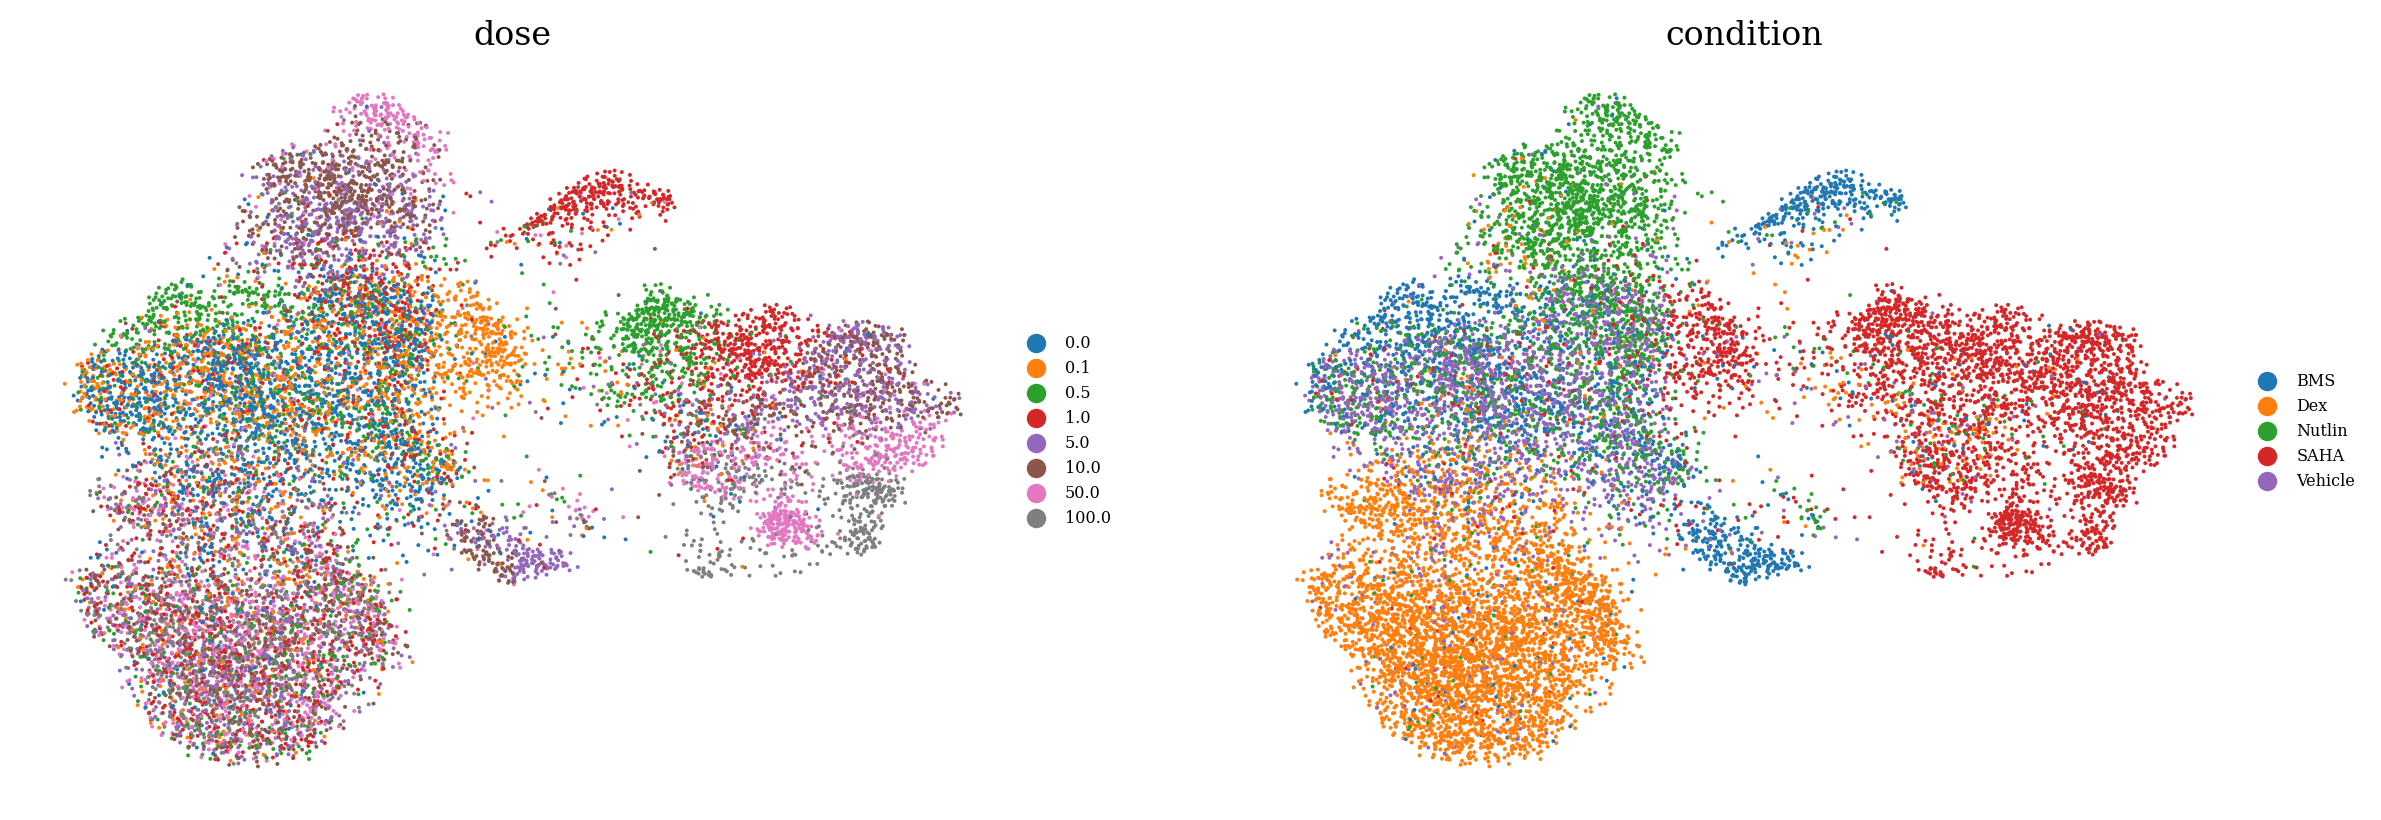

In [20]:
sc.pp.neighbors(latents["latent_after"])
sc.tl.umap(latents["latent_after"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_after"], 
        color=["dose", "condition"], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

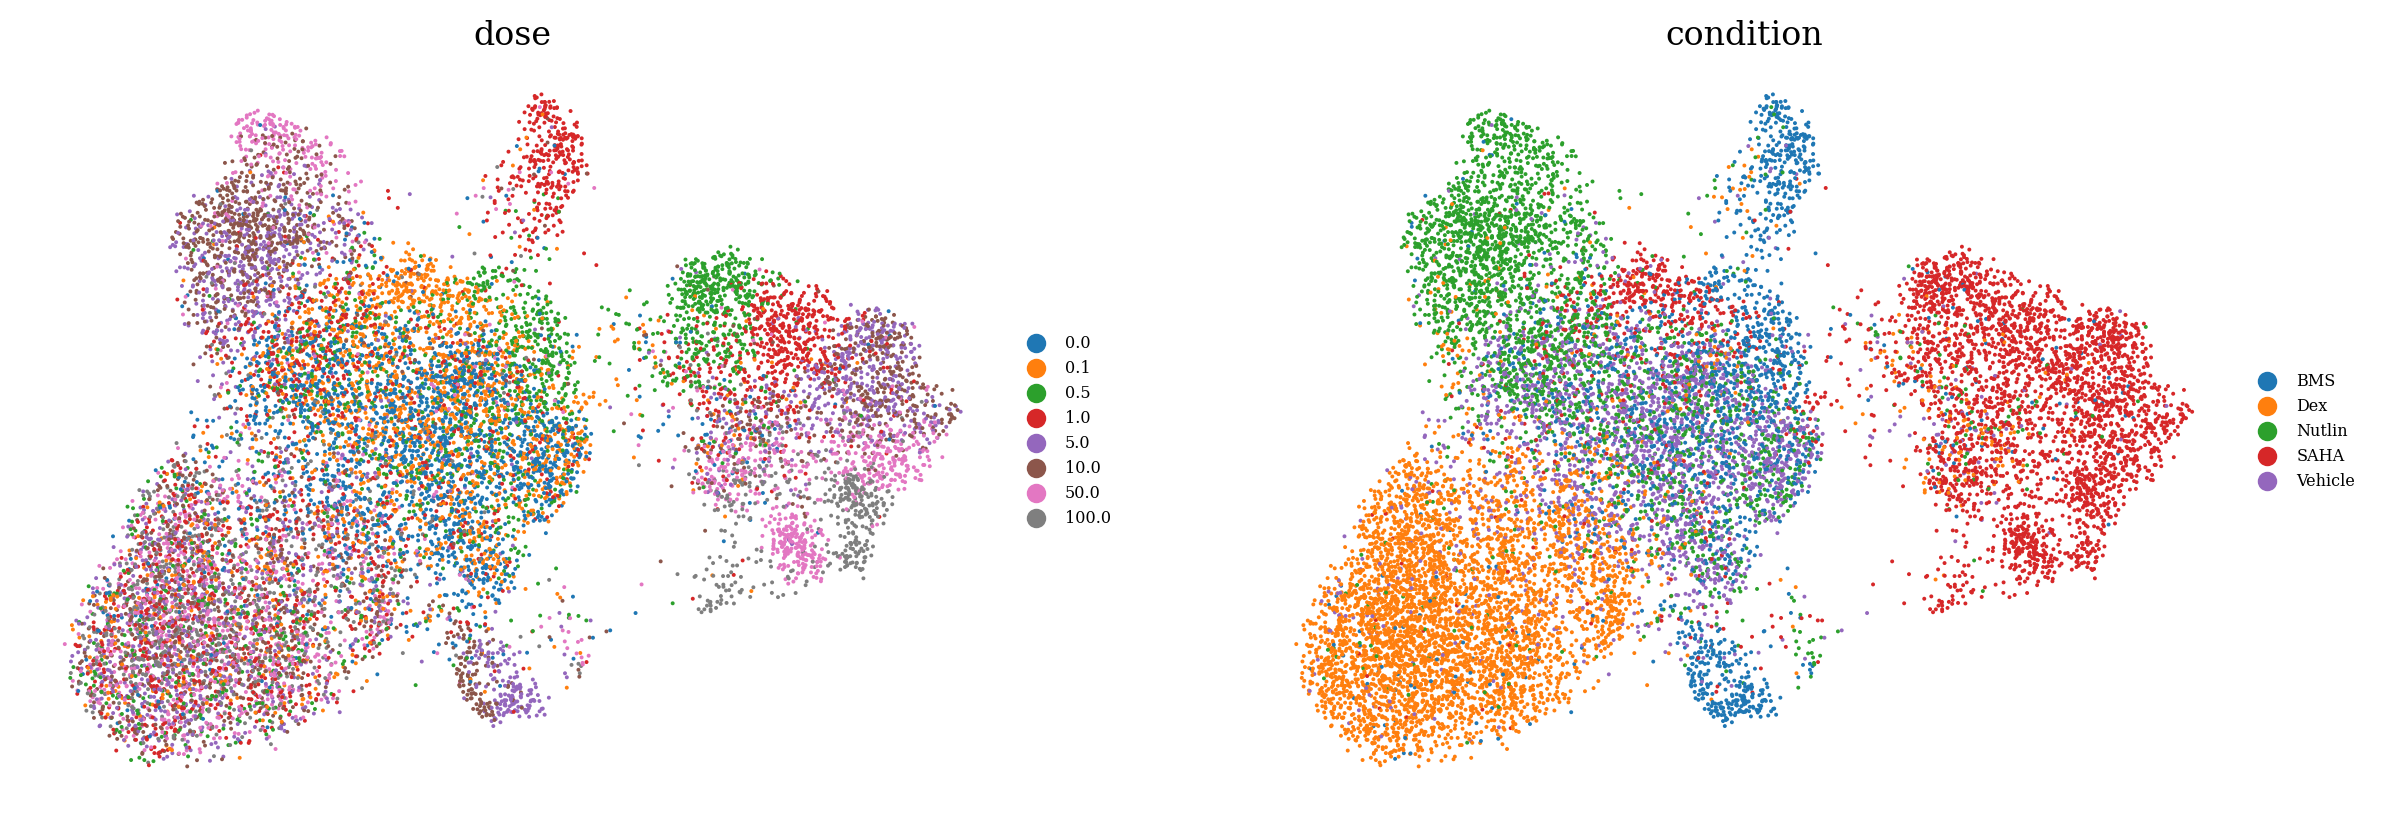

In [21]:
sc.pp.neighbors(latents["latent_basal"])
sc.tl.umap(latents["latent_basal"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_basal"], 
        color=["dose", "condition"], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

In [22]:
model.predict()

  0%|          | 0/463 [00:00<?, ?it/s]

  6%|▌         | 26/463 [00:00<00:01, 251.56it/s]

 11%|█         | 52/463 [00:00<00:01, 250.48it/s]

 17%|█▋        | 78/463 [00:00<00:01, 249.68it/s]

 22%|██▏       | 103/463 [00:00<00:01, 249.42it/s]

 28%|██▊       | 128/463 [00:00<00:01, 249.60it/s]

 33%|███▎      | 153/463 [00:00<00:01, 249.24it/s]

 39%|███▊      | 179/463 [00:00<00:01, 249.91it/s]

 44%|████▍     | 204/463 [00:00<00:01, 249.52it/s]

 50%|████▉     | 230/463 [00:00<00:00, 249.83it/s]

 55%|█████▌    | 255/463 [00:01<00:00, 249.71it/s]

 60%|██████    | 280/463 [00:01<00:00, 247.53it/s]

 66%|██████▌   | 306/463 [00:01<00:00, 248.72it/s]

 72%|███████▏  | 332/463 [00:01<00:00, 249.22it/s]

 77%|███████▋  | 358/463 [00:01<00:00, 250.00it/s]

 83%|████████▎ | 384/463 [00:01<00:00, 250.42it/s]

 89%|████████▊ | 410/463 [00:01<00:00, 250.55it/s]

 94%|█████████▍| 436/463 [00:01<00:00, 250.26it/s]

100%|█████████▉| 462/463 [00:01<00:00, 250.70it/s]

100%|██████████| 463/463 [00:01<00:00, 249.53it/s]

In [23]:
pred_adata = adata[model.test_indices].copy()
true = pred_adata.X.A
pred = pred_adata.obsm["CPA_pred"]

In [24]:
batch_size = 32

r2s = []
start_ind = 0
for end_ind in range(batch_size, len(true), batch_size):
    t = true[start_ind:end_ind]
    p = pred[start_ind:end_ind]
    r2 = sklearn.metrics.r2_score(y_true=t.mean(axis=0), y_pred=p.mean(axis=0))
    r2s.append(r2)
    start_ind = end_ind
np.mean(r2s)

0.9903123979737435

In [25]:
dir_path_latent = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/_temporary/latent",
    f"sciplex_cpa_ood-seed-{ood_seed}_size-{num_ood}.h5ad"
)
adata.write_h5ad(dir_path_latent)